In [1]:
#pip install prophet
#pip install pathos

In [2]:
import sys
sys.path.append(str('/home/jupyter/SearchForecasting/'))
from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [3]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/SearchForecasting/Spain/June 2024 Update/config ups spain.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

06.05.2024


In [4]:
daily_df = GetBQData(training_query, _input, _output)

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [5]:
df = daily_df.copy()
df = df.groupby(['market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# log Transformation
# df['cost'] = np.log(df['cost'])
# df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

df.ds = pd.to_datetime(df.ds)
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

#Combine Tablet and desktop together 
#For November data, use the daily average for that year to fill the missing data

In [6]:
daily_df

,region,market,funnel,account_type,ds,X,y
0,EMEA,Spain,-,Desktop,2022-01-01,60.75,11.0
1,EMEA,Spain,-,Desktop,2022-01-02,146.65,33.0
2,EMEA,Spain,-,Desktop,2022-01-03,773.24,402.0
3,EMEA,Spain,-,Desktop,2022-01-04,618.73,332.0
4,EMEA,Spain,-,Desktop,2022-01-05,504.71,177.0
...,...,...,...,...,...,...,...
1637,EMEA,Spain,-,Mobile & Tablet,2024-04-26,50.46,9.0
1638,EMEA,Spain,-,Mobile & Tablet,2024-04-27,25.35,9.0
1639,EMEA,Spain,-,Mobile & Tablet,2024-04-28,17.31,5.0
1640,EMEA,Spain,-,Mobile & Tablet,2024-04-29,75.18,15.0


In [7]:
# df = daily_df.copy()
# df.market = 'US'
# df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

# # log Transformation
# # df['cost'] = np.log(df['cost'])
# # df.loc[(df['cost'] < 0) | (np.isinf(df['cost'])), 'cost'] = 0

# df.ds = pd.to_datetime(df.ds)

# df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
# df = df[df.ds < cutoff_month]
# # remove inactive days
# df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
#        axis = 0, inplace = True)
# df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
#        axis = 0, inplace = True)

# df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
#        axis = 0, inplace = True)

# # add regressors
# df['anomaly_2021'] = df['ds'].apply(lambda x: 1 if (x >= datetime.datetime(2021,8,1))\
#                                      & (x <= datetime.datetime(2021,10,31)) else 0)
# df['covid_year_dummy'] = 0
# df.loc[(df['ds'] >= '2020-01-01') & (df['ds'] <= '2020-12-31'), 'Covid_Year_Dummy'] = 1

# df['weekday_or_weekend'] = df['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# # set cap and floor for log regression
# df['Month of Ds'] = df['ds'].dt.month_name()

# df['floor'] = 0

# boundary_df = pd.read_csv('Floor Cap Setting 2022.csv')
# boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
# boundary_df.drop(['Market'], axis = 1, inplace = True)

# df = pd.merge(df, boundary_df, on = ['account_type', 'funnel'])
# df['cap'] = df.ROAS * df.X / df.AOV
# df.loc[df.cap == 0, 'cap'] = df.cap.max()

# # df.to_csv(f'Daily Data {today}.csv')
# df.tail()

#del df

In [8]:
df['ds'] = pd.to_datetime(df['ds'])

In [9]:
# Filter the data for the year 2022
df_2022 = df[df['ds'].dt.year == 2022]

# Get the unique account types
account_types = df['account_type'].unique()

# Initialize an empty dataframe to store the filled November data
filled_november_data = pd.DataFrame()

# Loop through the unique account types
for account_type in account_types:
    # Filter the data for the current account type
    df_2022_account_type = df_2022[df_2022['account_type'] == account_type]

    # Group the data by day of the month and calculate the mean for X and y columns
    daily_avg_2022 = df_2022_account_type.groupby(df_2022_account_type['ds'].dt.day)[['X', 'y']].mean()

    # Create a new dataframe for November 2022 with date range from 1st to 30th
    november_2022 = pd.date_range(start='2022-11-01', end='2022-11-30', freq='D')
    november_df = pd.DataFrame(november_2022, columns=['ds'])

    # Merge the daily averages with the November dataframe
    filled_november_df = november_df.merge(daily_avg_2022, left_on=november_df['ds'].dt.day, right_index=True)

    # Update the 'ds' column with the correct dates for November 2022
    filled_november_df['ds'] = november_2022

    # Forward-fill the missing values in region, market, funnel, and account_type columns
    filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
    filled_november_df['account_type'] = account_type

    # Append the filled November data for the current account type to the filled_november_data dataframe
    filled_november_data = pd.concat([filled_november_data, filled_november_df], ignore_index=True)

# Append the filled November data to the original dataframe
df_filled = pd.concat([df, filled_november_data], ignore_index=True).drop(columns='key_0')

/var/tmp/ipykernel_105204/2854013778.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_105204/2854013778.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filled_november_df[['region', 'market', 'funnel']] = df_2022_account_type[['region', 'market', 'funnel']].fillna(method='ffill').iloc[-1]
/var/tmp/ipykernel_105204/2854013778.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

In [10]:
#missing_data_df = pd.DataFrame(missing_data)
#df = pd.concat([df, missing_data_df], ignore_index=True)

In [11]:
df_filled['weekday_or_weekend'] = df_filled['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# set cap and floor for log regression
df_filled['Month of Ds'] = df_filled['ds'].dt.month_name()

df_filled['floor'] = 0

boundary_df = pd.read_csv(base_path + 'Spain Floor Cap Setting June 2024.csv')
boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
boundary_df.drop(['Market'], axis = 1, inplace = True)

In [12]:
df_filled

,market,account_type,funnel,ds,region,X,y,weekday_or_weekend,Month of Ds,floor
0,Spain,Desktop,-,2022-01-01,EMEA,60.750000,11.000000,1,January,0
1,Spain,Desktop,-,2022-01-02,EMEA,146.650000,33.000000,1,January,0
2,Spain,Desktop,-,2022-01-03,EMEA,773.240000,402.000000,0,January,0
3,Spain,Desktop,-,2022-01-04,EMEA,618.730000,332.000000,0,January,0
4,Spain,Desktop,-,2022-01-05,EMEA,504.710000,177.000000,0,January,0
...,...,...,...,...,...,...,...,...,...,...
1697,Spain,Mobile & Tablet,-,2022-11-26,EMEA,145.077273,9.727273,1,November,0
1698,Spain,Mobile & Tablet,-,2022-11-27,EMEA,100.128182,9.545455,1,November,0
1699,Spain,Mobile & Tablet,-,2022-11-28,EMEA,87.284545,11.000000,0,November,0
1700,Spain,Mobile & Tablet,-,2022-11-29,EMEA,88.184000,7.600000,0,November,0


In [13]:
df_filled['weekday_or_weekend'] = df_filled['ds'].apply(lambda x: 1 if x.dayofweek > 4 else 0)

# set cap and floor for log regression
df_filled['Month of Ds'] = df_filled['ds'].dt.month_name()

df_filled['floor'] = 0

boundary_df = pd.read_csv(base_path + 'Spain Floor Cap Setting June 2024.csv')
boundary_df.rename(columns = {'Account Type': 'account_type', 'Funnel':'funnel'}, inplace = True)
boundary_df.drop(['Market'], axis = 1, inplace = True)

df_filled = pd.merge(df_filled, boundary_df, on = ['account_type', 'funnel'], suffixes=['', '_y']).drop(columns='region_y')
df_filled['cap'] = df_filled.ROAS * df_filled.X / df_filled.AOV
df_filled.loc[df_filled.cap == 0, 'cap'] = df_filled.cap.max()

df_filled.to_csv(f'Daily Data {today}.csv')
df_filled.to_csv(base_path + 'df_filled.csv')

df_filled

,market,account_type,funnel,ds,region,X,y,weekday_or_weekend,Month of Ds,floor,revenue,cost,conversion,AOV,ROAS,cap
0,Spain,Desktop,-,2022-01-01,EMEA,60.750000,11.000000,1,January,0,2.266402e+06,8355484.22,71899,31.522022,0.271247,0.522754
1,Spain,Desktop,-,2022-01-02,EMEA,146.650000,33.000000,1,January,0,2.266402e+06,8355484.22,71899,31.522022,0.271247,1.261924
2,Spain,Desktop,-,2022-01-03,EMEA,773.240000,402.000000,0,January,0,2.266402e+06,8355484.22,71899,31.522022,0.271247,6.653736
3,Spain,Desktop,-,2022-01-04,EMEA,618.730000,332.000000,0,January,0,2.266402e+06,8355484.22,71899,31.522022,0.271247,5.324176
4,Spain,Desktop,-,2022-01-05,EMEA,504.710000,177.000000,0,January,0,2.266402e+06,8355484.22,71899,31.522022,0.271247,4.343033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,Spain,Mobile & Tablet,-,2022-11-26,EMEA,145.077273,9.727273,1,November,0,6.444920e+04,536891.88,2800,23.017573,0.120041,0.756607
1698,Spain,Mobile & Tablet,-,2022-11-27,EMEA,100.128182,9.545455,1,November,0,6.444920e+04,536891.88,2800,23.017573,0.120041,0.522189
1699,Spain,Mobile & Tablet,-,2022-11-28,EMEA,87.284545,11.000000,0,November,0,6.444920e+04,536891.88,2800,23.017573,0.120041,0.455207
1700,Spain,Mobile & Tablet,-,2022-11-29,EMEA,88.184000,7.600000,0,November,0,6.444920e+04,536891.88,2800,23.017573,0.120041,0.459897


# Analytical File Generator

In [14]:
generator = AnalyticalFileGenerator(config_dict)
analytical_file_df = generator.generate()
analytical_file_df = pd.merge(analytical_file_df, boundary_df, on = ['account_type', 'funnel'])
analytical_file_df.to_csv(analytical_file_path)

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [15]:
[col for col in analytical_file_df.columns if 'Spain' in col]

['Spain_Desktop_-_Apr_2024',
 'Spain_Desktop_-_Aug_2024',
 'Spain_Desktop_-_Dec_2024',
 'Spain_Desktop_-_Jul_2024',
 'Spain_Desktop_-_Jun_2024',
 'Spain_Desktop_-_May_2024',
 'Spain_Desktop_-_Nov_2024',
 'Spain_Desktop_-_Oct_2024',
 'Spain_Desktop_-_Sep_2024',
 'Spain_Mobile_&_Tablet_-_Apr_2024',
 'Spain_Mobile_&_Tablet_-_Aug_2024',
 'Spain_Mobile_&_Tablet_-_Dec_2024',
 'Spain_Mobile_&_Tablet_-_Jul_2024',
 'Spain_Mobile_&_Tablet_-_Jun_2024',
 'Spain_Mobile_&_Tablet_-_May_2024',
 'Spain_Mobile_&_Tablet_-_Nov_2024',
 'Spain_Mobile_&_Tablet_-_Oct_2024',
 'Spain_Mobile_&_Tablet_-_Sep_2024']

In [16]:
cuts_df = pd.read_csv(base_path + region + ' Breakdown June 2024.csv')
cuts_df['periods'] = periods
cuts_df['periods_for_acc_cal'] = 183
cuts_df['cutoff_month'] = cutoff_month
# cuts_df.account_type = 'unified'
cuts_df.input_mode = 'multiplicative'
query_item_list = [query_item for query_item in [config_dict["CLIENTINFO"]["breakdown1"], \
                             config_dict["CLIENTINFO"]["breakdown2"], \
                             config_dict["CLIENTINFO"]["breakdown3"], \
                             config_dict["CLIENTINFO"]["breakdown4"]]
                             if query_item != None]
cuts_df.drop(columns='Unnamed: 0', inplace=True)
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
0,Spain,Desktop,-,183,0.05,1.0,0.1,additive,multiplicative,additive,...,na,na,na,na,na,linear,22.22,8.62,251.0,2024-04-25
1,Spain,Mobile & Tablet,-,183,0.10,10.0,10.0,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,linear,14.61,11.93,251.0,2024-04-25


# Accuracy Calculator

generic_df = pd.read_csv("record_df 2023-08-16 18:16:20 best result.csv")
generic_df

In [19]:
# %load_ext autoreload
# %autoreload 2


calculator = AccuracyCalculator()
accuracy_df = calculator.CalculateAccuracy(cuts_df, df_filled, query_item_list)
# calculator.SaveFile()

03:38:27 - cmdstanpy - INFO - Chain [1] start processing
03:38:28 - cmdstanpy - INFO - Chain [1] done processing
/home/jupyter/SearchForecasting/repo/Accuracy.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.monthly_acc_df_temp = pd.concat([self.monthly_acc_df_temp, monthly_acc_df], ignore_index=True)
03:38:28 - cmdstanpy - INFO - Chain [1] start processing
03:38:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.24 Period MAE: 25.180000000000003
It's underpredicted.
Monthly Error: 14.61 Period MAE: 11.93


In [20]:
accuracy_df.to_csv(base_path + 'test_Acc.csv')

In [21]:
# This is to convert error metrics to accuracy. Note the column names won't change
100-accuracy_df.groupby(['account_type']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
account_type,,,,,
Desktop,-4887.428571,-3631.625714,78.934286,72.76,74.82
Mobile & Tablet,-120.142857,-93.881429,90.325714,85.39,88.07


In [23]:
100-accuracy_df.groupby(['market']).mean(numeric_only=1)

,Actual,Forecast,Percentage Error,MAPE,Forecast Period MAE
market,,,,,
Spain,-2503.785714,-1862.753571,84.63,79.075,81.445


In [23]:
# param_grid = {
#                 'changepoint_prior_scale': [0.05],# ,0.001,0.1, 0.5], #  
#                 'seasonality_prior_scale': [10.0],#,0.01,  0.1, 1.0], #
#                 'holidays_prior_scale': [0.01],#,0.1,1.0, 10.0], #
#                 'seasonality_mode': ['additive'],#,'multiplicative'], #
#                 'input_mode': ['na'], #'additive','multiplicative'], #
#                 'weekday_or_weekend':['na'],#, 'additive', 'multiplicative'],  #
#                 'include_holiday': ['na'],#, 'default', 'customized'],#
#                 'covid_year_exclude':['na'],
#                 'covid_year_dummy':['na'],
#                 'anomaly_2021':['na'],
#                 'generic_cost_split':['na'],#, 'additive'],#
#                 'competitor_cost_split':['na'],#, 'additive'], #
#                 'new_confirmed':['na'],#, 'additive'],#
#             }
param_grid = {
    'changepoint_prior_scale': [ 0.1, 0.05],   # 0.001
    'seasonality_prior_scale': [10.0, 1.0, 0.1],  # 0.01
    'holidays_prior_scale': [10.0, 1.0,  0.1], # 0.01
    'seasonality_mode': ['additive','multiplicative'], #'multiplicative'
    'input_mode': ['additive','multiplicative'],  #,'multiplicative'
    'weekday_or_weekend':['na', 'additive','multiplicative'],  #, 'multiplicative'
    'include_holiday': ['na','Default', 'Custom'], #'Default', 'custom'
    'covid_year_exclude':['na'],
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'],
    'anomaly_2021':['na'],#, 'additive', 'multiplicative'],
    'generic_cost_split':['na'],#, 'additive', 'multiplicative'
    'competitor_cost_split':['na'], #, 'additive', 'multiplicative'
    'new_confirmed': ['na'],#, 'additive', 'multiplicative'
            }

cuts_df_mobile = cuts_df.query("account_type == 'Mobile & Tablet'")

cuts_df_desktop = cuts_df.loc[cuts_df['account_type'] == 'Desktop'] 
cuts_df_mobile

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,MAPE,period_AE,periods,cutoff_month
1,Spain,Mobile & Tablet,-,183,0.1,1.0,10.0,multiplicative,multiplicative,multiplicative,...,na,na,na,na,na,linear,19.31,20.32,251.0,2024-04-25


# Parallel Param Search

In [ ]:
# %load_ext autoreload
# %autoreload 2
# search_engine = ProphetParameterSearch(power_flag = False) # , logistic_flag = False
# # search_engine.add_power_params()
# grid_brand = search_engine.search(cuts_df, df_filled)
# #grid_bing = search_engine.search(cuts_df[(cuts_df.index==0)], df_filled)

# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(param_grid=param_grid, power_flag = False, base_path=base_path) # 
# search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# Mobile
grid_brand_mobile = search_engine.search(cuts_df_mobile, df_filled) #competitor and bing generic

  0%|          | 0/1 [00:00<?, ?it/s]22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:35 - cmdstanpy - INFO - Chain [1] start processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing
22:22:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.96 Period MAE: 61.39


22:22:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 78.75


22:22:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.76 Period MAE: 65.0


22:22:40 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.23 Period MAE:It's underpredicted. 76.87

Monthly Error: 49.92 Period MAE: 51.53


22:22:42 - cmdstanpy - INFO - Chain [1] start processing
22:22:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.17 Period MAE: 53.83


22:22:43 - cmdstanpy - INFO - Chain [1] start processing
22:22:44 - cmdstanpy - INFO - Chain [1] done processing
22:22:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.62 Period MAE: 68.88


22:22:45 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.64 Period MAE: 12.47


22:22:46 - cmdstanpy - INFO - Chain [1] start processing
22:22:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.73 Period MAE: 61.06


22:22:47 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] done processing
22:22:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.82 Period MAE: 12.5


22:22:48 - cmdstanpy - INFO - Chain [1] start processing
22:22:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.06 Period MAE: 66.33
It's underpredicted.
Monthly Error: 55.31 Period MAE: 56.81


22:22:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:50 - cmdstanpy - INFO - Chain [1] done processing
22:22:51 - cmdstanpy - INFO - Chain [1] start processing
22:22:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.08 Period MAE: 78.75
It's overpredicted.
Monthly Error: 25.44 Period MAE: 14.04


22:22:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.69 Period MAE: 69.82000000000001


22:22:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:53 - cmdstanpy - INFO - Chain [1] done processing
22:22:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:53 - cmdstanpy - INFO - Chain [1] done processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error: 76.249.0  Period MAE:Period MAE: 50.64999999999999 
76.84


22:22:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:22:55 - cmdstanpy - INFO - Chain [1] done processing


58.97 Period MAE: 60.36


22:22:56 - cmdstanpy - INFO - Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing
22:22:56 - cmdstanpy - INFO - Chain [1] start processing
22:22:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.76 Period MAE: 52.28
It's underpredicted.
Monthly Error: 61.21 Period MAE: 63.800000000000004
It's underpredicted.
Monthly Error: 77.0 Period MAE: 77.73


22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:22:59 - cmdstanpy - INFO - Chain [1] done processing
22:23:00 - cmdstanpy - INFO - Chain [1] start processing
22:23:00 - cmdstanpy - INFO - Chain [1] done processing
22:23:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.46 Period MAE: 76.17
It's underpredicted.
Monthly Error: 46.58 Period MAE: 48.28


22:23:01 - cmdstanpy - INFO - Chain [1] start processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.04 Period MAE: 40.760000000000005


22:23:02 - cmdstanpy - INFO - Chain [1] start processing
22:23:03 - cmdstanpy - INFO - Chain [1] start processing
22:23:03 - cmdstanpy - INFO - Chain [1] done processing
22:23:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.85 Period MAE: 64.42
It's underpredicted.
Monthly Error: 48.52 Period MAE: 50.09


22:23:06 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.1 Period MAE: 13.54


22:23:06 - cmdstanpy - INFO - Chain [1] start processing
22:23:06 - cmdstanpy - INFO - Chain [1] start processing
22:23:06 - cmdstanpy - INFO - Chain [1] done processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.14 Period MAE: 13.139999999999999


22:23:08 - cmdstanpy - INFO - Chain [1] start processing
22:23:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.42 Period MAE: 53.06999999999999
It's underpredicted.
Monthly Error: 26.36 Period MAE: 

22:23:09 - cmdstanpy - INFO - Chain [1] start processing


28.23


22:23:10 - cmdstanpy - INFO - Chain [1] done processing
22:23:10 - cmdstanpy - INFO - Chain [1] start processing
22:23:10 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.0 Period MAE: 15.479999999999999
It's underpredicted.
Monthly Error: 76.88 Period MAE: 77.61
It's underpredicted.
Monthly Error: 45.81 Period MAE: 47.449999999999996


22:23:12 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:13 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:61.02 73.85 Period MAE:  62.629999999999995
Period MAE: 74.62


22:23:14 - cmdstanpy - INFO - Chain [1] start processing
22:23:15 - cmdstanpy - INFO - Chain [1] done processing
22:23:15 - cmdstanpy - INFO - Chain [1] start processing
22:23:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.8 Period MAE: 45.440000000000005


22:23:17 - cmdstanpy - INFO - Chain [1] start processing
22:23:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.49 Period MAE: 52.22
It's underpredicted.
Monthly Error: 57.71 Period MAE: 60.440000000000005
It's underpredicted.
Monthly Error: 89.92 Period MAE: 90.53


22:23:19 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.36 Period MAE: 62.949999999999996


22:23:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 90.77 Period MAE: 91.34


22:23:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.99 Period MAE: 45.71


22:23:22 - cmdstanpy - INFO - Chain [1] start processing
22:23:23 - cmdstanpy - INFO - Chain [1] done processing
22:23:23 - cmdstanpy - INFO - Chain [1] start processing
22:23:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 91.25 Period MAE: 91.79
It's underpredicted.
Monthly Error: 55.11 Period MAE: 56.76


22:23:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.42 Period MAE: 58.06


22:23:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.75 Period MAE: 

22:23:26 - cmdstanpy - INFO - Chain [1] done processing


61.260000000000005


22:23:26 - cmdstanpy - INFO - Chain [1] done processing
22:23:26 - cmdstanpy - INFO - Chain [1] start processing
22:23:26 - cmdstanpy - INFO - Chain [1] start processing
22:23:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:23:27 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 38.38 Period MAE: 40.27
It's underpredicted.
Monthly Error: 35.89 Period MAE: 37.669999999999995


22:23:28 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] done processing
22:23:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.43 Period MAE: 64.9
It's underpredicted.

22:23:31 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 22.27 Period MAE: 22.53
It's underpredicted.
Monthly Error: 19.86 Period MAE: 20.72


22:23:32 - cmdstanpy - INFO - Chain [1] start processing
22:23:32 - cmdstanpy - INFO - Chain [1] done processing
22:23:33 - cmdstanpy - INFO - Chain [1] start processing
22:23:33 - cmdstanpy - INFO - Chain [1] done processing
22:23:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.44 Period MAE: 38.36
It's underpredicted.
Monthly Error: 69.66 

22:23:34 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 70.93


22:23:34 - cmdstanpy - INFO - Chain [1] done processing
22:23:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.67 Period MAE: 27.52


22:23:35 - cmdstanpy - INFO - Chain [1] done processing
22:23:36 - cmdstanpy - INFO - Chain [1] start processing
22:23:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.69 Period MAE: 42.51
It's underpredicted.
Monthly Error: 21.81 Period MAE: 19.33
It's underpredicted.
Monthly Error: 87.71 Period MAE: 88.4


22:23:38 - cmdstanpy - INFO - Chain [1] start processing
22:23:39 - cmdstanpy - INFO - Chain [1] start processing
22:23:39 - cmdstanpy - INFO - Chain [1] done processing
22:23:39 - cmdstanpy - INFO - Chain [1] start processing
22:23:39 - cmdstanpy - INFO - Chain [1] done processing
22:23:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 87.79 Period MAE: 88.48
It's underpredicted.
Monthly Error:

22:23:41 - cmdstanpy - INFO - Chain [1] start processing


 47.37 Period MAE: 49.15


22:23:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.4 Period MAE: 31.290000000000003


22:23:42 - cmdstanpy - INFO - Chain [1] start processing
22:23:42 - cmdstanpy - INFO - Chain [1] done processing
22:23:42 - cmdstanpy - INFO - Chain [1] start processing
22:23:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.25 Period MAE: 46.01
It's underpredicted.
Monthly Error: 87.56 Period MAE: 88.25
It's underpredicted.
Monthly Error: 55.79 Period MAE: 57.36


22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:45 - cmdstanpy - INFO - Chain [1] start processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.13 Period MAE: 67.31
It's underpredicted.
Monthly Error: 14.61 Period MAE: 11.93


22:23:47 - cmdstanpy - INFO - Chain [1] start processing
22:23:48 - cmdstanpy - INFO - Chain [1] done processing
22:23:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.57 Period MAE: 33.42


22:23:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.11 Period MAE: 88.79


22:23:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.42 Period MAE: 30.81


22:23:51 - cmdstanpy - INFO - Chain [1] done processing
22:23:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 20.0 Period MAE: 21.09


22:23:52 - cmdstanpy - INFO - Chain [1] start processing
22:23:52 - cmdstanpy - INFO - Chain [1] start processing
22:23:52 - cmdstanpy - INFO - Chain [1] done processing
22:23:53 - cmdstanpy - INFO - Chain [1] done processing
22:23:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.88 Period MAE: 53.55


22:23:54 - cmdstanpy - INFO - Chain [1] start processing
22:23:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.12 Period MAE: 64.74
It's underpredicted.
Monthly Error: 19.55 Period MAE: 20.76


22:23:55 - cmdstanpy - INFO - Chain [1] start processing
22:23:56 - cmdstanpy - INFO - Chain [1] done processing
22:23:56 - cmdstanpy - INFO - Chain [1] start processing
22:23:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.32 Period MAE: 89.01
It's underpredicted.
Monthly Error: 78.05 Period MAE: 78.73


22:23:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.12 Period MAE: 57.58


22:23:58 - cmdstanpy - INFO - Chain [1] start processing
22:23:58 - cmdstanpy - INFO - Chain [1] done processing
22:23:59 - cmdstanpy - INFO - Chain [1] done processing
22:23:59 - cmdstanpy - INFO - Chain [1] start processing
22:23:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.97 Period MAE: 49.71It's underpredicted.

Monthly Error:
 76.07 Period MAE: It's underpredicted.76.72

Monthly Error: 55.54 Period MAE: 57.02

22:24:01 - cmdstanpy - INFO - Chain [1] start processing
22:24:01 - cmdstanpy - INFO - Chain [1] done processing
22:24:02 - cmdstanpy - INFO - Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] start processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing
22:24:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.98 Period MAE: 56.48
It's overpredicted.
Monthly Error: 24.56 Period MAE: It's underpredicted.
12.34
Monthly Error: 64.9 Period MAE: 67.12


22:24:06 - cmdstanpy - INFO - Chain [1] start processing
22:24:06 - cmdstanpy - INFO - Chain [1] start processing
22:24:07 - cmdstanpy - INFO - Chain [1] done processing
22:24:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 24.68 Period MAE: 12.25


22:24:07 - cmdstanpy - INFO - Chain [1] done processing
22:24:07 - cmdstanpy - INFO - Chain [1] done processing
22:24:07 - cmdstanpy - INFO - Chain [1] start processing
22:24:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.92 Period MAE: 66.2


22:24:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:24:10 - cmdstanpy - INFO - Chain [1] done processing


53.05 Period MAE: 54.6


22:24:11 - cmdstanpy - INFO - Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
 Monthly Error:78.05  Period MAE: 78.7325.43
 Period MAE: 14.04
It's underpredicted.
Monthly Error: 59.24 Period MAE: 60.589999999999996


22:24:13 - cmdstanpy - INFO - Chain [1] start processing
22:24:13 - cmdstanpy - INFO - Chain [1] start processing
22:24:13 - cmdstanpy - INFO - Chain [1] done processing
22:24:13 - cmdstanpy - INFO - Chain [1] start processing
22:24:13 - cmdstanpy - INFO - Chain [1] done processing
22:24:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.03 Period MAE: 44.82


22:24:15 - cmdstanpy - INFO - Chain [1] start processing
22:24:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.09 Period MAE: 76.74
It's underpredicted.
Monthly Error: 59.59 Period MAE: 60.95


22:24:17 - cmdstanpy - INFO - Chain [1] start processing
22:24:17 - cmdstanpy - INFO - Chain [1] start processing
22:24:17 - cmdstanpy - INFO - Chain [1] done processing
22:24:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.99 Period MAE: 69.23
It's underpredicted.
Monthly Error: 76.95 Period MAE: 77.69


22:24:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.9 Period MAE: 42.64


22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.49 Period MAE: 76.2


22:24:21 - cmdstanpy - INFO - Chain [1] start processing
22:24:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.25 Period MAE: 46.98
It's underpredicted.
Monthly Error: 41.2 Period MAE: 42.89


22:24:23 - cmdstanpy - INFO - Chain [1] start processing
22:24:23 - cmdstanpy - INFO - Chain [1] done processing
22:24:24 - cmdstanpy - INFO - Chain [1] start processing
22:24:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.52 Period MAE: 63.06
It's underpredicted.
Monthly Error: 34.25 Period MAE:It's overpredicted. 
36.07Monthly Error:
 22.93 Period MAE: 
13.239999999999998

22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:26 - cmdstanpy - INFO - Chain [1] done processing
22:24:26 - cmdstanpy - INFO - Chain [1] start processing
22:24:27 - cmdstanpy - INFO - Chain [1] done processing
22:24:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.03 Period MAE: 13.0
It's underpredicted.
Monthly Error: 48.8 Period MAE: 50.5


22:24:28 - cmdstanpy - INFO - Chain [1] start processing
22:24:28 - cmdstanpy - INFO - Chain [1] done processing
22:24:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 32.52 Period MAE: 34.29


22:24:30 - cmdstanpy - INFO - Chain [1] done processing
22:24:31 - cmdstanpy - INFO - Chain [1] start processing
22:24:31 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.62 Period MAE: 43.34
It's overpredicted.
Monthly Error: 24.06 Period MAE: 15.68
It's underpredicted.
Monthly Error: 76.87 Period MAE: 77.60000000000001


22:24:32 - cmdstanpy - INFO - Chain [1] start processing
22:24:33 - cmdstanpy - INFO - Chain [1] start processing
22:24:33 - cmdstanpy - INFO - Chain [1] done processing
22:24:33 - cmdstanpy - INFO - Chain [1] start processing
22:24:33 - cmdstanpy - INFO - Chain [1] done processing
22:24:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 72.87
 Monthly Error:Period MAE:  73.6161.9
 Period MAE: 63.5


22:24:35 - cmdstanpy - INFO - Chain [1] start processing
22:24:35 - cmdstanpy - INFO - Chain [1] done processing
22:24:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.49 Period MAE:

22:24:36 - cmdstanpy - INFO - Chain [1] done processing


 47.11


22:24:37 - cmdstanpy - INFO - Chain [1] start processing
22:24:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.72 Period MAE: 52.449999999999996
It's underpredicted.
Monthly Error: 58.86 Period MAE: 61.519999999999996
It's underpredicted.
Monthly Error: 90.85 Period MAE: 91.41


22:24:39 - cmdstanpy - INFO - Chain [1] start processing
22:24:39 - cmdstanpy - INFO - Chain [1] start processing
22:24:39 - cmdstanpy - INFO - Chain [1] start processing
22:24:39 - cmdstanpy - INFO - Chain [1] done processing
22:24:40 - cmdstanpy - INFO - Chain [1] done processing
22:24:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.43 Period MAE: 87.14


22:24:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.47 Period MAE: 

22:24:41 - cmdstanpy - INFO - Chain [1] done processing


50.27
It's underpredicted.
Monthly Error: 42.8 Period MAE: 44.55


22:24:42 - cmdstanpy - INFO - Chain [1] start processing
22:24:43 - cmdstanpy - INFO - Chain [1] done processing
22:24:43 - cmdstanpy - INFO - Chain [1] start processing
22:24:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.09 Period MAE:It's underpredicted.
 Monthly Error:55.76 52.92
 Period MAE: 54.65
It's underpredicted.
Monthly Error: 75.75 Period MAE: 76.83


22:24:45 - cmdstanpy - INFO - Chain [1] start processing
22:24:46 - cmdstanpy - INFO - Chain [1] start processing
22:24:46 - cmdstanpy - INFO - Chain [1] start processing
22:24:46 - cmdstanpy - INFO - Chain [1] done processing
22:24:46 - cmdstanpy - INFO - Chain [1] done processing
22:24:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.96 Period MAE: 39.85
It's underpredicted.
Monthly Error:

22:24:48 - cmdstanpy - INFO - Chain [1] start processing


 56.02 Period MAE: 57.65


22:24:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.64 Period MAE: 

22:24:49 - cmdstanpy - INFO - Chain [1] start processing


49.36


22:24:50 - cmdstanpy - INFO - Chain [1] done processing
22:24:50 - cmdstanpy - INFO - Chain [1] start processing
22:24:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
44.02Monthly Error:  Period MAE: 40.0845.9 
Period MAE: 41.89
It's underpredicted.
Monthly Error: 78.58 Period MAE: 79.57


22:24:53 - cmdstanpy - INFO - Chain [1] start processing
22:24:53 - cmdstanpy - INFO - Chain [1] start processing
22:24:54 - cmdstanpy - INFO - Chain [1] start processing
22:24:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.97 

22:24:54 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 75.12


22:24:54 - cmdstanpy - INFO - Chain [1] done processing
22:24:55 - cmdstanpy - INFO - Chain [1] start processing
22:24:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.45 Period MAE: 47.25


22:24:56 - cmdstanpy - INFO - Chain [1] start processing
22:24:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.29 Period MAE: 26.16
It's underpredicted.
Monthly Error: 38.56 Period MAE: 40.400000000000006

22:24:58 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.
Monthly Error: 88.57 Period MAE: 89.2


22:24:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.5 Period MAE: 65.88000000000001


22:24:59 - cmdstanpy - INFO - Chain [1] start processing
22:24:59 - cmdstanpy - INFO - Chain [1] start processing
22:24:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:00 - cmdstanpy - INFO - Chain [1] done processing
22:25:00 - cmdstanpy - INFO - Chain [1] done processing
22:25:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.0 Period MAE: 46.81


22:25:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.58 Period MAE: 90.16
It's underpredicted.
Monthly Error: 

22:25:03 - cmdstanpy - INFO - Chain [1] done processing


37.2 Period MAE: 39.01
It's underpredicted.
Monthly Error: 84.08 Period MAE: 84.88


22:25:04 - cmdstanpy - INFO - Chain [1] start processing
22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing
22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.83 Period MAE: 42.63
It's underpredicted.
Monthly Error: 55.93 Period MAE: 57.48


22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:08 - cmdstanpy - INFO - Chain [1] done processing
22:25:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.83 Period MAE:

22:25:09 - cmdstanpy - INFO - Chain [1] done processing


 30.73
It's underpredicted.
Monthly Error: 

22:25:09 - cmdstanpy - INFO - Chain [1] start processing


53.07 Period MAE: 54.76


22:25:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 20.72 Period MAE: 22.830000000000002


22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:11 - cmdstanpy - INFO - Chain [1] done processing
22:25:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 82.84 29.01 Period MAE: Period MAE:  30.97
83.72
It's underpredicted.
Monthly Error: 37.73 Period MAE: 39.85


22:25:14 - cmdstanpy - INFO - Chain [1] start processing
22:25:14 - cmdstanpy - INFO - Chain [1] done processing
22:25:14 - cmdstanpy - INFO - Chain [1] start processing
22:25:14 - cmdstanpy - INFO - Chain [1] start processing
22:25:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.94 Period MAE: 76.13
It's underpredicted.
Monthly Error: 58.97 Period MAE: 60.42999999999999


22:25:16 - cmdstanpy - INFO - Chain [1] done processing
22:25:16 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] done processing
22:25:17 - cmdstanpy - INFO - Chain [1] start processing
22:25:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.66 Period MAE: 21.05
It's underpredicted.
Monthly Error: 52.41 Period MAE: 54.010000000000005


22:25:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 88.61 Period MAE: 89.27000000000001


22:25:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.06 Period MAE: 78.74


22:25:20 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] done processing
22:25:20 - cmdstanpy - INFO - Chain [1] start processing
22:25:20 - cmdstanpy - INFO - Chain [1] done processing
22:25:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.17 Period MAE: 59.650000000000006


22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 56.28 Period MAE: 57.79
It's underpredicted.
Monthly Error: 77.71 Period MAE: 78.39


22:25:24 - cmdstanpy - INFO - Chain [1] start processing
22:25:25 - cmdstanpy - INFO - Chain [1] start processing
22:25:25 - cmdstanpy - INFO - Chain [1] done processing
22:25:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.69 Period MAE: 77.59
It's overpredicted.
Monthly Error: 22.44 Period MAE: 8.57


22:25:27 - cmdstanpy - INFO - Chain [1] start processing
22:25:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.8

22:25:27 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 53.42


22:25:27 - cmdstanpy - INFO - Chain [1] done processing
22:25:27 - cmdstanpy - INFO - Chain [1] start processing
22:25:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.6 Period MAE: 8.63


22:25:29 - cmdstanpy - INFO - Chain [1] start processing
22:25:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.75 It's underpredicted.Period MAE: 63.11

Monthly Error: 52.73 Period MAE: 54.32
It's overpredicted.
Monthly Error: 22.37 Period MAE: 8.540000000000001


22:25:31 - cmdstanpy - INFO - Chain [1] start processing
22:25:31 - cmdstanpy - INFO - Chain [1] start processing
22:25:31 - cmdstanpy - INFO - Chain [1] done processing
22:25:31 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.07 Period MAE: 78.75
It's underpredicted.
Monthly Error: 54.63 Period MAE: 56.169999999999995


22:25:34 - cmdstanpy - INFO - Chain [1] start processing
22:25:34 - cmdstanpy - INFO - Chain [1] start processing
22:25:34 - cmdstanpy - INFO - Chain [1] done processing
22:25:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
Monthly Error:  55.01 48.52Period MAE: 56.55
 Period MAE:It's underpredicted. 
50.18
Monthly Error: 77.79 Period MAE: 78.47


22:25:36 - cmdstanpy - INFO - Chain [1] start processing
22:25:36 - cmdstanpy - INFO - Chain [1] done processing
22:25:36 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.45It's underpredicted.
 Period MAE:Monthly Error:  76.2545.2 
Period MAE: 76.92999999999999It's underpredicted.

Monthly Error:  76.72 Period MAE:77.62


22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.85 Period MAE: 76.53


22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing
22:25:41 - cmdstanpy - INFO - Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.57 Period MAE: 48.28


22:25:42 - cmdstanpy - INFO - Chain [1] done processing
22:25:42 - cmdstanpy - INFO - Chain [1] start processing
22:25:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.35 Period MAE: 46.04
It's overpredicted.
Monthly Error: 21.31 Period MAE: 10.56
It's underpredicted.
Monthly Error: 36.05 Period MAE: 37.91
It's underpredicted.
Monthly Error: 

22:25:45 - cmdstanpy - INFO - Chain [1] start processing


74.86 Period MAE: 75.77000000000001

22:25:45 - cmdstanpy - INFO - Chain [1] start processing


22:25:45 - cmdstanpy - INFO - Chain [1] done processing
22:25:46 - cmdstanpy - INFO - Chain [1] start processing
22:25:46 - cmdstanpy - INFO - Chain [1] done processing
22:25:46 - cmdstanpy - INFO - Chain [1] done processing
22:25:47 - cmdstanpy - INFO - Chain [1] start processing
22:25:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.04 Period MAE: 52.66
It's underpredicted.
Monthly Error: 41.35 

22:25:48 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 43.09


22:25:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.78 Period MAE: 11.12


22:25:50 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] done processing
22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.81 Period MAE: 11.709999999999999
It's underpredicted.
Monthly Error: 76.3 Period MAE: 76.98
It's underpredicted.
Monthly Error: 49.04 Period MAE: 50.660000000000004


22:25:53 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] start processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing
22:25:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.08 Period MAE: 48.89
It's underpredicted.
Monthly Error: 75.88 Period MAE: 76.55

22:25:55 - cmdstanpy - INFO - Chain [1] start processing


22:25:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.54 Period MAE: 45.24


22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:56 - cmdstanpy - INFO - Chain [1] start processing
22:25:56 - cmdstanpy - INFO - Chain [1] done processing
22:25:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.92 Period MAE: 75.83
It's underpredicted.
Monthly Error: 57.68 Period MAE: 59.35
It's underpredicted.
Monthly Error: 89.78

22:25:59 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 90.39


22:25:59 - cmdstanpy - INFO - Chain [1] done processing
22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.76 Period MAE: 91.32000000000001


22:26:01 - cmdstanpy - INFO - Chain [1] start processing
22:26:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.29It's underpredicted. 
Period MAE:Monthly Error:  57.1758.98 Period MAE:
 58.85
It's underpredicted.
Monthly Error: 85.81  Period MAE:86.56


22:26:04 - cmdstanpy - INFO - Chain [1] start processing
22:26:04 - cmdstanpy - INFO - Chain [1] start processing
22:26:04 - cmdstanpy - INFO - Chain [1] done processing
22:26:04 - cmdstanpy - INFO - Chain [1] start processing
22:26:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.06 Period MAE: 60.6


22:26:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:26:07 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 55.28 Period MAE: 56.989999999999995


22:26:07 - cmdstanpy - INFO - Chain [1] start processing
22:26:07 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.62 Period MAE: 57.31


22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.08 Period MAE: It's underpredicted.
Monthly Error:49.95 
55.07 Period MAE: 56.79


22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] done processing
22:26:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 54.98 Period MAE: 56.64
It's underpredicted.
Monthly Error: 77.95 Period MAE: 78.97999999999999
It's underpredicted.
Monthly Error: 54.74 Period MAE: 56.46


22:26:13 - cmdstanpy - INFO - Chain [1] start processing
22:26:13 - cmdstanpy - INFO - Chain [1] start processing
22:26:13 - cmdstanpy - INFO - Chain [1] done processing
22:26:13 - cmdstanpy - INFO - Chain [1] start processing
22:26:13 - cmdstanpy - INFO - Chain [1] done processing
22:26:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 84.11 Period MAE: 84.91


22:26:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.28 Period MAE:

22:26:15 - cmdstanpy - INFO - Chain [1] done processing


 41.17


22:26:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.2

22:26:16 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 59.86


22:26:17 - cmdstanpy - INFO - Chain [1] start processing
22:26:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.35 Period MAE: 38.269999999999996
It's underpredicted.
Monthly Error: 78.16 Period MAE: 79.17
It's underpredicted.
Monthly Error: 80.77 Period MAE: 81.65


22:26:19 - cmdstanpy - INFO - Chain [1] start processing
22:26:19 - cmdstanpy - INFO - Chain [1] start processing
22:26:19 - cmdstanpy - INFO - Chain [1] start processing
22:26:19 - cmdstanpy - INFO - Chain [1] done processing
22:26:19 - cmdstanpy - INFO - Chain [1] done processing
22:26:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.14 Period MAE: 79.14
It's underpredicted.
 Monthly Error:41.51 Period MAE: 43.36


22:26:21 - cmdstanpy - INFO - Chain [1] start processing
22:26:21 - cmdstanpy - INFO - Chain [1] done processing
22:26:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.21 Period MAE: 37.13


22:26:22 - cmdstanpy - INFO - Chain [1] done processing
22:26:23 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.98 Period MAE: 91.38
It's underpredicted.
Monthly Error: 38.35 Period MAE: 40.239999999999995
It's underpredicted.
Monthly Error: 57.49 Period MAE: 58.940000000000005


22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] start processing
22:26:25 - cmdstanpy - INFO - Chain [1] done processing
22:26:26 - cmdstanpy - INFO - Chain [1] done processing
22:26:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.5 Period MAE: 36.449999999999996
It's underpredicted.


22:26:27 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 54.15 Period MAE: 55.75


22:26:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.4 Period MAE: 37.32


22:26:28 - cmdstanpy - INFO - Chain [1] start processing
22:26:29 - cmdstanpy - INFO - Chain [1] done processing
22:26:29 - cmdstanpy - INFO - Chain [1] start processing
22:26:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.61 Period MAE: 48.46
It's underpredicted.
Monthly Error: 38.38 Period MAE: 40.28
It's underpredicted.
Monthly Error: 80.21 Period MAE: 81.11


22:26:31 - cmdstanpy - INFO - Chain [1] start processing
22:26:31 - cmdstanpy - INFO - Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.54 Period MAE: 48.309999999999995
It's underpredicted.
Monthly Error:  78.93Period MAE: 79.89


22:26:34 - cmdstanpy - INFO - Chain [1] start processing
22:26:34 - cmdstanpy - INFO - Chain [1] done processing
22:26:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.56 

22:26:34 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 47.349999999999994


22:26:35 - cmdstanpy - INFO - Chain [1] start processing
22:26:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.22 Period MAE: 64.47
It's underpredicted.
Monthly Error: 78.14 Period MAE: 79.14
It's underpredicted.
Monthly Error: 78.06 Period MAE: 78.74


22:26:38 - cmdstanpy - INFO - Chain [1] start processing
22:26:38 - cmdstanpy - INFO - Chain [1] start processing
22:26:38 - cmdstanpy - INFO - Chain [1] start processing
22:26:38 - cmdstanpy - INFO - Chain [1] done processing
22:26:38 - cmdstanpy - INFO - Chain [1] done processing
22:26:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.99 Period MAE: 76.64


22:26:39 - cmdstanpy - INFO - Chain [1] start processing
22:26:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.27 Period MAE: 60.709999999999994
It's underpredicted.


22:26:41 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 52.08 Period MAE: 53.66


22:26:41 - cmdstanpy - INFO - Chain [1] done processing
22:26:42 - cmdstanpy - INFO - Chain [1] start processing
22:26:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.49 Period MAE: 68.78
It's underpredicted.It's overpredicted.
Monthly Error: 
Monthly Error: 24.454.57 Period MAE: Period MAE:  56.0812.049999999999999



22:26:44 - cmdstanpy - INFO - Chain [1] start processing
22:26:44 - cmdstanpy - INFO - Chain [1] done processing
22:26:44 - cmdstanpy - INFO - Chain [1] start processing
22:26:45 - cmdstanpy - INFO - Chain [1] start processing
22:26:45 - cmdstanpy - INFO - Chain [1] done processing
22:26:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.98 Period MAE: 67.24
It's overpredicted. 
Monthly Error:24.73 Period MAE: 12.34


22:26:46 - cmdstanpy - INFO - Chain [1] start processing
22:26:46 - cmdstanpy - INFO - Chain [1] done processing
22:26:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 48.26 Period MAE: 49.89


22:26:48 - cmdstanpy - INFO - Chain [1] done processing
22:26:49 - cmdstanpy - INFO - Chain [1] start processing
22:26:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.31 Period MAE: 13.8
It's underpredicted.
Monthly Error: 78.08 Period MAE: 78.75999999999999
It's underpredicted.
Monthly Error: 68.59 Period MAE: 69.72


22:26:51 - cmdstanpy - INFO - Chain [1] start processing
22:26:51 - cmdstanpy - INFO - Chain [1] start processing
22:26:51 - cmdstanpy - INFO - Chain [1] done processing
22:26:52 - cmdstanpy - INFO - Chain [1] done processing
22:26:52 - cmdstanpy - INFO - Chain [1] start processing
22:26:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.55 Period MAE: 49.24


22:26:52 - cmdstanpy - INFO - Chain [1] start processing
22:26:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.07 Period MAE: 76.72
It's underpredicted.
Monthly Error: 60.17 Period MAE: 61.51


22:26:54 - cmdstanpy - INFO - Chain [1] start processing
22:26:55 - cmdstanpy - INFO - Chain [1] start processing
22:26:55 - cmdstanpy - INFO - Chain [1] done processing
22:26:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.96 Period MAE: 77.7
It's underpredicted.
Monthly Error: 38.82 Period MAE: 40.589999999999996
It's underpredicted.
Monthly Error:  62.62Period MAE: 65.06


22:26:57 - cmdstanpy - INFO - Chain [1] start processing
22:26:57 - cmdstanpy - INFO - Chain [1] start processing
22:26:57 - cmdstanpy - INFO - Chain [1] done processing
22:26:58 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing
22:26:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.14 Period MAE: 50.79
It's underpredicted.
Monthly Error: 75.48 Period MAE: 76.19


22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.55 Period MAE: 45.21

22:27:01 - cmdstanpy - INFO - Chain [1] start processing


22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:02 - cmdstanpy - INFO - Chain [1] start processing
22:27:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.62 Period MAE: 62.260000000000005
It's overpredicted.
Monthly Error: 22.84 Period MAE: 13.089999999999998
It's underpredicted.
Monthly Error: 40.48 Period MAE: 42.199999999999996


22:27:05 - cmdstanpy - INFO - Chain [1] start processing
22:27:05 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.16 Period MAE: 13.16

22:27:05 - cmdstanpy - INFO - Chain [1] done processing


22:27:06 - cmdstanpy - INFO - Chain [1] start processing
22:27:06 - cmdstanpy - INFO - Chain [1] start processing
22:27:06 - cmdstanpy - INFO - Chain [1] done processing
22:27:06 - cmdstanpy - INFO - Chain [1] done processing
22:27:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.25 Period MAE: 50.94


22:27:08 - cmdstanpy - INFO - Chain [1] start processing
22:27:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.28 Period MAE: 35.02
It's underpredicted.It's overpredicted.

Monthly Error: Monthly Error: 24.076.9  Period MAE:Period MAE:  77.64
15.559999999999999


22:27:10 - cmdstanpy - INFO - Chain [1] start processing
22:27:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:27:11 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 55.09 Period MAE: 56.55


22:27:11 - cmdstanpy - INFO - Chain [1] start processing
22:27:11 - cmdstanpy - INFO - Chain [1] start processing
22:27:12 - cmdstanpy - INFO - Chain [1] done processing
22:27:12 - cmdstanpy - INFO - Chain [1] done processing
22:27:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.59 Period MAE: 50.38


22:27:14 - cmdstanpy - INFO - Chain [1] start processing
22:27:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.61 Period MAE: 46.239999999999995
It's underpredicted.
Monthly Error: 73.19 Period MAE: 73.92999999999999


22:27:15 - cmdstanpy - INFO - Chain [1] start processing
22:27:16 - cmdstanpy - INFO - Chain [1] done processing
22:27:16 - cmdstanpy - INFO - Chain [1] start processing
22:27:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.9 Period MAE: It's underpredicted.62.49
Monthly Error:
 90.99 Period MAE: 91.55
It's underpredicted.
Monthly Error: 55.02 Period MAE: 56.68


22:27:18 - cmdstanpy - INFO - Chain [1] start processing
22:27:18 - cmdstanpy - INFO - Chain [1] start processing
22:27:18 - cmdstanpy - INFO - Chain [1] start processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing
22:27:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.92 Period MAE: 91.47999999999999


22:27:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 56.42 Period MAE: 58.099999999999994


22:27:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:27:22 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 41.69 Period MAE: 43.44


22:27:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.41 Period MAE: 89.05999999999999


22:27:23 - cmdstanpy - INFO - Chain [1] start processing
22:27:23 - cmdstanpy - INFO - Chain [1] done processing
22:27:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
It's underpredicted.Monthly Error: 
Monthly Error:63.74  51.47Period MAE: Period MAE:  65.14999999999999
53.16


22:27:25 - cmdstanpy - INFO - Chain [1] start processing
22:27:25 - cmdstanpy - INFO - Chain [1] done processing
22:27:25 - cmdstanpy - INFO - Chain [1] start processing
22:27:26 - cmdstanpy - INFO - Chain [1] done processing
22:27:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.52 Period MAE: It's underpredicted.35.449999999999996

It's underpredicted.
Monthly Error: Monthly Error: 66.5139.95  Period MAE: Period MAE:41.72 67.83



22:27:28 - cmdstanpy - INFO - Chain [1] start processing
22:27:28 - cmdstanpy - INFO - Chain [1] done processing
22:27:29 - cmdstanpy - INFO - Chain [1] start processing
22:27:29 - cmdstanpy - INFO - Chain [1] start processing
22:27:29 - cmdstanpy - INFO - Chain [1] done processing
22:27:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.91 Period MAE: 63.32
It's underpredicted.
Monthly Error: It's underpredicted.39.98
 Monthly Error: Period MAE:82.93  41.79
Period MAE: 83.77


22:27:32 - cmdstanpy - INFO - Chain [1] start processing
22:27:32 - cmdstanpy - INFO - Chain [1] start processing
22:27:32 - cmdstanpy - INFO - Chain [1] done processing
22:27:33 - cmdstanpy - INFO - Chain [1] start processing
22:27:33 - cmdstanpy - INFO - Chain [1] done processing
22:27:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.71 Period MAE: It's underpredicted.89.36

Monthly Error: 34.97 Period MAE: 36.91


22:27:34 - cmdstanpy - INFO - Chain [1] start processing
22:27:34 - cmdstanpy - INFO - Chain [1] done processing
22:27:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 34.3 Period MAE: 36.09


22:27:36 - cmdstanpy - INFO - Chain [1] done processing
22:27:36 - cmdstanpy - INFO - Chain [1] start processing
22:27:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.13 Period MAE: 43.919999999999995
It's underpredicted.
Monthly Error: 89.35 Period MAE: 89.96
It's underpredicted.
Monthly Error: 60.32 Period MAE: 61.79


22:27:39 - cmdstanpy - INFO - Chain [1] start processing
22:27:39 - cmdstanpy - INFO - Chain [1] start processing
22:27:39 - cmdstanpy - INFO - Chain [1] done processing
22:27:39 - cmdstanpy - INFO - Chain [1] start processing
22:27:40 - cmdstanpy - INFO - Chain [1] done processing
22:27:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.6 Period MAE: 90.2
It's underpredicted.
Monthly Error: 43.04 Period MAE: 44.87


22:27:41 - cmdstanpy - INFO - Chain [1] start processing
22:27:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.15 Period MAE: 36.980000000000004


22:27:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 89.53 Period MAE: 90.14999999999999


22:27:43 - cmdstanpy - INFO - Chain [1] done processing
22:27:44 - cmdstanpy - INFO - Chain [1] start processing
22:27:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:27:45 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 72.39 Period MAE: 73.36
It's underpredicted.
Monthly Error:

22:27:45 - cmdstanpy - INFO - Chain [1] done processing


 39.4 Period MAE: 41.21


22:27:46 - cmdstanpy - INFO - Chain [1] start processing
22:27:46 - cmdstanpy - INFO - Chain [1] start processing
22:27:46 - cmdstanpy - INFO - Chain [1] done processing
22:27:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.18 Period MAE: 39.98
It's underpredicted.
Monthly Error: 21.44 Period MAE: 23.549999999999997


22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.36 Period MAE: 68.52000000000001


22:27:49 - cmdstanpy - INFO - Chain [1] start processing
22:27:49 - cmdstanpy - INFO - Chain [1] done processing
22:27:49 - cmdstanpy - INFO - Chain [1] start processing
22:27:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.03 Period MAE: 61.44
It's underpredicted.
Monthly Error: 32.25 Period MAE: 34.160000000000004
It's underpredicted.
Monthly Error: 88.25 Period MAE: 88.92999999999999


22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:27:53 - cmdstanpy - INFO - Chain [1] start processing
22:27:53 - cmdstanpy - INFO - Chain [1] done processing
22:27:53 - cmdstanpy - INFO - Chain [1] done processing
22:27:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.37 Period MAE: 89.03999999999999
It's underpredicted.
 Monthly Error: 59.29Period MAE: 60.73


22:27:54 - cmdstanpy - INFO - Chain [1] start processing
22:27:55 - cmdstanpy - INFO - Chain [1] done processing
22:27:55 - cmdstanpy - INFO - Chain [1] start processing
22:27:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 19.81 Period MAE: 21.22


22:27:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.26 Period MAE:

22:27:57 - cmdstanpy - INFO - Chain [1] done processing


 64.51
It's underpredicted.It's underpredicted.


22:27:58 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error:
 78.06Monthly Error: Period MAE:  88.8778.74 
Period MAE: 89.53


22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.94 Period MAE: 51.65
It's underpredicted.
Monthly Error: 76.13 Period MAE: 76.78
It's underpredicted.
Monthly Error: 49.77 Period MAE: 

22:28:01 - cmdstanpy - INFO - Chain [1] start processing


51.38


22:28:01 - cmdstanpy - INFO - Chain [1] done processing
22:28:03 - cmdstanpy - INFO - Chain [1] start processing
22:28:03 - cmdstanpy - INFO - Chain [1] start processing
22:28:03 - cmdstanpy - INFO - Chain [1] done processing
22:28:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.18 Period MAE: 69.39999999999999
It's underpredicted.
Monthly Error: 52.22 Period MAE:

22:28:06 - cmdstanpy - INFO - Chain [1] start processing


 53.790000000000006
It's overpredicted.
Monthly Error: 24.32 Period MAE: 11.899999999999999


22:28:06 - cmdstanpy - INFO - Chain [1] start processing
22:28:07 - cmdstanpy - INFO - Chain [1] done processing
22:28:07 - cmdstanpy - INFO - Chain [1] done processing
22:28:07 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.

22:28:07 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 24.74 Period MAE: 12.34


22:28:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.44 Period MAE: 

22:28:08 - cmdstanpy - INFO - Chain [1] done processing


66.71000000000001
It's underpredicted.
Monthly Error: 53.17 Period MAE: 54.72


22:28:10 - cmdstanpy - INFO - Chain [1] start processing
22:28:10 - cmdstanpy - INFO - Chain [1] start processing
22:28:11 - cmdstanpy - INFO - Chain [1] done processing
22:28:11 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.33 Period MAE: 13.83
It's underpredicted.
Monthly Error: 78.06 Period MAE: 78.74


22:28:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.21 Period MAE: 64.45


22:28:13 - cmdstanpy - INFO - Chain [1] done processing
22:28:13 - cmdstanpy - INFO - Chain [1] start processing
22:28:14 - cmdstanpy - INFO - Chain [1] done processing
22:28:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:28:14 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 76.13 Period MAE: 76.78


22:28:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.79 Period MAE: 

22:28:15 - cmdstanpy - INFO - Chain [1] done processing


51.43


22:28:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.13 Period MAE: 59.550000000000004


22:28:16 - cmdstanpy - INFO - Chain [1] done processing
22:28:17 - cmdstanpy - INFO - Chain [1] start processing
22:28:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.96It's underpredicted.
 Monthly Error:Period MAE: 48.43  77.69
Period MAE: 50.0
It's underpredicted.
Monthly Error: 64.41 Period MAE: 66.64


22:28:19 - cmdstanpy - INFO - Chain [1] start processing
22:28:20 - cmdstanpy - INFO - Chain [1] start processing
22:28:20 - cmdstanpy - INFO - Chain [1] start processing
22:28:20 - cmdstanpy - INFO - Chain [1] done processing
22:28:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.49 Period MAE: 76.2


22:28:21 - cmdstanpy - INFO - Chain [1] done processing
22:28:21 - cmdstanpy - INFO - Chain [1] start processing
22:28:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.62 Period MAE: 38.48


22:28:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.48 Period MAE: 44.16
It's overpredicted.


22:28:24 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 23.34 Period MAE: 14.02


22:28:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:28:25 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 56.1 Period MAE: 59.089999999999996


22:28:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.61 Period MAE: 37.41


22:28:26 - cmdstanpy - INFO - Chain [1] start processing
22:28:26 - cmdstanpy - INFO - Chain [1] start processing
22:28:26 - cmdstanpy - INFO - Chain [1] done processing
22:28:27 - cmdstanpy - INFO - Chain [1] done processing
22:28:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.32 Period MAE: 13.569999999999999
It's underpredicted.
Monthly Error: 50.09Period MAE:  51.76
It's underpredicted.

22:28:29 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 33.06 Period MAE:

22:28:29 - cmdstanpy - INFO - Chain [1] done processing


 34.82


22:28:30 - cmdstanpy - INFO - Chain [1] start processing
22:28:30 - cmdstanpy - INFO - Chain [1] start processing
22:28:30 - cmdstanpy - INFO - Chain [1] done processing
22:28:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.84 Period MAE: 15.299999999999999


22:28:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.75 Period MAE: 53.300000000000004
It's underpredicted.
Monthly Error: 76.84 Period MAE: 77.57

22:28:33 - cmdstanpy - INFO - Chain [1] done processing


22:28:33 - cmdstanpy - INFO - Chain [1] start processing
22:28:33 - cmdstanpy - INFO - Chain [1] start processing
22:28:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.5 Period MAE: 74.22999999999999


22:28:34 - cmdstanpy - INFO - Chain [1] done processing
22:28:34 - cmdstanpy - INFO - Chain [1] start processing
22:28:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 53.43 Period MAE: 55.169999999999995
It's underpredicted.
Monthly Error: 41.66 Period MAE: 43.3


22:28:36 - cmdstanpy - INFO - Chain [1] start processing
22:28:36 - cmdstanpy - INFO - Chain [1] start processing
22:28:36 - cmdstanpy - INFO - Chain [1] done processing
22:28:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.99 Period MAE: 91.53999999999999
It's underpredicted.
Monthly Error: 60.92 Period MAE: 63.46000000000001
It's underpredicted.
Monthly Error: 52.97 Period MAE: 54.669999999999995


22:28:39 - cmdstanpy - INFO - Chain [1] start processing
22:28:39 - cmdstanpy - INFO - Chain [1] start processing
22:28:39 - cmdstanpy - INFO - Chain [1] done processing
22:28:39 - cmdstanpy - INFO - Chain [1] start processing
22:28:40 - cmdstanpy - INFO - Chain [1] done processing
22:28:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 90.97 Period MAE: 91.53


22:28:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.87

22:28:41 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 51.66


22:28:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 52.09

22:28:43 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 53.76


22:28:44 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  91.3348.18 Period MAE:It's underpredicted.  Period MAE:49.919999999999995

 Monthly Error: 66.05 Period MAE:91.86 
67.38


22:28:45 - cmdstanpy - INFO - Chain [1] start processing
22:28:46 - cmdstanpy - INFO - Chain [1] done processing
22:28:46 - cmdstanpy - INFO - Chain [1] start processing
22:28:46 - cmdstanpy - INFO - Chain [1] start processing
22:28:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.61 Period MAE: 43.480000000000004


22:28:47 - cmdstanpy - INFO - Chain [1] start processing
22:28:47 - cmdstanpy - INFO - Chain [1] done processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.24 Period MAE: 75.29
It's underpredicted.
Monthly Error: 45.34 Period MAE: 47.06


22:28:49 - cmdstanpy - INFO - Chain [1] start processing
22:28:50 - cmdstanpy - INFO - Chain [1] done processing
22:28:50 - cmdstanpy - INFO - Chain [1] start processing
22:28:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 83.77 Period MAE: 84.58
It's underpredicted.
Monthly Error: 64.3 Period MAE: 65.66
It's underpredicted.
Monthly Error: 50.3 Period MAE: 52.03


22:28:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:52 - cmdstanpy - INFO - Chain [1] done processing
22:28:53 - cmdstanpy - INFO - Chain [1] start processing
22:28:53 - cmdstanpy - INFO - Chain [1] done processing
22:28:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.73 Period MAE: 32.72
It's underpredicted.
Monthly Error: 84.25 Period MAE: 85.05


22:28:54 - cmdstanpy - INFO - Chain [1] start processing
22:28:55 - cmdstanpy - INFO - Chain [1] done processing
22:28:55 - cmdstanpy - INFO - Chain [1] start processing
22:28:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.36 Period MAE: 42.11
It's underpredicted.


22:28:57 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 34.78 Period MAE: 36.67


22:28:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
82.8 Period MAE:Monthly Error:  83.62
89.53 Period MAE: 90.12


22:28:58 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] done processing
22:28:59 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] done processing
22:29:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.55 Period MAE: 45.37


22:29:01 - cmdstanpy - INFO - Chain [1] start processing
22:29:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.6 Period MAE: 90.19
It's underpredicted.
Monthly Error: 35.43 Period MAE: 37.26


22:29:03 - cmdstanpy - INFO - Chain [1] start processing
22:29:04 - cmdstanpy - INFO - Chain [1] start processing
22:29:04 - cmdstanpy - INFO - Chain [1] done processing
22:29:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.87 Period MAE: 90.45
It's underpredicted.
Monthly Error: 38.39 Period MAE: 40.23


22:29:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 71.78 Period MAE: 72.78


22:29:06 - cmdstanpy - INFO - Chain [1] start processing
22:29:06 - cmdstanpy - INFO - Chain [1] start processing
22:29:07 - cmdstanpy - INFO - Chain [1] done processing
22:29:07 - cmdstanpy - INFO - Chain [1] done processing
22:29:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.88 Period MAE: 70.94


22:29:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 25.8

22:29:09 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 27.85
It's underpredicted.
Monthly Error: 32.59 Period MAE: 34.44


22:29:10 - cmdstanpy - INFO - Chain [1] start processing
22:29:10 - cmdstanpy - INFO - Chain [1] start processing
22:29:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.32 Period MAE:

22:29:11 - cmdstanpy - INFO - Chain [1] done processing


 72.31
It's underpredicted.

22:29:12 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 88.88 Period MAE: 89.51
It's underpredicted.
Monthly Error: 27.12 Period MAE: 29.099999999999998


22:29:13 - cmdstanpy - INFO - Chain [1] start processing
22:29:14 - cmdstanpy - INFO - Chain [1] done processing
22:29:14 - cmdstanpy - INFO - Chain [1] start processing
22:29:14 - cmdstanpy - INFO - Chain [1] done processing
22:29:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.82 Period MAE: 89.46


22:29:15 - cmdstanpy - INFO - Chain [1] start processing
22:29:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.14 Period MAE: 61.56
It's underpredicted.
Monthly Error: 21.07 Period MAE: 23.05


22:29:17 - cmdstanpy - INFO - Chain [1] start processing
22:29:17 - cmdstanpy - INFO - Chain [1] start processing
22:29:17 - cmdstanpy - INFO - Chain [1] done processing
22:29:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error:
Monthly Error:  78.01 89.1Period MAE:  78.69
Period MAE: 89.74
It's underpredicted.
Monthly Error: 51.42 Period MAE: 53.05


22:29:19 - cmdstanpy - INFO - Chain [1] start processing
22:29:20 - cmdstanpy - INFO - Chain [1] done processing
22:29:20 - cmdstanpy - INFO - Chain [1] start processing
22:29:20 - cmdstanpy - INFO - Chain [1] start processing
22:29:20 - cmdstanpy - INFO - Chain [1] done processing
22:29:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.56 Period MAE: 78.25


22:29:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.49 Period MAE: 60.92999999999999


22:29:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 55.22 Period MAE: 56.769999999999996


22:29:23 - cmdstanpy - INFO - Chain [1] start processing
22:29:23 - cmdstanpy - INFO - Chain [1] done processing
22:29:24 - cmdstanpy - INFO - Chain [1] start processing
22:29:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.46 Period MAE: 8.6
It's underpredicted.
Monthly Error: 76.71 Period MAE: 77.61
It's underpredicted.
Monthly Error: 50.63 Period MAE: 52.28


22:29:26 - cmdstanpy - INFO - Chain [1] start processing
22:29:26 - cmdstanpy - INFO - Chain [1] start processing
22:29:26 - cmdstanpy - INFO - Chain [1] done processing
22:29:26 - cmdstanpy - INFO - Chain [1] start processing
22:29:27 - cmdstanpy - INFO - Chain [1] done processing
22:29:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.41 Period MAE: 8.27


22:29:27 - cmdstanpy - INFO - Chain [1] start processing
22:29:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.0 Period MAE: 58.52
It's underpredicted.
Monthly Error: 41.7 Period MAE: 43.47


22:29:30 - cmdstanpy - INFO - Chain [1] start processing
22:29:30 - cmdstanpy - INFO - Chain [1] start processing
22:29:30 - cmdstanpy - INFO - Chain [1] done processing
22:29:30 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.37 Period MAE: 8.53It's underpredicted.

Monthly Error: 78.0 Period MAE: 78.68
It's underpredicted.
Monthly Error: 52.37 Period MAE: 53.97


22:29:33 - cmdstanpy - INFO - Chain [1] start processing
22:29:33 - cmdstanpy - INFO - Chain [1] start processing
22:29:34 - cmdstanpy - INFO - Chain [1] done processing
22:29:34 - cmdstanpy - INFO - Chain [1] done processing
22:29:34 - cmdstanpy - INFO - Chain [1] start processing
22:29:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 Monthly Error:77.7 49.33  Period MAE:Period MAE:  78.3800000000000150.970000000000006



22:29:36 - cmdstanpy - INFO - Chain [1] start processing
22:29:36 - cmdstanpy - INFO - Chain [1] done processing
22:29:37 - cmdstanpy - INFO - Chain [1] start processing
22:29:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.66 Period MAE: 77.56
It's underpredicted.
Monthly Error: 57.89 Period MAE: 59.35


22:29:39 - cmdstanpy - INFO - Chain [1] start processing
22:29:39 - cmdstanpy - INFO - Chain [1] done processing
22:29:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.6 Period MAE: 43.38
It's underpredicted.
Monthly Error: 76.39 Period MAE: 77.06


22:29:40 - cmdstanpy - INFO - Chain [1] done processing
22:29:40 - cmdstanpy - INFO - Chain [1] start processing
22:29:41 - cmdstanpy - INFO - Chain [1] done processing
22:29:41 - cmdstanpy - INFO - Chain [1] start processing
22:29:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.72 Period MAE: 41.47
It's underpredicted.
Monthly Error: 47.31 Period MAE: 49.0


22:29:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.86 

22:29:43 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 76.53999999999999


22:29:44 - cmdstanpy - INFO - Chain [1] start processing
22:29:44 - cmdstanpy - INFO - Chain [1] start processing
22:29:44 - cmdstanpy - INFO - Chain [1] done processing
22:29:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.86 Period MAE: 75.77000000000001
It's underpredicted.
Monthly Error: 50.52 Period MAE: 52.1
It's overpredicted.

22:29:47 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 21.51 Period MAE: 10.91


22:29:47 - cmdstanpy - INFO - Chain [1] start processing
22:29:47 - cmdstanpy - INFO - Chain [1] done processing
22:29:47 - cmdstanpy - INFO - Chain [1] done processing
22:29:48 - cmdstanpy - INFO - Chain [1] start processing
22:29:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.48.71 
Monthly Error: Period MAE: 21.7350.370000000000005 
Period MAE: 11.04


22:29:50 - cmdstanpy - INFO - Chain [1] start processing
22:29:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.9 Period MAE: 45.61


22:29:50 - cmdstanpy - INFO - Chain [1] start processing
22:29:51 - cmdstanpy - INFO - Chain [1] done processing
22:29:51 - cmdstanpy - INFO - Chain [1] start processing
22:29:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.2 Period MAE: 53.75
It's overpredicted.

22:29:53 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error:It's underpredicted.
Monthly Error: 92.46 Period MAE: 92.94
It's underpredicted.
Monthly Error: 69.48 Period MAE: 70.87
It's underpredicted.
Monthly Error: 92.85 Period MAE: 93.25


22:35:36 - cmdstanpy - INFO - Chain [1] start processing
22:35:36 - cmdstanpy - INFO - Chain [1] start processing
22:35:36 - cmdstanpy - INFO - Chain [1] done processing
22:35:36 - cmdstanpy - INFO - Chain [1] start processing
22:35:36 - cmdstanpy - INFO - Chain [1] done processing
22:35:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.87 Period MAE: 93.27


22:35:37 - cmdstanpy - INFO - Chain [1] start processing
22:35:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.57 Period MAE: 66.02
It's underpredicted.
Monthly Error: 64.77 Period MAE: 66.3


22:35:39 - cmdstanpy - INFO - Chain [1] start processing
22:35:40 - cmdstanpy - INFO - Chain [1] done processing
22:35:40 - cmdstanpy - INFO - Chain [1] start processing
22:35:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.85 Period MAE: 93.25
It's underpredicted.
Monthly Error: 72.79 Period MAE: 73.72
It's underpredicted.
Monthly Error: 70.71 Period MAE: 71.99


22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:43 - cmdstanpy - INFO - Chain [1] done processing
22:35:43 - cmdstanpy - INFO - Chain [1] done processing
22:35:43 - cmdstanpy - INFO - Chain [1] start processing
22:35:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.18 Period MAE:It's underpredicted.
Monthly Error:  76.9463.53 
Period MAE: 65.14


22:35:45 - cmdstanpy - INFO - Chain [1] start processing
22:35:45 - cmdstanpy - INFO - Chain [1] done processing
22:35:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 68.0 Period MAE: 69.39


22:35:46 - cmdstanpy - INFO - Chain [1] done processing
22:35:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:35:48 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 74.95 Period MAE: 75.78
It's underpredicted.
Monthly Error: 65.68 Period MAE: 67.22
It's underpredicted.
Monthly Error: 92.78 Period MAE: 93.19


22:35:49 - cmdstanpy - INFO - Chain [1] start processing
22:35:49 - cmdstanpy - INFO - Chain [1] start processing
22:35:49 - cmdstanpy - INFO - Chain [1] done processing
22:35:49 - cmdstanpy - INFO - Chain [1] done processing
22:35:49 - cmdstanpy - INFO - Chain [1] start processing
22:35:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.9 Period MAE: 63.28


22:35:51 - cmdstanpy - INFO - Chain [1] start processing
22:35:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.92 Period MAE: 93.32000000000001
It's underpredicted.
Monthly Error: 66.89 Period MAE: 68.39


22:35:53 - cmdstanpy - INFO - Chain [1] start processing
22:35:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:35:54 - cmdstanpy - INFO - Chain [1] start processing


 88.95 Period MAE: 89.60000000000001


22:35:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.29It's underpredicted. 
Period MAE:Monthly Error:  65.3678.96
 Period MAE: 

22:35:55 - cmdstanpy - INFO - Chain [1] start processing


66.57


22:35:55 - cmdstanpy - INFO - Chain [1] start processing
22:35:56 - cmdstanpy - INFO - Chain [1] done processing
22:35:56 - cmdstanpy - INFO - Chain [1] done processing
22:35:56 - cmdstanpy - INFO - Chain [1] start processing
22:35:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.05 Period MAE: 63.43
It's underpredicted.
Monthly Error: 76.06 Period MAE: 76.71
It's underpredicted.

22:35:58 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 63.59 Period MAE: 64.91


22:35:58 - cmdstanpy - INFO - Chain [1] done processing
22:35:59 - cmdstanpy - INFO - Chain [1] start processing
22:35:59 - cmdstanpy - INFO - Chain [1] start processing
22:35:59 - cmdstanpy - INFO - Chain [1] done processing
22:36:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.57 Period MAE: 69.78
It's underpredicted.
Monthly Error: 65.1 Period MAE: 66.32000000000001
It's overpredicted.


22:36:02 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 24.83 Period MAE: 12.82


22:36:02 - cmdstanpy - INFO - Chain [1] start processing
22:36:03 - cmdstanpy - INFO - Chain [1] done processing
22:36:03 - cmdstanpy - INFO - Chain [1] start processing
22:36:03 - cmdstanpy - INFO - Chain [1] done processing
22:36:04 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error: Monthly Error: 24.94 63.9Period MAE:  Period MAE:12.770000000000001 
65.22
It's underpredicted.

22:36:06 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 63.93 Period MAE: 65.23


22:36:06 - cmdstanpy - INFO - Chain [1] done processing
22:36:07 - cmdstanpy - INFO - Chain [1] start processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing
22:36:07 - cmdstanpy - INFO - Chain [1] start processing
22:36:07 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 25.34 Period MAE: 13.889999999999999
It's underpredicted.
Monthly Error: 66.19 

22:36:09 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 67.38


22:36:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.28 Period MAE: 78.95


22:36:10 - cmdstanpy - INFO - Chain [1] start processing
22:36:10 - cmdstanpy - INFO - Chain [1] start processing
22:36:11 - cmdstanpy - INFO - Chain [1] done processing
22:36:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.26 Period MAE: 76.91
It's underpredicted.
Monthly Error: 58.48 Period MAE: It's underpredicted.59.91

Monthly Error: 65.47 Period MAE: 66.74


22:36:12 - cmdstanpy - INFO - Chain [1] start processing
22:36:13 - cmdstanpy - INFO - Chain [1] done processing
22:36:13 - cmdstanpy - INFO - Chain [1] start processing
22:36:13 - cmdstanpy - INFO - Chain [1] start processing
22:36:14 - cmdstanpy - INFO - Chain [1] done processing
22:36:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
61.14It's underpredicted.
Monthly Error:  Monthly Error:77.0Period MAE:   67.6462.39Period MAE: 
 Period MAE: 77.73
69.84


22:36:16 - cmdstanpy - INFO - Chain [1] start processing
22:36:17 - cmdstanpy - INFO - Chain [1] done processing
22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.45 Period MAE: 76.16000000000001


22:36:17 - cmdstanpy - INFO - Chain [1] done processing
22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.23 Period MAE: 59.67


22:36:19 - cmdstanpy - INFO - Chain [1] start processing
22:36:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.25 Period MAE: 60.64000000000001


22:36:22 - cmdstanpy - INFO - Chain [1] start processing
22:36:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.56 Period MAE: 61.839999999999996
It's underpredicted.
Monthly Error: 69.8 Period MAE: 71.59
It's overpredicted.
Monthly Error: 23.08 Period MAE: 13.51


22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:23 - cmdstanpy - INFO - Chain [1] done processing
22:36:23 - cmdstanpy - INFO - Chain [1] done processing
22:36:24 - cmdstanpy - INFO - Chain [1] start processing
22:36:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.73 Period MAE: 60.150000000000006
It's overpredicted.
Monthly Error:

22:36:26 - cmdstanpy - INFO - Chain [1] start processing


 23.32 Period MAE: 13.48


22:36:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.21 Period MAE: 61.57


22:36:27 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] done processing
22:36:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.77 Period MAE: 15.32
It's underpredicted.
Monthly Error: 77.05 Period MAE: 77.77
It's underpredicted.
Monthly Error: 62.36 Period MAE: 63.55


22:36:30 - cmdstanpy - INFO - Chain [1] start processing
22:36:30 - cmdstanpy - INFO - Chain [1] start processing
22:36:30 - cmdstanpy - INFO - Chain [1] start processing
22:36:30 - cmdstanpy - INFO - Chain [1] done processing
22:36:30 - cmdstanpy - INFO - Chain [1] done processing
22:36:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.41 Period MAE: 76.13


22:36:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:36:32 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 72.81 Period MAE: 73.92


22:36:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 60.15 Period MAE: 61.519999999999996


22:36:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:36:34 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 69.29 Period MAE: 71.12


22:36:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.41 Period MAE: 92.89
It's underpredicted.
Monthly Error: 76.52 Period MAE: 77.3


22:36:36 - cmdstanpy - INFO - Chain [1] start processing
22:36:36 - cmdstanpy - INFO - Chain [1] start processing
22:36:36 - cmdstanpy - INFO - Chain [1] done processing
22:36:36 - cmdstanpy - INFO - Chain [1] done processing
22:36:36 - cmdstanpy - INFO - Chain [1] start processing
22:36:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.85 Period MAE: 73.11999999999999
It's underpredicted.
Monthly Error: 92.39 Period MAE: 

22:36:38 - cmdstanpy - INFO - Chain [1] start processing


92.88


22:36:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.95 Period MAE: 76.81


22:36:39 - cmdstanpy - INFO - Chain [1] start processing
22:36:40 - cmdstanpy - INFO - Chain [1] done processing
22:36:40 - cmdstanpy - INFO - Chain [1] start processing
22:36:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.57 Period MAE: 93.05
It's underpredicted.
Monthly Error: 74.07 Period MAE: 75.07000000000001
It's underpredicted.
Monthly Error: 76.31 Period MAE: 77.31


22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:43 - cmdstanpy - INFO - Chain [1] start processing
22:36:43 - cmdstanpy - INFO - Chain [1] done processing
22:36:43 - cmdstanpy - INFO - Chain [1] done processing
22:36:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.31 Period MAE: 77.31


22:36:44 - cmdstanpy - INFO - Chain [1] done processing
22:36:44 - cmdstanpy - INFO - Chain [1] start processing
22:36:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.11 Period MAE: 73.27
It's underpredicted.
Monthly Error: 76.27 Period MAE: 77.08


22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:47 - cmdstanpy - INFO - Chain [1] start processing
22:36:47 - cmdstanpy - INFO - Chain [1] done processing
22:36:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.24 Period MAE: 77.25
It's underpredicted.
Monthly Error: 92.48 Period MAE: 92.96
It's underpredicted.
 Monthly Error:76.0 Period MAE: 76.82


22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:50 - cmdstanpy - INFO - Chain [1] start processing
22:36:50 - cmdstanpy - INFO - Chain [1] done processing
22:36:50 - cmdstanpy - INFO - Chain [1] done processing
22:36:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
Monthly Error: 92.5  Period MAE: 64.1692.97 
Period MAE: 65.75999999999999


22:36:51 - cmdstanpy - INFO - Chain [1] start processing
22:36:51 - cmdstanpy - INFO - Chain [1] done processing
22:36:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.33 Period MAE: 75.32


22:36:52 - cmdstanpy - INFO - Chain [1] done processing
22:36:53 - cmdstanpy - INFO - Chain [1] start processing
22:36:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.65.62
 Monthly Error:Period MAE:  67.1792.51 
Period MAE: 92.99
It's underpredicted.
Monthly Error: 92.81 Period MAE: 

22:36:55 - cmdstanpy - INFO - Chain [1] start processing


93.22


22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.82 Period MAE: 93.22


22:36:57 - cmdstanpy - INFO - Chain [1] start processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.79 Period MAE: 66.24
It's underpredicted.
Monthly Error: 64.86 Period MAE: 66.41


22:36:59 - cmdstanpy - INFO - Chain [1] start processing
22:36:59 - cmdstanpy - INFO - Chain [1] done processing
22:37:00 - cmdstanpy - INFO - Chain [1] start processing
22:37:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.02 Period MAE: 93.4
It's underpredicted.
Monthly Error: 71.3 Period MAE: 72.56
It's underpredicted.
Monthly Error: 76.62 Period MAE: 77.36


22:37:02 - cmdstanpy - INFO - Chain [1] start processing
22:37:02 - cmdstanpy - INFO - Chain [1] start processing
22:37:02 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.52 Period MAE: 66.10000000000001


22:37:05 - cmdstanpy - INFO - Chain [1] start processing
22:37:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.74 Period MAE: 77.47
It's underpredicted.
Monthly Error: 65.91 Period MAE: 67.38


22:37:07 - cmdstanpy - INFO - Chain [1] start processing
22:37:07 - cmdstanpy - INFO - Chain [1] start processing
22:37:08 - cmdstanpy - INFO - Chain [1] done processing
22:37:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.57 Period MAE: 74.47
It's underpredicted.
Monthly Error: 89.84 Period MAE: 90.4
It's underpredicted.
Monthly Error: 66.87 Period MAE: 68.38

22:37:10 - cmdstanpy - INFO - Chain [1] start processing


22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.94 Period MAE: 93.33

22:37:11 - cmdstanpy - INFO - Chain [1] done processing


22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.03 Period MAE: 63.41


22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.64 Period MAE: 70.09


22:37:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 62.89 Period MAE: 64.2


22:37:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.19 Period MAE: 78.86


22:37:16 - cmdstanpy - INFO - Chain [1] start processing
22:37:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 89.3 Period MAE: 

22:37:17 - cmdstanpy - INFO - Chain [1] start processing


89.92


22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.26 Period MAE: 63.629999999999995
It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error: 77.8161.45 

22:37:19 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 78.48
Period MAE: 62.849999999999994


22:37:19 - cmdstanpy - INFO - Chain [1] done processing
22:37:20 - cmdstanpy - INFO - Chain [1] start processing
22:37:20 - cmdstanpy - INFO - Chain [1] start processing
22:37:20 - cmdstanpy - INFO - Chain [1] done processing
22:37:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.64 Period MAE: 77.53
It's underpredicted.
Monthly Error: 63.84

22:37:22 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 65.13
It's overpredicted.
Monthly Error: 22.23 Period MAE: 8.16


22:37:23 - cmdstanpy - INFO - Chain [1] start processing
22:37:23 - cmdstanpy - INFO - Chain [1] done processing
22:37:23 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 22.34 Period MAE: 8.24


22:37:25 - cmdstanpy - INFO - Chain [1] start processing
22:37:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.76 Period MAE: 63.14999999999999
It's underpredicted.
Monthly Error: 62.32 Period MAE: 63.68000000000001


22:37:26 - cmdstanpy - INFO - Chain [1] start processing
22:37:27 - cmdstanpy - INFO - Chain [1] done processing
22:37:27 - cmdstanpy - INFO - Chain [1] start processing
22:37:27 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.22.33
Monthly Error:  Period MAE:63.43  8.33
Period MAE: 64.73
It's underpredicted.
Monthly Error: 78.15Period MAE:  78.82000000000001


22:37:29 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing
22:37:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
58.43Monthly Error:  77.86 Period MAE: Period MAE: 59.87000000000000578.53999999999999



22:37:32 - cmdstanpy - INFO - Chain [1] start processing
22:37:32 - cmdstanpy - INFO - Chain [1] done processing
22:37:33 - cmdstanpy - INFO - Chain [1] start processing
22:37:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.36 Period MAE: 64.69


22:37:35 - cmdstanpy - INFO - Chain [1] start processing
22:37:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.73 Period MAE: 61.08
It's underpredicted.
Monthly Error: 76.6 Period MAE: 77.5
It's underpredicted.
Monthly Error: 76.25 Period MAE: 76.92999999999999


22:37:37 - cmdstanpy - INFO - Chain [1] start processing
22:37:38 - cmdstanpy - INFO - Chain [1] start processing
22:37:38 - cmdstanpy - INFO - Chain [1] done processing
22:37:38 - cmdstanpy - INFO - Chain [1] start processing
22:37:38 - cmdstanpy - INFO - Chain [1] done processing
22:37:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.17It's underpredicted. Period MAE:
 Monthly Error:59.62 75.82
 Period MAE: 76.5


22:37:41 - cmdstanpy - INFO - Chain [1] start processing
22:37:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.72 Period MAE: 60.14000000000001


22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing
22:37:43 - cmdstanpy - INFO - Chain [1] start processing
22:37:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.94 Period MAE: 75.84
It's underpredicted.
Monthly Error: 59.76 Period MAE: 61.1
It's overpredicted.
Monthly Error: 21.51 Period MAE: 10.97


22:37:45 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] start processing
22:37:45 - cmdstanpy - INFO - Chain [1] done processing
22:37:45 - cmdstanpy - INFO - Chain [1] done processing
22:37:46 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.44 Period MAE: 10.549999999999999


22:37:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 58.44 Period MAE: 59.88


22:37:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.39

22:37:48 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 59.81999999999999


22:37:48 - cmdstanpy - INFO - Chain [1] done processing
22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.81 Period MAE: 11.75
It's underpredicted.
Monthly Error: 60.35 Period MAE: 61.67
It's underpredicted.
Monthly Error: 76.23 Period MAE: 76.91


22:37:51 - cmdstanpy - INFO - Chain [1] start processing
22:37:51 - cmdstanpy - INFO - Chain [1] start processing
22:37:51 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:40:11 - cmdstanpy - INFO - Chain [1] start processing
22:40:11 - cmdstanpy - INFO - Chain [1] done processing
22:40:11 - cmdstanpy - INFO - Chain [1] done processing
22:40:12 - cmdstanpy - INFO - Chain [1] start processing
22:40:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.53 Period MAE: 59.96
It's underpredicted.
Monthly Error:

22:40:13 - cmdstanpy - INFO - Chain [1] start processing


 76.1 Period MAE: 76.74


22:40:13 - cmdstanpy - INFO - Chain [1] done processing
22:40:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 67.6 Period MAE: 68.8


22:40:14 - cmdstanpy - INFO - Chain [1] done processing
22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 60.61
 Period MAE: 61.89Monthly Error:
 76.93 Period MAE: 77.66
It's underpredicted.
Monthly Error: 68.18 Period MAE: 70.30999999999999


22:40:17 - cmdstanpy - INFO - Chain [1] start processing
22:40:17 - cmdstanpy - INFO - Chain [1] start processing
22:40:17 - cmdstanpy - INFO - Chain [1] start processing
22:40:17 - cmdstanpy - INFO - Chain [1] done processing
22:40:17 - cmdstanpy - INFO - Chain [1] done processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.38 Period MAE: 59.81999999999999It's underpredicted.

Monthly Error: 75.51 Period MAE: 76.22


22:40:19 - cmdstanpy - INFO - Chain [1] start processing
22:40:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.22 Period MAE: 60.61


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:21 - cmdstanpy - INFO - Chain [1] done processing
22:40:21 - cmdstanpy - INFO - Chain [1] start processing
22:40:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.78 Period MAE: 71.54
It's underpredicted.
Monthly Error: 61.65 Period MAE: 62.88


22:40:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 23.0 Period MAE: 13.370000000000001


22:40:23 - cmdstanpy - INFO - Chain [1] done processing
22:40:23 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing
22:40:24 - cmdstanpy - INFO - Chain [1] start processing
22:40:24 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.53 Period MAE:It's underpredicted. 
Monthly Error:13.919999999999998
  58.53Period MAE: 59.96


22:40:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:40:26 - cmdstanpy - INFO - Chain [1] done processing


 59.92 Period MAE: 61.29


22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:27 - cmdstanpy - INFO - Chain [1] done processing
22:40:27 - cmdstanpy - INFO - Chain [1] start processing
22:40:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.38 Period MAE: 63.57000000000001
It's overpredicted.
Monthly Error: 23.61 Period MAE: 15.06
It's underpredicted.
Monthly Error: 76.87 Period MAE: 77.60000000000001


22:40:30 - cmdstanpy - INFO - Chain [1] start processing
22:40:30 - cmdstanpy - INFO - Chain [1] start processing
22:40:30 - cmdstanpy - INFO - Chain [1] done processing
22:40:30 - cmdstanpy - INFO - Chain [1] start processing
22:40:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:40:31 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 75.34 Period MAE: 76.06
It's underpredicted.
Monthly Error: 73.33 Period MAE: 74.39


22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing
22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.55 Period MAE: 61.9


22:40:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:40:34 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 76.04 Period MAE: 76.85
It's underpredicted.
Monthly Error: 64.98 Period MAE: 67.15
It's underpredicted.
Monthly Error: 92.39 Period MAE: 92.86999999999999


22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] done processing
22:40:36 - cmdstanpy - INFO - Chain [1] start processing
22:40:36 - cmdstanpy - INFO - Chain [1] done processing
22:40:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.59 Period MAE: 75.58
It's underpredicted.
Monthly Error: 91.0 Period MAE: 91.55


22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.22 

22:40:39 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 77.06


22:40:39 - cmdstanpy - INFO - Chain [1] done processing
22:40:40 - cmdstanpy - INFO - Chain [1] start processing
22:40:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.4 Period MAE: 92.88
It's underpredicted.
Monthly Error: 74.3 Period MAE: 75.27000000000001
It's underpredicted.
Monthly Error: 76.31 Period MAE: 77.31


22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:43 - cmdstanpy - INFO - Chain [1] start processing
22:40:43 - cmdstanpy - INFO - Chain [1] start processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing
22:40:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.31 Period MAE: 77.3


22:40:44 - cmdstanpy - INFO - Chain [1] start processing
22:40:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.58 Period MAE: 73.7
It's underpredicted.
Monthly Error: 76.69 Period MAE: 77.48


22:40:46 - cmdstanpy - INFO - Chain [1] start processing
22:40:47 - cmdstanpy - INFO - Chain [1] done processing
22:40:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 92.44 

22:40:47 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 92.92
It's underpredicted.
Monthly Error: 76.25 Period MAE: 77.25
It's underpredicted.
Monthly Error: 76.23 Period MAE: 77.03


22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing
22:40:49 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.7 Period MAE: 66.28


22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.48 Period MAE: 92.96
It's underpredicted.
Monthly Error: 74.35 Period MAE: 

22:40:52 - cmdstanpy - INFO - Chain [1] start processing


75.33


22:40:53 - cmdstanpy - INFO - Chain [1] done processing
22:40:53 - cmdstanpy - INFO - Chain [1] start processing
22:40:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.41 Period MAE: 92.89It's underpredicted.

Monthly Error: 92.46 Period MAE: 92.9
It's underpredicted.
Monthly Error: 

22:40:55 - cmdstanpy - INFO - Chain [1] start processing


66.74 Period MAE: 68.25


22:40:55 - cmdstanpy - INFO - Chain [1] done processing
22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing
22:40:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.86 Period MAE: 93.25


22:40:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:40:57 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: It's underpredicted.67.66
 Monthly Error: Period MAE:63.82 69.15
 Period MAE: 65.29


22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:59 - cmdstanpy - INFO - Chain [1] done processing
22:40:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.93 Period MAE: 93.32000000000001
It's underpredicted.
Monthly Error: 76.2 Period MAE: 76.95
It's underpredicted.
Monthly Error: 67.72 Period MAE: 

22:41:01 - cmdstanpy - INFO - Chain [1] start processing


69.08


22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:03 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:41:04 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 76.31 Period MAE: 77.06


22:41:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:41:05 - cmdstanpy - INFO - Chain [1] done processing


63.72 Period MAE: 65.32
It's underpredicted.
Monthly Error: 67.94 Period MAE: 69.34


22:41:06 - cmdstanpy - INFO - Chain [1] start processing
22:41:07 - cmdstanpy - INFO - Chain [1] start processing
22:41:07 - cmdstanpy - INFO - Chain [1] done processing
22:41:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error:71.86  92.84 Period MAE:Period MAE: 72.87 
93.24
It's underpredicted.
Monthly Error: 65.96 Period MAE: 67.5


22:41:09 - cmdstanpy - INFO - Chain [1] start processing
22:41:09 - cmdstanpy - INFO - Chain [1] start processing
22:41:09 - cmdstanpy - INFO - Chain [1] done processing
22:41:10 - cmdstanpy - INFO - Chain [1] done processing
22:41:10 - cmdstanpy - INFO - Chain [1] start processing
22:41:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.98 Period MAE: 93.37
It's underpredicted.

22:41:11 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 61.75 Period MAE: 63.13999999999999


22:41:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.76 Period MAE: 70.19999999999999


22:41:12 - cmdstanpy - INFO - Chain [1] start processing
22:41:13 - cmdstanpy - INFO - Chain [1] done processing
22:41:13 - cmdstanpy - INFO - Chain [1] start processing
22:41:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.46 Period MAE: 64.75It's underpredicted.

Monthly Error: 89.13 Period MAE: 89.75
It's underpredicted.
Monthly Error: 78.08 Period MAE: 78.75


22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing
22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:17 - cmdstanpy - INFO - Chain [1] done processing
22:41:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.08 Period MAE: 78.75999999999999


22:41:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 61.64 Period MAE: 63.029999999999994


22:41:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.4 Period MAE: 63.75999999999999


22:41:19 - cmdstanpy - INFO - Chain [1] start processing
22:41:19 - cmdstanpy - INFO - Chain [1] done processing
22:41:20 - cmdstanpy - INFO - Chain [1] start processing
22:41:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.27 Period MAE: 64.57000000000001
It's underpredicted.
Monthly Error: 76.59 Period MAE: 77.5
It's overpredicted.
Monthly Error: 22.14 Period MAE: 8.08


22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. 62.35
 Monthly Error: Period MAE: 63.7222.3
 Period MAE: 8.15


22:41:24 - cmdstanpy - INFO - Chain [1] start processing
22:41:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:41:24 - cmdstanpy - INFO - Chain [1] start processing


 62.52 Period MAE: 63.88


22:41:25 - cmdstanpy - INFO - Chain [1] done processing
22:41:26 - cmdstanpy - INFO - Chain [1] start processing
22:41:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.47 Period MAE: 64.77000000000001


22:41:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.19 Period MAE: 78.86
It's overpredicted.
Monthly Error: 22.358.36 Period MAE: 


22:41:28 - cmdstanpy - INFO - Chain [1] done processing
22:41:28 - cmdstanpy - INFO - Chain [1] start processing
22:41:28 - cmdstanpy - INFO - Chain [1] start processing
22:41:29 - cmdstanpy - INFO - Chain [1] done processing
22:41:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.54 Period MAE: 78.23
It's underpredicted.
Monthly Error: 57.85 Period MAE: 59.309999999999995
It's underpredicted.
Monthly Error: 64.26 Period MAE: 65.57


22:41:30 - cmdstanpy - INFO - Chain [1] start processing
22:41:31 - cmdstanpy - INFO - Chain [1] done processing
22:41:31 - cmdstanpy - INFO - Chain [1] start processing
22:41:31 - cmdstanpy - INFO - Chain [1] start processing
22:41:31 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.64 Period MAE: 60.99
It's underpredicted.
Monthly Error: 76.78 Period MAE: 77.68
It's underpredicted.
Monthly Error: 76.52 Period MAE: 77.19


22:41:34 - cmdstanpy - INFO - Chain [1] start processing
22:41:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.89 Period MAE: 76.57000000000001


22:41:35 - cmdstanpy - INFO - Chain [1] done processing
22:41:35 - cmdstanpy - INFO - Chain [1] start processing
22:41:35 - cmdstanpy - INFO - Chain [1] start processing
22:41:35 - cmdstanpy - INFO - Chain [1] done processing
22:41:35 - cmdstanpy - INFO - Chain [1] done processing
22:41:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 57.91 Period MAE: 59.36
It's underpredicted.
Monthly Error: 58.66 Period MAE: 60.08


22:41:38 - cmdstanpy - INFO - Chain [1] start processing
22:41:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:41:38 - cmdstanpy - INFO - Chain [1] start processing


21.99 Period MAE: 11.790000000000001


22:41:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.88 Period MAE: 75.77000000000001


22:41:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.35 Period MAE: 60.709999999999994


22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing
22:41:41 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.93It's underpredicted. 
Period MAE:Monthly Error: 11.469999999999999
 58.34 Period MAE: 
59.78

22:41:43 - cmdstanpy - INFO - Chain [1] start processing
22:41:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.87 

22:41:44 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 60.29


22:41:44 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.89 Period MAE: 61.23
It's overpredicted.
Monthly Error: 21.82 Period MAE: 11.76
It's underpredicted.
Monthly Error:Period MAE: 76.29  76.97


22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:47 - cmdstanpy - INFO - Chain [1] done processing
22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:48 - cmdstanpy - INFO - Chain [1] start processing
22:41:48 - cmdstanpy - INFO - Chain [1] done processing
22:41:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.91It's underpredicted. 
Period MAE:Monthly Error:  73.3276.58 
Period MAE: 74.38


22:41:49 - cmdstanpy - INFO - Chain [1] start processing
22:41:49 - cmdstanpy - INFO - Chain [1] done processing
22:41:50 - cmdstanpy - INFO - Chain [1] start processing
22:41:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.76 Period MAE: 60.18


22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.34 Period MAE: 74.4It's underpredicted.

Monthly Error: 74.89 Period MAE: 75.78
It's underpredicted.
Monthly Error: 92.45 Period MAE: 92.93


22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.9 Period MAE: 73.16
It's underpredicted.
Monthly Error: 92.45 Period MAE: 92.93


22:41:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.43 Period MAE:

22:41:56 - cmdstanpy - INFO - Chain [1] done processing


 74.48


22:41:57 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] done processing
22:41:58 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.44 Period MAE: 92.92


22:41:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.23 Period MAE: 73.46000000000001


22:42:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.09 Period MAE: 76.12


22:42:01 - cmdstanpy - INFO - Chain [1] start processing
22:42:02 - cmdstanpy - INFO - Chain [1] start processing
22:42:02 - cmdstanpy - INFO - Chain [1] done processing
22:42:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.03 Period MAE: 76.05


22:42:03 - cmdstanpy - INFO - Chain [1] start processing
22:42:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.17 Period MAE: 73.4
It's underpredicted.
Monthly Error: 73.11 Period MAE: 74.19


22:42:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:42:05 - cmdstanpy - INFO - Chain [1] done processing


 77.43 Period MAE: 78.39


22:42:06 - cmdstanpy - INFO - Chain [1] start processing
22:42:06 - cmdstanpy - INFO - Chain [1] done processing
22:42:06 - cmdstanpy - INFO - Chain [1] start processing
22:42:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.82 Period MAE: 73.92
It's underpredicted.
Monthly Error: 92.45 Period MAE: 92.93


22:42:09 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing
22:42:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.77 Period MAE: 74.79


22:42:09 - cmdstanpy - INFO - Chain [1] done processing
22:42:10 - cmdstanpy - INFO - Chain [1] start processing
22:42:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.45 Period MAE: 92.93
It's underpredicted.
Monthly Error: 63.78 Period MAE: 65.38000000000001


22:42:11 - cmdstanpy - INFO - Chain [1] start processing
22:42:11 - cmdstanpy - INFO - Chain [1] start processing
22:42:11 - cmdstanpy - INFO - Chain [1] done processing
22:42:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  63.7193.44 Period MAE:  Period MAE:65.31
 93.74
It's underpredicted.
Monthly Error: 92.45 Period MAE: 92.93


22:42:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:42:14 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 93.44 Period MAE: 

22:42:14 - cmdstanpy - INFO - Chain [1] done processing


93.74

22:42:14 - cmdstanpy - INFO - Chain [1] start processing


22:42:14 - cmdstanpy - INFO - Chain [1] done processing
22:42:14 - cmdstanpy - INFO - Chain [1] start processing
22:42:14 - cmdstanpy - INFO - Chain [1] done processing
22:42:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.84 Period MAE: 66.28


22:42:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:42:17 - cmdstanpy - INFO - Chain [1] done processing


64.4 Period MAE: 66.0
It's underpredicted.
Monthly Error: 93.44 Period MAE: 

22:42:18 - cmdstanpy - INFO - Chain [1] start processing


93.75


22:42:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.28 Period MAE: 78.93
It's underpredicted.
Monthly Error: 64.83 Period MAE: 66.28


22:42:19 - cmdstanpy - INFO - Chain [1] start processing
22:42:19 - cmdstanpy - INFO - Chain [1] start processing
22:42:19 - cmdstanpy - INFO - Chain [1] done processing
22:42:19 - cmdstanpy - INFO - Chain [1] start processing
22:42:20 - cmdstanpy - INFO - Chain [1] done processing
22:42:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.64 Period MAE: 67.2


22:42:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:42:22 - cmdstanpy - INFO - Chain [1] done processing


65.52 Period MAE: 66.95It's underpredicted.

Monthly Error: 78.29 Period MAE: 78.94


22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.81 Period MAE: 74.58
It's underpredicted.
Monthly Error: 64.36 Period MAE: 65.95


22:42:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 93.44 Period MAE: 93.75


22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing
22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.68 Period MAE: 63.07000000000001


22:42:27 - cmdstanpy - INFO - Chain [1] start processing
22:42:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.44 Period MAE: 93.74
It's underpredicted.
Monthly Error: 66.16 Period MAE: 67.72


22:42:29 - cmdstanpy - INFO - Chain [1] start processing
22:42:29 - cmdstanpy - INFO - Chain [1] done processing
22:42:29 - cmdstanpy - INFO - Chain [1] start processing
22:42:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
Monthly Error:93.46  Period MAE:78.73  Period MAE:93.76 
It's underpredicted.79.39

Monthly Error: 64.78 Period MAE: 66.01
It's underpredicted.
Monthly Error:

22:42:32 - cmdstanpy - INFO - Chain [1] start processing


 76.32 Period MAE: 76.96


22:42:32 - cmdstanpy - INFO - Chain [1] done processing
22:42:32 - cmdstanpy - INFO - Chain [1] start processing
22:42:32 - cmdstanpy - INFO - Chain [1] start processing
22:42:33 - cmdstanpy - INFO - Chain [1] start processing
22:42:33 - cmdstanpy - INFO - Chain [1] done processing
22:42:33 - cmdstanpy - INFO - Chain [1] done processing
22:42:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.8 Period MAE: 63.18
It's underpredicted.
Monthly Error: 63.67 Period MAE:

22:42:35 - cmdstanpy - INFO - Chain [1] start processing


 65.0


22:42:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.38 Period MAE: 10.05


22:42:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:42:37 - cmdstanpy - INFO - Chain [1] done processing


65.12 Period MAE: 66.34
It's underpredicted.
Monthly Error: 67.34 Period MAE: 69.57


22:42:38 - cmdstanpy - INFO - Chain [1] start processing
22:42:38 - cmdstanpy - INFO - Chain [1] start processing
22:42:38 - cmdstanpy - INFO - Chain [1] start processing
22:42:38 - cmdstanpy - INFO - Chain [1] done processing
22:42:39 - cmdstanpy - INFO - Chain [1] done processing
22:42:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.65 Period MAE: 64.99000000000001


22:42:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:42:41 - cmdstanpy - INFO - Chain [1] done processing


 63.58 It's overpredicted.Period MAE: 
Monthly Error:64.91 
23.54  Period MAE:10.01


22:42:42 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 24.82 Period MAE:

22:42:43 - cmdstanpy - INFO - Chain [1] start processing


 12.49


22:42:44 - cmdstanpy - INFO - Chain [1] done processing
22:42:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 78.74 Period MAE: 79.41


22:42:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.92 Period MAE: 70.06

22:42:46 - cmdstanpy - INFO - Chain [1] start processing


22:42:46 - cmdstanpy - INFO - Chain [1] start processing
22:42:46 - cmdstanpy - INFO - Chain [1] done processing
22:42:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.55 Period MAE: 77.19


22:42:47 - cmdstanpy - INFO - Chain [1] start processing
22:42:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.65 Period MAE: 68.86
It's underpredicted.
Monthly Error: 58.91 Period MAE: 60.33


22:42:49 - cmdstanpy - INFO - Chain [1] start processing
22:42:49 - cmdstanpy - INFO - Chain [1] done processing
22:42:50 - cmdstanpy - INFO - Chain [1] start processing
22:42:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.18 Period MAE: 69.43
It's underpredicted.
Monthly Error: 61.53 Period MAE: 62.77
It's underpredicted.
Monthly Error: 77.31 Period MAE: 78.03999999999999


22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:52 - cmdstanpy - INFO - Chain [1] done processing
22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:53 - cmdstanpy - INFO - Chain [1] done processing
22:42:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.72 Period MAE: 76.42
It's underpredicted.
Monthly Error: 59.01 Period MAE: 60.419999999999995


22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:54 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.98 Period MAE: 62.32


22:42:56 - cmdstanpy - INFO - Chain [1] start processing
22:42:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.45 Period MAE: 62.69
It's underpredicted.It's overpredicted.

Monthly Error:Monthly Error:  21.769.69 Period MAE:  71.49Period MAE:
 11.09


22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:58 - cmdstanpy - INFO - Chain [1] done processing
22:42:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

22:42:59 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 22.16 Period MAE: 11.41


22:43:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:43:00 - cmdstanpy - INFO - Chain [1] done processing


 59.37 Period MAE: 60.77


22:43:01 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 60.52 Period MAE: 61.870000000000005


22:43:02 - cmdstanpy - INFO - Chain [1] done processing
22:43:03 - cmdstanpy - INFO - Chain [1] start processing
22:43:03 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.0 Period MAE: 13.61
It's underpredicted.
Monthly Error: 62.43 Period MAE: 63.629999999999995
It's underpredicted.
Monthly Error: 77.25 Period MAE: 77.98


22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:06 - cmdstanpy - INFO - Chain [1] start processing
22:43:06 - cmdstanpy - INFO - Chain [1] done processing
22:43:06 - cmdstanpy - INFO - Chain [1] done processing
22:43:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.65 Period MAE: 76.36


22:43:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.35

22:43:08 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 74.39
It's underpredicted.
Monthly Error: 61.03 Period MAE: 62.35000000000001


22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.85 Period MAE: 64.38000000000001
It's underpredicted.
Monthly Error:It's underpredicted.
Monthly Error:  92.4175.35  Period MAE: 92.89
Period MAE: 76.21


22:43:12 - cmdstanpy - INFO - Chain [1] start processing
22:43:12 - cmdstanpy - INFO - Chain [1] start processing
22:43:12 - cmdstanpy - INFO - Chain [1] done processing
22:43:12 - cmdstanpy - INFO - Chain [1] done processing
22:43:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 92.37 Period MAE: 92.86
It's underpredicted.
Monthly Error:

22:43:14 - cmdstanpy - INFO - Chain [1] done processing


 67.58 Period MAE: 69.08999999999999
It's underpredicted.


22:43:14 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 75.76 Period MAE: 76.64

22:43:14 - cmdstanpy - INFO - Chain [1] done processing


22:43:15 - cmdstanpy - INFO - Chain [1] start processing
22:43:15 - cmdstanpy - INFO - Chain [1] start processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.17 Period MAE: 75.22999999999999
It's underpredicted.
Monthly Error: 76.38 It's underpredicted.Period MAE:
 77.38000000000001Monthly Error:
 92.47 Period MAE: 92.95


22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:19 - cmdstanpy - INFO - Chain [1] done processing
22:43:19 - cmdstanpy - INFO - Chain [1] start processing
22:43:19 - cmdstanpy - INFO - Chain [1] done processing
22:43:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.38 Period MAE: 77.38000000000001


22:43:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.18 Period MAE: 76.08


22:43:20 - cmdstanpy - INFO - Chain [1] done processing
22:43:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 73.67 Period MAE: 74.82


22:43:23 - cmdstanpy - INFO - Chain [1] done processing
22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.3 Period MAE: 77.3
It's underpredicted.
Monthly Error: 92.5 Period MAE: 92.97
It's underpredicted.
Monthly Error: 74.57 Period MAE: 75.48


22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing
22:43:26 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.27 Period MAE: 65.86999999999999


22:43:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 92.48 Period MAE: 

22:43:28 - cmdstanpy - INFO - Chain [1] done processing


92.96
It's underpredicted.
Monthly Error: 76.33 Period MAE: 77.16

22:43:29 - cmdstanpy - INFO - Chain [1] start processing


22:43:29 - cmdstanpy - INFO - Chain [1] done processing
22:43:30 - cmdstanpy - INFO - Chain [1] start processing
22:43:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
70.39Monthly Error:  Period MAE: 92.4971.72 Period MAE: 
92.97
It's underpredicted.
Monthly Error:  93.45Period MAE: 93.84


22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] done processing
22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:33 - cmdstanpy - INFO - Chain [1] done processing
22:43:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.04 Period MAE: 63.55
It's underpredicted.
Monthly Error: 93.41 Period MAE: 93.8


22:43:34 - cmdstanpy - INFO - Chain [1] start processing
22:43:34 - cmdstanpy - INFO - Chain [1] done processing
22:43:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.63 Period MAE: 66.16


22:43:36 - cmdstanpy - INFO - Chain [1] done processing
22:43:37 - cmdstanpy - INFO - Chain [1] start processing
22:43:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.36 Period MAE: 93.74
It's underpredicted.
Monthly Error: 68.38 Period MAE: 69.72
It's underpredicted.
Monthly Error: 77.42 Period MAE: 78.14999999999999


22:43:38 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] done processing
22:43:39 - cmdstanpy - INFO - Chain [1] done processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.12 Period MAE:It's underpredicted. 66.7

Monthly Error: 77.07 Period MAE: 77.82


22:43:41 - cmdstanpy - INFO - Chain [1] start processing
22:43:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.18 Period MAE: 66.62


22:43:42 - cmdstanpy - INFO - Chain [1] start processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing
22:43:43 - cmdstanpy - INFO - Chain [1] start processing
22:43:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.47 Period MAE: 67.97
It's underpredicted.
Monthly Error: 77.11 Period MAE: 77.84
It's underpredicted.
Monthly Error: 93.03 Period MAE: 93.46


22:43:45 - cmdstanpy - INFO - Chain [1] start processing
22:43:45 - cmdstanpy - INFO - Chain [1] done processing
22:43:45 - cmdstanpy - INFO - Chain [1] start processing
22:43:45 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.85 Period MAE: 63.239999999999995
It's underpredicted.
Monthly Error: 93.03 Period MAE: 93.46


22:43:47 - cmdstanpy - INFO - Chain [1] start processing
22:43:47 - cmdstanpy - INFO - Chain [1] done processing
22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 68.14 Period MAE: 69.61


22:43:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.63 Period MAE: 65.86It's underpredicted.


22:43:50 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 93.09 Period MAE: 93.52000000000001
It's underpredicted.
Monthly Error: 79.0 Period MAE: 79.66


22:43:51 - cmdstanpy - INFO - Chain [1] start processing
22:43:51 - cmdstanpy - INFO - Chain [1] done processing
22:43:51 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.02 Period MAE: 63.4


22:43:53 - cmdstanpy - INFO - Chain [1] start processing
22:43:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.18 Period MAE: 65.48
It's underpredicted.
Monthly Error: 76.89 Period MAE: 77.52


22:43:55 - cmdstanpy - INFO - Chain [1] start processing
22:43:55 - cmdstanpy - INFO - Chain [1] start processing
22:43:55 - cmdstanpy - INFO - Chain [1] done processing
22:43:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.06 Period MAE: 68.47
It's underpredicted.
Monthly Error: 64.73 Period MAE:It's overpredicted.
 Monthly Error:65.96 
23.37 Period MAE: 10.040000000000001


22:43:58 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing
22:43:59 - cmdstanpy - INFO - Chain [1] done processing
22:43:59 - cmdstanpy - INFO - Chain [1] start processing
22:43:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 23.89 Period MAE: 10.620000000000001
It's underpredicted.
Monthly Error: 63.76 Period MAE: 65.09


22:44:01 - cmdstanpy - INFO - Chain [1] start processing
22:44:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.14 Period MAE: 65.44


22:44:02 - cmdstanpy - INFO - Chain [1] start processing
22:44:02 - cmdstanpy - INFO - Chain [1] done processing
22:44:02 - cmdstanpy - INFO - Chain [1] start processing
22:44:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's overpredicted.

Monthly Error: It's underpredicted.Monthly Error:
 78.79Monthly Error:24.36 Period MAE:  69.66 Period MAE:  79.46Period MAE:11.64
 
70.78999999999999


22:44:06 - cmdstanpy - INFO - Chain [1] start processing
22:44:06 - cmdstanpy - INFO - Chain [1] done processing
22:44:07 - cmdstanpy - INFO - Chain [1] start processing
22:44:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 76.6 Period MAE: 77.25


22:44:07 - cmdstanpy - INFO - Chain [1] done processing
22:44:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.02 

22:44:08 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 59.47


22:44:08 - cmdstanpy - INFO - Chain [1] done processing
22:44:08 - cmdstanpy - INFO - Chain [1] start processing
22:44:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 67.01It's underpredicted. Period MAE: 68.23
Monthly Error:
 62.47 Period MAE: 63.660000000000004


22:44:11 - cmdstanpy - INFO - Chain [1] start processing
22:44:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.32 Period MAE: 78.03999999999999
It's underpredicted.
Monthly Error: 68.26 Period MAE: 70.37


22:44:12 - cmdstanpy - INFO - Chain [1] start processing
22:44:12 - cmdstanpy - INFO - Chain [1] start processing
22:44:12 - cmdstanpy - INFO - Chain [1] done processing
22:44:12 - cmdstanpy - INFO - Chain [1] done processing
22:44:13 - cmdstanpy - INFO - Chain [1] start processing
22:44:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.98 Period MAE: 60.39
It's underpredicted.
Monthly Error: 60.66 Period MAE: 62.01


22:44:14 - cmdstanpy - INFO - Chain [1] start processing
22:44:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.07 Period MAE: 76.75999999999999


22:44:16 - cmdstanpy - INFO - Chain [1] start processing
22:44:16 - cmdstanpy - INFO - Chain [1] done processing
22:44:16 - cmdstanpy - INFO - Chain [1] start processing
22:44:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.7 Period MAE: 66.94
It's underpredicted.
Monthly Error: 60.96 Period MAE: 62.22
It's overpredicted.
Monthly Error:

22:44:18 - cmdstanpy - INFO - Chain [1] start processing


 21.78 Period MAE: 11.21


22:44:19 - cmdstanpy - INFO - Chain [1] start processing
22:44:19 - cmdstanpy - INFO - Chain [1] start processing
22:44:19 - cmdstanpy - INFO - Chain [1] done processing
22:44:19 - cmdstanpy - INFO - Chain [1] done processing
22:44:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.48 Period MAE: It's overpredicted.61.83

Monthly Error: 22.05 Period MAE: 11.23


22:44:21 - cmdstanpy - INFO - Chain [1] start processing
22:44:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.16 Period MAE: 61.53999999999999


22:44:22 - cmdstanpy - INFO - Chain [1] start processing
22:44:22 - cmdstanpy - INFO - Chain [1] done processing
22:44:23 - cmdstanpy - INFO - Chain [1] start processing
22:44:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.44 Period MAE:It's overpredicted. 
65.56Monthly Error:
 23.01 Period MAE: 13.66
It's underpredicted.
Monthly Error:

22:44:25 - cmdstanpy - INFO - Chain [1] start processing


 77.28 Period MAE: 78.01


22:44:25 - cmdstanpy - INFO - Chain [1] start processing
22:44:25 - cmdstanpy - INFO - Chain [1] start processing
22:44:25 - cmdstanpy - INFO - Chain [1] done processing
22:44:26 - cmdstanpy - INFO - Chain [1] done processing
22:44:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.76 Period MAE: 76.46


22:44:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:44:27 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 74.15 Period MAE: 75.13
It's underpredicted.
Monthly Error: 60.86 Period MAE: 62.19


22:44:28 - cmdstanpy - INFO - Chain [1] start processing
22:44:28 - cmdstanpy - INFO - Chain [1] done processing
22:44:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.69 Period MAE: 67.83


22:44:29 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 75.65It's underpredicted.
 Period MAE:Monthly Error:  92.3876.49000000000001 
Period MAE: 92.86999999999999


22:44:31 - cmdstanpy - INFO - Chain [1] start processing
22:44:31 - cmdstanpy - INFO - Chain [1] done processing
22:44:32 - cmdstanpy - INFO - Chain [1] done processing
22:44:32 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error: 
Monthly Error: 68.592.42  Period MAE:Period MAE:  92.969.97

It's underpredicted.
Monthly Error: 76.54

22:44:34 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 77.36


22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:35 - cmdstanpy - INFO - Chain [1] start processing
22:44:35 - cmdstanpy - INFO - Chain [1] done processing
22:44:35 - cmdstanpy - INFO - Chain [1] start processing
22:44:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 71.42 Period MAE: 72.71
It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:76.19 Period MAE:  77.1992.46 
Period MAE: 92.94


22:44:38 - cmdstanpy - INFO - Chain [1] start processing
22:44:38 - cmdstanpy - INFO - Chain [1] start processing
22:44:38 - cmdstanpy - INFO - Chain [1] done processing
22:44:38 - cmdstanpy - INFO - Chain [1] start processing
22:44:39 - cmdstanpy - INFO - Chain [1] done processing
22:44:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.38 Period MAE: 77.39


22:44:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 72.25 Period MAE: 

22:44:40 - cmdstanpy - INFO - Chain [1] done processing


73.4


22:44:41 - cmdstanpy - INFO - Chain [1] start processing
22:44:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.08 Period MAE: 73.36


22:44:42 - cmdstanpy - INFO - Chain [1] start processing
22:44:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.31 Period MAE: 73.42999999999999
It's underpredicted.
Monthly Error: 92.54 Period MAE: 93.02
It's underpredicted.Monthly Error:
 76.79 Period MAE:
 77.77

22:44:44 - cmdstanpy - INFO - Chain [1] start processing
22:44:44 - cmdstanpy - INFO - Chain [1] done processing
22:44:44 - cmdstanpy - INFO - Chain [1] start processing
22:44:45 - cmdstanpy - INFO - Chain [1] start processing
22:44:45 - cmdstanpy - INFO - Chain [1] done processing
22:44:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.09 Period MAE: 65.69


22:44:46 - cmdstanpy - INFO - Chain [1] start processing
22:44:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.55 Period MAE: 93.02


22:44:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 74.84 Period MAE: 75.77000000000001


22:44:48 - cmdstanpy - INFO - Chain [1] done processing
22:44:49 - cmdstanpy - INFO - Chain [1] start processing
22:44:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.52 Period MAE: 92.99
It's underpredicted.
Monthly Error: 68.16 Period MAE: 69.61
It's underpredicted.
Monthly Error: 93.24 Period MAE: 93.65


22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] done processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.24 Period MAE: 93.65
It's underpredicted.
Monthly Error: 62.75 Period MAE: 64.24


22:44:53 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.92 Period MAE: 66.47999999999999


22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] done processing
22:44:55 - cmdstanpy - INFO - Chain [1] start processing
22:44:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.37 It's underpredicted.Period MAE:
 Monthly Error:93.74 
77.03 Period MAE:77.78 
It's underpredicted.
Monthly Error: 63.15 Period MAE: 64.61


22:44:57 - cmdstanpy - INFO - Chain [1] start processing
22:44:57 - cmdstanpy - INFO - Chain [1] start processing
22:44:57 - cmdstanpy - INFO - Chain [1] done processing
22:44:58 - cmdstanpy - INFO - Chain [1] start processing
22:44:58 - cmdstanpy - INFO - Chain [1] done processing
22:44:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.5 Period MAE: 65.10000000000001


22:44:59 - cmdstanpy - INFO - Chain [1] start processing
22:45:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.14 Period MAE: 77.86999999999999
It's underpredicted.
Monthly Error: 65.15 Period MAE: 

22:45:02 - cmdstanpy - INFO - Chain [1] start processing


66.58
It's underpredicted.
Monthly Error: 77.32 Period MAE: 78.03999999999999


22:45:02 - cmdstanpy - INFO - Chain [1] done processing
22:45:03 - cmdstanpy - INFO - Chain [1] start processing
22:45:03 - cmdstanpy - INFO - Chain [1] start processing
22:45:04 - cmdstanpy - INFO - Chain [1] done processing
22:45:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 66.8Monthly Error: 93.36  Period MAE:Period MAE:  93.7668.30000000000001



22:45:05 - cmdstanpy - INFO - Chain [1] start processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:45:06 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 67.92 Period MAE: 69.39999999999999


22:45:06 - cmdstanpy - INFO - Chain [1] done processing
22:45:06 - cmdstanpy - INFO - Chain [1] start processing
22:45:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.26 Period MAE: 63.63999999999999
It's underpredicted.
Monthly Error: 93.44 Period MAE: 93.82000000000001


22:45:08 - cmdstanpy - INFO - Chain [1] start processing
22:45:08 - cmdstanpy - INFO - Chain [1] done processing
22:45:09 - cmdstanpy - INFO - Chain [1] start processing
22:45:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.55It's underpredicted.
Monthly Error: Period MAE:  79.2293.43
 Period MAE: 93.81
It's underpredicted.
Monthly Error: 63.71 Period MAE: 65.01


22:45:11 - cmdstanpy - INFO - Chain [1] start processing
22:45:11 - cmdstanpy - INFO - Chain [1] start processing
22:45:11 - cmdstanpy - INFO - Chain [1] done processing
22:45:11 - cmdstanpy - INFO - Chain [1] start processing
22:45:11 - cmdstanpy - INFO - Chain [1] done processing
22:45:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 61.96 Period MAE:It's underpredicted. 
63.349999999999994
Monthly Error: 78.4  Period MAE:
79.07

22:45:13 - cmdstanpy - INFO - Chain [1] start processing
22:45:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.31 Period MAE: 64.64


22:45:14 - cmdstanpy - INFO - Chain [1] start processing
22:45:14 - cmdstanpy - INFO - Chain [1] done processing
22:45:15 - cmdstanpy - INFO - Chain [1] start processing
22:45:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 76.74 Period MAE: 77.64999999999999
It's overpredicted.
Monthly Error: 21.18 Period MAE: 6.15


22:45:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 63.57 

22:45:17 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 64.87


22:45:17 - cmdstanpy - INFO - Chain [1] start processing
22:45:18 - cmdstanpy - INFO - Chain [1] start processing
22:45:18 - cmdstanpy - INFO - Chain [1] done processing
22:45:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.11 Period MAE: 5.81
It's underpredicted.


22:45:19 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 62.34 Period MAE: 63.7


22:45:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.89 Period MAE: 64.25


22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.73 Period MAE: 7.16
It's underpredicted.
Monthly Error: 78.54 Period MAE: 79.21000000000001
It's underpredicted.
Monthly Error: 64.02 Period MAE: 65.31


22:45:23 - cmdstanpy - INFO - Chain [1] start processing
22:45:23 - cmdstanpy - INFO - Chain [1] start processing
22:45:23 - cmdstanpy - INFO - Chain [1] start processing
22:45:23 - cmdstanpy - INFO - Chain [1] done processing
22:45:24 - cmdstanpy - INFO - Chain [1] done processing
22:45:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.39 Period MAE: 79.07
It's underpredicted.


22:45:25 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 57.9 

22:45:25 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 59.35


22:45:26 - cmdstanpy - INFO - Chain [1] start processing
22:45:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.98 Period MAE: 65.3


22:45:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.52 Period MAE: 60.88


22:45:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.46 Period MAE: 78.34
It's underpredicted.
Monthly Error: 76.61 Period MAE: 77.27000000000001


22:45:29 - cmdstanpy - INFO - Chain [1] start processing
22:45:29 - cmdstanpy - INFO - Chain [1] start processing
22:45:29 - cmdstanpy - INFO - Chain [1] done processing
22:45:29 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.25 Period MAE: 59.699999999999996
It's underpredicted.
Monthly Error: 76.12 Period MAE: 76.79


22:45:32 - cmdstanpy - INFO - Chain [1] start processing
22:45:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.74 Period MAE: 60.160000000000004


22:45:33 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] start processing
22:45:34 - cmdstanpy - INFO - Chain [1] done processing
22:45:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 75.08 Period MAE: 75.97
It's underpredicted.
Monthly Error: 60.2It's overpredicted. 
Period MAE:Monthly Error: 61.529999999999994 20.9
 Period MAE: 9.91


22:45:36 - cmdstanpy - INFO - Chain [1] start processing
22:45:37 - cmdstanpy - INFO - Chain [1] done processing
22:45:37 - cmdstanpy - INFO - Chain [1] start processing
22:45:37 - cmdstanpy - INFO - Chain [1] start processing
22:45:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 21.18 Period MAE: 10.13

22:45:38 - cmdstanpy - INFO - Chain [1] done processing


22:45:38 - cmdstanpy - INFO - Chain [1] start processing
22:45:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 58.66 Period MAE: 60.089999999999996


22:45:40 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 59.61 Period MAE: 61.01


22:45:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 20.93 Period MAE: 10.040000000000001

22:45:41 - cmdstanpy - INFO - Chain [1] start processing


22:45:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 59.99 Period MAE: 61.31999999999999
It's underpredicted.
Monthly Error: 76.34 Period MAE: 77.01


22:45:42 - cmdstanpy - INFO - Chain [1] start processing
22:45:43 - cmdstanpy - INFO - Chain [1] start processing
22:45:43 - cmdstanpy - INFO - Chain [1] done processing
22:45:43 - cmdstanpy - INFO - Chain [1] done processing
22:45:43 - cmdstanpy - INFO - Chain [1] start processing
22:45:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.62 Period MAE: 74.64


22:45:45 - cmdstanpy - INFO - Chain [1] start processing
22:45:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 60.63 Period MAE: 61.980000000000004
It's underpredicted.
Monthly Error: 76.29 Period MAE: 76.96


22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:47 - cmdstanpy - INFO - Chain [1] done processing
22:45:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 74.92 Period MAE: 75.81
It's underpredicted.
Monthly Error: 92.38 Period MAE: 92.86
It's underpredicted.
Monthly Error: 73.59 Period MAE: 74.61


22:45:49 - cmdstanpy - INFO - Chain [1] start processing
22:45:50 - cmdstanpy - INFO - Chain [1] start processing
22:45:50 - cmdstanpy - INFO - Chain [1] start processing
22:45:50 - cmdstanpy - INFO - Chain [1] done processing
22:45:50 - cmdstanpy - INFO - Chain [1] done processing
22:45:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error: 
Monthly Error:92.38  Period MAE: 92.86
66.87 Period MAE: 68.39


22:45:52 - cmdstanpy - INFO - Chain [1] start processing
22:45:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 73.19 Period MAE: 74.24


22:45:52 - cmdstanpy - INFO - Chain [1] start processing
22:45:53 - cmdstanpy - INFO - Chain [1] done processing
22:45:53 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.4 Period MAE: 92.88
It's underpredicted.
Monthly Error: 69.11 Period MAE: 70.55
It's underpredicted.
Monthly Error: 77.33 Period MAE: 78.3


22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:56 - cmdstanpy - INFO - Chain [1] done processing
22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:56 - cmdstanpy - INFO - Chain [1] done processing
22:45:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 72.74 Period MAE: 73.83999999999999
It's underpredicted.
Monthly Error: 77.34 Period MAE: 78.3


22:45:58 - cmdstanpy - INFO - Chain [1] start processing
22:45:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 69.61 Period MAE: 71.03


22:45:59 - cmdstanpy - INFO - Chain [1] start processing
22:45:59 - cmdstanpy - INFO - Chain [1] done processing
22:46:00 - cmdstanpy - INFO - Chain [1] start processing
22:46:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 77.3 Period MAE: 78.25999999999999
It's underpredicted.
Monthly Error: 73.22 Period MAE: 74.28


22:46:02 - cmdstanpy - INFO - Chain [1] start processing
22:46:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 92.37 Period MAE: 92.86


22:46:03 - cmdstanpy - INFO - Chain [1] start processing
22:46:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 92.37 

22:46:04 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 92.86


22:46:05 - cmdstanpy - INFO - Chain [1] start processing
22:46:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:46:05 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 73.32 Period MAE: 74.37
It's underpredicted.

22:46:06 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 63.21 Period MAE: 64.83


22:46:06 - cmdstanpy - INFO - Chain [1] done processing
22:46:07 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.04 Period MAE: 65.64
It's underpredicted.
Monthly Error: 93.49 Period MAE: 93.78999999999999


22:46:09 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:46:10 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 92.52 Period MAE: 92.99


22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.49 Period MAE: 93.78999999999999


22:46:11 - cmdstanpy - INFO - Chain [1] done processing
22:46:11 - cmdstanpy - INFO - Chain [1] start processing
22:46:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.54 Period MAE: 66.13
It's underpredicted.
Monthly Error: 62.29 Period MAE: 63.79


22:46:13 - cmdstanpy - INFO - Chain [1] start processing
22:46:13 - cmdstanpy - INFO - Chain [1] done processing
22:46:13 - cmdstanpy - INFO - Chain [1] start processing
22:46:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.39 Period MAE: 79.03999999999999
It's underpredicted.
Monthly Error: 93.5 Period MAE: 93.8It's underpredicted.

Monthly Error: 62.75 Period MAE: 64.24


22:46:15 - cmdstanpy - INFO - Chain [1] start processing
22:46:16 - cmdstanpy - INFO - Chain [1] done processing
22:46:16 - cmdstanpy - INFO - Chain [1] start processing
22:46:16 - cmdstanpy - INFO - Chain [1] start processing
22:46:17 - cmdstanpy - INFO - Chain [1] done processing
22:46:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.91 Period MAE: 64.53


22:46:18 - cmdstanpy - INFO - Chain [1] start processing
22:46:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 78.46 Period MAE: 79.10000000000001
It's underpredicted.
Monthly Error: 62.84 Period MAE: 64.33


22:46:19 - cmdstanpy - INFO - Chain [1] start processing
22:46:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:46:21 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 78.4 Period MAE: 79.03999999999999


22:46:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.44 It's underpredicted.
Period MAE: Monthly Error: 93.565.05 
Period MAE: 93.8


22:46:22 - cmdstanpy - INFO - Chain [1] start processing
22:46:23 - cmdstanpy - INFO - Chain [1] start processing
22:46:23 - cmdstanpy - INFO - Chain [1] done processing
22:46:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.51 Period MAE: 93.81
It's underpredicted.
Monthly Error: 64.3 Period MAE: 65.9
It's underpredicted.
Monthly Error: 93.51 Period MAE: 93.81


100%|██████████| 1/1 [23:53<00:00, 1433.76s/it]
22:46:28 - cmdstanpy - INFO - Chain [1] start processing
22:46:28 - cmdstanpy - INFO - Chain [1] start processing
22:46:29 - cmdstanpy - INFO - Chain [1] done processing
22:46:29 - cmdstanpy - INFO - Chain [1] done processing
22:46:29 - cmdstanpy - INFO - Chain [1] start processing
22:46:29 - cmdstanpy - INFO - Chain [1] start processing
22:46:29 - cmdstanpy - INFO - Chain [1] done processing
22:46:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.03 Period MAE: 19.89
It's underpredicted.
Monthly Error: 29.21 Period MAE: 25.05


22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:46:32 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.Monthly Error:
Monthly Error:  50.4951.59  

22:46:32 - cmdstanpy - INFO - Chain [1] done processing


Period MAE:Period MAE:  52.56999999999999
51.449999999999996


22:46:33 - cmdstanpy - INFO - Chain [1] start processing
22:46:33 - cmdstanpy - INFO - Chain [1] start processing
22:46:33 - cmdstanpy - INFO - Chain [1] done processing
22:46:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.61 Period MAE: 16.900000000000002
It's underpredicted.
Monthly Error: 26.33 Period MAE: 20.380000000000003


22:46:35 - cmdstanpy - INFO - Chain [1] start processing
22:46:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.6 Period MAE: 41.05


22:46:36 - cmdstanpy - INFO - Chain [1] start processing
22:46:37 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.36 Period MAE: 44.79


22:46:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.22 Period MAE: 25.080000000000002


22:46:38 - cmdstanpy - INFO - Chain [1] start processing
22:46:38 - cmdstanpy - INFO - Chain [1] done processing
22:46:38 - cmdstanpy - INFO - Chain [1] start processing
22:46:38 - cmdstanpy - INFO - Chain [1] done processing
22:46:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.48 Period MAE: 36.17
It's overpredicted.
Monthly Error: 

22:46:41 - cmdstanpy - INFO - Chain [1] start processing


46.64 Period MAE: 42.01


22:46:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.5 Period MAE: 16.75


22:46:42 - cmdstanpy - INFO - Chain [1] start processing
22:46:42 - cmdstanpy - INFO - Chain [1] start processing
22:46:42 - cmdstanpy - INFO - Chain [1] done processing
22:46:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.36 Period MAE: 44.81


22:46:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
It's underpredicted.Monthly Error:
 50.5 Period MAE: Monthly Error:51.459999999999994 
41.61 Period MAE: 42.15


22:46:45 - cmdstanpy - INFO - Chain [1] start processing
22:46:45 - cmdstanpy - INFO - Chain [1] done processing
22:46:45 - cmdstanpy - INFO - Chain [1] done processing
22:46:46 - cmdstanpy - INFO - Chain [1] start processing
22:46:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.01 Period MAE: 51.99
It's underpredicted.
Monthly Error: 33.59 Period MAE: 

22:46:47 - cmdstanpy - INFO - Chain [1] start processing


34.4


22:46:48 - cmdstanpy - INFO - Chain [1] done processing
22:46:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:46:49 - cmdstanpy - INFO - Chain [1] done processing


 37.19 Period MAE: 33.57


22:46:50 - cmdstanpy - INFO - Chain [1] start processing
22:46:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.35 Period MAE: 38.15
It's underpredicted.
Monthly Error: 29.16 Period MAE: It's underpredicted.7.08

Monthly Error: 38.93 Period MAE: 40.400000000000006


22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] done processing
22:46:53 - cmdstanpy - INFO - Chain [1] start processing
22:46:53 - cmdstanpy - INFO - Chain [1] done processing
22:46:53 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 33.1 Period MAE: 3.9899999999999998
It's underpredicted.
Monthly Error: 47.62 Period MAE: 50.28


22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.91 Period MAE: 31.319999999999997


22:46:55 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing
22:46:56 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.3 Period MAE: 52.87
It's underpredicted.
Monthly Error: 36.0 Period MAE: 8.540000000000001
It's overpredicted.
Monthly Error: 44.88 Period MAE: 39.4

22:46:58 - cmdstanpy - INFO - Chain [1] start processing


22:46:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:59 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 

22:46:59 - cmdstanpy - INFO - Chain [1] done processing


43.43 Period MAE: 38.11


22:46:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:59 - cmdstanpy - INFO - Chain [1] start processing
22:47:00 - cmdstanpy - INFO - Chain [1] done processing
22:47:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.85 Period MAE: 44.45
It's underpredicted.
Monthly Error: 44.5 Period MAE: 46.94


22:47:02 - cmdstanpy - INFO - Chain [1] start processing
22:47:02 - cmdstanpy - INFO - Chain [1] start processing
22:47:03 - cmdstanpy - INFO - Chain [1] done processing
22:47:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.36 Period MAE: 2.98
It's overpredicted.
Monthly Error: 45.12 Period MAE: 39.839999999999996
It's underpredicted.Monthly Error:
 45.38 Period MAE: 46.73


22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:06 - cmdstanpy - INFO - Chain [1] done processing
22:47:06 - cmdstanpy - INFO - Chain [1] start processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.74 Period MAE:It's underpredicted. 
8.540000000000001Monthly Error: 
42.94 Period MAE: 45.019999999999996


22:47:08 - cmdstanpy - INFO - Chain [1] start processing
22:47:08 - cmdstanpy - INFO - Chain [1] done processing
22:47:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:47:09 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 39.16 Period MAE: 39.57


22:47:10 - cmdstanpy - INFO - Chain [1] start processing
22:47:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.46 Period MAE: 51.05
It's underpredicted.
Monthly Error: 35.71It's underpredicted. 
Period MAE:Monthly Error:  10.5235.83
 Period MAE: 36.120000000000005


22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing
22:47:13 - cmdstanpy - INFO - Chain [1] done processing
22:47:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted.
 Monthly Error:35.83 34.33 Period MAE: Period MAE: 36.120000000000005 31.680000000000003



22:47:14 - cmdstanpy - INFO - Chain [1] start processing
22:47:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.01 Period MAE: 39.39


22:47:15 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] done processing
22:47:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.84 Period MAE: 36.120000000000005
It's underpredicted.
Monthly Error: 39.9 Period MAE: 40.1
It's overpredicted.
Monthly Error: 31.01 Period MAE: 4.55


22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:19 - cmdstanpy - INFO - Chain [1] start processing
22:47:19 - cmdstanpy - INFO - Chain [1] done processing
22:47:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.01 Period MAE: 4.55


22:47:20 - cmdstanpy - INFO - Chain [1] start processing
22:47:20 - cmdstanpy - INFO - Chain [1] done processing
22:47:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.48 Period MAE: 46.96


22:47:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.72 Period MAE: 29.45


22:47:23 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.01 Period MAE: 4.55


22:47:23 - cmdstanpy - INFO - Chain [1] start processing
22:47:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.8 Period MAE: 36.09


22:47:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.93 Period MAE: 52.82


22:47:25 - cmdstanpy - INFO - Chain [1] start processing
22:47:25 - cmdstanpy - INFO - Chain [1] start processing
22:47:25 - cmdstanpy - INFO - Chain [1] done processing
22:47:25 - cmdstanpy - INFO - Chain [1] done processing
22:47:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.57 Period MAE: 49.230000000000004


22:47:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:47:27 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 35.8 Period MAE: 36.09


22:47:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 40.62 Period MAE: 42.25


22:47:29 - cmdstanpy - INFO - Chain [1] done processing
22:47:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:47:30 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 35.8 Period MAE: 36.09
It's underpredicted.
Monthly Error: 50.86 Period MAE: 53.71


22:47:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.22 Period MAE: 3.0300000000000002


22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:32 - cmdstanpy - INFO - Chain [1] done processing
22:47:32 - cmdstanpy - INFO - Chain [1] done processing
22:47:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 3.2199999999999998
It's underpredicted.
Monthly Error: 41.04 Period MAE:

22:47:34 - cmdstanpy - INFO - Chain [1] start processing


 42.96
It's underpredicted.

22:47:34 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 38.18 Period MAE: 38.86


22:47:35 - cmdstanpy - INFO - Chain [1] start processing
22:47:35 - cmdstanpy - INFO - Chain [1] start processing
22:47:35 - cmdstanpy - INFO - Chain [1] done processing
22:47:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.58 Period MAE: 2.0500000000000003
It's underpredicted.
Monthly Error: 42.57 Period MAE: 43.39
It's overpredicted.
Monthly Error: 36.4 Period MAE: 5.3100000000000005


22:47:38 - cmdstanpy - INFO - Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.82 Period MAE: 3.83It's underpredicted.

Monthly Error: 46.04 Period MAE: 48.74


22:47:40 - cmdstanpy - INFO - Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing
22:47:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.86

22:47:41 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 37.230000000000004


22:47:43 - cmdstanpy - INFO - Chain [1] start processing
22:47:43 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error:Monthly Error: 51.32  39.08Period MAE:  Period MAE:54.35 
10.11
It's overpredicted.
Monthly Error: 40.18 Period MAE: 5.12


22:47:44 - cmdstanpy - INFO - Chain [1] start processing
22:47:45 - cmdstanpy - INFO - Chain [1] done processing
22:47:45 - cmdstanpy - INFO - Chain [1] start processing
22:47:45 - cmdstanpy - INFO - Chain [1] start processing
22:47:45 - cmdstanpy - INFO - Chain [1] done processing
22:47:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.89 Period MAE: 19.68


22:47:47 - cmdstanpy - INFO - Chain [1] start processing
22:47:47 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 38.32 Period MAE: It's underpredicted.1.13

Monthly Error: 41.02Period MAE:  42.93


22:47:48 - cmdstanpy - INFO - Chain [1] start processing
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 39.89 Period MAE: 4.47
It's underpredicted.
Monthly Error: 50.51 Period MAE: 51.459999999999994
It's underpredicted.
Monthly Error: 28.7 Period MAE: 24.23


22:47:51 - cmdstanpy - INFO - Chain [1] start processing
22:47:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.17

22:47:51 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 

22:47:52 - cmdstanpy - INFO - Chain [1] done processing


52.15


22:47:52 - cmdstanpy - INFO - Chain [1] start processing
22:47:52 - cmdstanpy - INFO - Chain [1] done processing
22:47:52 - cmdstanpy - INFO - Chain [1] done processing
22:47:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.38 Period MAE: 20.44
It's underpredicted.
Monthly Error: 24.53 Period MAE: 16.98


22:47:55 - cmdstanpy - INFO - Chain [1] start processing
22:47:55 - cmdstanpy - INFO - Chain [1] done processing
22:47:55 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.11 Period MAE: 44.55

22:47:56 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 40.26 Period MAE: 41.67


22:47:57 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.19 Period MAE: 25.009999999999998


22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.54 Period MAE: 36.26


22:48:00 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.44 It's overpredicted.

22:48:00 - cmdstanpy - INFO - Chain [1] done processing


Period MAE:
 Monthly Error: 16.646.58
 Period MAE: 41.94


22:48:01 - cmdstanpy - INFO - Chain [1] start processing
22:48:01 - cmdstanpy - INFO - Chain [1] done processing
22:48:02 - cmdstanpy - INFO - Chain [1] start processing
22:48:02 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.24 Period MAE: 44.690000000000005
It's underpredicted.
Monthly Error: 41.61 Period MAE: 42.15
It's underpredicted.
Monthly Error: 50.51 Period MAE: 51.459999999999994


22:48:05 - cmdstanpy - INFO - Chain [1] start processing
22:48:05 - cmdstanpy - INFO - Chain [1] done processing
22:48:05 - cmdstanpy - INFO - Chain [1] start processing
22:48:06 - cmdstanpy - INFO - Chain [1] start processing
22:48:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.1 Period MAE: 52.07000000000001


22:48:06 - cmdstanpy - INFO - Chain [1] done processing
22:48:06 - cmdstanpy - INFO - Chain [1] start processing
22:48:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.63 Period MAE: 34.449999999999996


22:48:08 - cmdstanpy - INFO - Chain [1] start processing
22:48:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.35 Period MAE: 33.800000000000004


22:48:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.79 Period MAE: 37.480000000000004


22:48:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  40.5264.96  Period MAE: Period MAE:41.92 66.07



22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] done processing
22:48:12 - cmdstanpy - INFO - Chain [1] start processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing
22:48:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.24 Period MAE: 48.86


22:48:13 - cmdstanpy - INFO - Chain [1] start processing
22:48:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.42 Period MAE: 32.31
It's underpredicted.
Monthly Error: 31.31 Period MAE: 30.23


22:48:15 - cmdstanpy - INFO - Chain [1] start processing
22:48:15 - cmdstanpy - INFO - Chain [1] done processing
22:48:16 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.38.35 
Monthly Error: Period MAE: 45.1823.7 
Period MAE: 39.89
It's underpredicted.
Monthly Error: 51.43 Period MAE: 54.26


22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
22:48:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's overpredicted.42.57 
Period MAE:Monthly Error:  44.269999999999996
44.08 Period MAE: 39.23


22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:48:22 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 44.67 Period MAE: 47.160000000000004


22:48:23 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.36 Period MAE: 37.2
It's underpredicted.
Monthly Error: 44.71 Period MAE: 46.050000000000004


22:48:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.96 Period MAE: 66.07


22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.99 Period MAE: 45.09


22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.2 Period MAE: 27.750000000000004
It's underpredicted.
Monthly Error: 40.0 Period MAE: 40.75


22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.8 Period MAE: 26.919999999999998
It's underpredicted.
Monthly Error: 36.01 Period MAE: 36.3
It's underpredicted.
Monthly Error:  48.4

22:48:31 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 50.980000000000004


22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.01 Period MAE: 36.3


22:48:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:48:34 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 34.44 Period MAE: 31.929999999999996
It's underpredicted.
Monthly Error: 39.51 Period MAE: 40.239999999999995


22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.04 Period MAE: 36.32
It's underpredicted.
Monthly Error: 40.59

22:48:37 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 40.98
It's overpredicted.
Monthly Error: 30.97 Period MAE: 4.34


22:48:38 - cmdstanpy - INFO - Chain [1] done processing
22:48:38 - cmdstanpy - INFO - Chain [1] start processing
22:48:38 - cmdstanpy - INFO - Chain [1] start processing
22:48:38 - cmdstanpy - INFO - Chain [1] done processing
22:48:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.97 Period MAE: 4.34


22:48:39 - cmdstanpy - INFO - Chain [1] start processing
22:48:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.43 Period MAE: 32.45
It's underpredicted.
Monthly Error: 45.32 Period MAE: 47.93


22:48:41 - cmdstanpy - INFO - Chain [1] start processing
22:48:42 - cmdstanpy - INFO - Chain [1] start processing
22:48:42 - cmdstanpy - INFO - Chain [1] done processing
22:48:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.03 Period MAE:It's overpredicted.
Monthly Error: 30.97 Period MAE: 36.309999999999995 4.34

It's underpredicted.
Monthly Error: 50.26 Period MAE: 

22:48:44 - cmdstanpy - INFO - Chain [1] start processing


53.26


22:48:44 - cmdstanpy - INFO - Chain [1] start processing
22:48:44 - cmdstanpy - INFO - Chain [1] start processing
22:48:44 - cmdstanpy - INFO - Chain [1] done processing
22:48:45 - cmdstanpy - INFO - Chain [1] done processing
22:48:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.5 Period MAE: 49.15
It's underpredicted.
 Monthly Error:36.03 Period MAE: 36.309999999999995


22:48:47 - cmdstanpy - INFO - Chain [1] start processing
22:48:47 - cmdstanpy - INFO - Chain [1] done processing
22:48:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.31 Period MAE: 40.32


22:48:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.01 Period MAE: 36.29


22:48:49 - cmdstanpy - INFO - Chain [1] start processing
22:48:49 - cmdstanpy - INFO - Chain [1] done processing
22:48:50 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  33.7551.16 Period MAE:  Period MAE: 33.62
54.08


22:48:51 - cmdstanpy - INFO - Chain [1] start processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing
22:48:51 - cmdstanpy - INFO - Chain [1] start processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.04 Period MAE: 38.690000000000005


22:48:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:It's underpredicted. 
34.05Monthly Error: Period MAE:  33.92
40.48 Period MAE: 42.33


22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:55 - cmdstanpy - INFO - Chain [1] start processing
22:48:55 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 32.1 Period MAE: 30.75


22:48:55 - cmdstanpy - INFO - Chain [1] done processing
22:48:55 - cmdstanpy - INFO - Chain [1] done processing
22:48:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.6 Period MAE: 45.839999999999996


22:48:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.57 Period MAE: 17.990000000000002


22:48:58 - cmdstanpy - INFO - Chain [1] start processing
22:48:58 - cmdstanpy - INFO - Chain [1] start processing
22:48:58 - cmdstanpy - INFO - Chain [1] done processing
22:48:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.16 Period MAE: 23.76
It's underpredicted.
Monthly Error:

22:49:00 - cmdstanpy - INFO - Chain [1] start processing


 36.42 Period MAE: 36.620000000000005


22:49:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.58 Period MAE: 49.35


22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.63 Period MAE: 21.6


22:49:04 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.63 Period MAE: 29.060000000000002
It's underpredicted.
Monthly Error: 51.21 Period MAE: 54.230000000000004


22:49:05 - cmdstanpy - INFO - Chain [1] start processing
22:49:06 - cmdstanpy - INFO - Chain [1] done processing
22:49:06 - cmdstanpy - INFO - Chain [1] start processing
22:49:06 - cmdstanpy - INFO - Chain [1] done processing
22:49:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.68 It's underpredicted.
Period MAE:Monthly Error:  29.4225.68
 Period MAE: 19.35


22:49:07 - cmdstanpy - INFO - Chain [1] start processing
22:49:07 - cmdstanpy - INFO - Chain [1] done processing
22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.62 Period MAE: 42.54


22:49:10 - cmdstanpy - INFO - Chain [1] start processing
22:49:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.0 Period MAE: 23.04
It's underpredicted.
Monthly Error: 51.08 Period MAE: 52.05
It's underpredicted.
Monthly Error: 31.66 Period MAE: 25.66


22:49:11 - cmdstanpy - INFO - Chain [1] start processing
22:49:12 - cmdstanpy - INFO - Chain [1] start processing
22:49:12 - cmdstanpy - INFO - Chain [1] start processing
22:49:12 - cmdstanpy - INFO - Chain [1] done processing
22:49:12 - cmdstanpy - INFO - Chain [1] done processing
22:49:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.59 Period MAE: 18.17
It's underpredicted.
Monthly Error: 25.95 Period MAE: 19.759999999999998
It's underpredicted.
Monthly Error: 51.2 Period MAE: 

22:49:14 - cmdstanpy - INFO - Chain [1] start processing


52.18000000000001


22:49:15 - cmdstanpy - INFO - Chain [1] done processing
22:49:15 - cmdstanpy - INFO - Chain [1] start processing
22:49:15 - cmdstanpy - INFO - Chain [1] done processing
22:49:16 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.21 Period MAE: 23.369999999999997
It's underpredicted.
Monthly Error: 51.23 Period MAE: 52.27
It's overpredicted.
Monthly Error: 

22:49:18 - cmdstanpy - INFO - Chain [1] start processing


46.36 Period MAE: 41.53


22:49:18 - cmdstanpy - INFO - Chain [1] start processing
22:49:18 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.23 Period MAE: 40.26
It's underpredicted.
Monthly Error: 33.12 Period MAE: 31.8
It's underpredicted.
Monthly Error: 

22:49:21 - cmdstanpy - INFO - Chain [1] start processing


24.81 Period MAE: 18.509999999999998


22:49:21 - cmdstanpy - INFO - Chain [1] done processing
22:49:22 - cmdstanpy - INFO - Chain [1] start processing
22:49:22 - cmdstanpy - INFO - Chain [1] start processing
22:49:22 - cmdstanpy - INFO - Chain [1] done processing
22:49:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.72 Period MAE: 41.980000000000004


22:49:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.7 Period MAE: 37.5
It's underpredicted.
Monthly Error: 

22:49:25 - cmdstanpy - INFO - Chain [1] done processing


51.07 Period MAE: 52.04


22:49:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:49:26 - cmdstanpy - INFO - Chain [1] done processing
22:49:26 - cmdstanpy - INFO - Chain [1] start processing


51.03 Period MAE: 51.99


22:49:26 - cmdstanpy - INFO - Chain [1] done processing
22:49:26 - cmdstanpy - INFO - Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.98It's underpredicted.
 Period MAE:Monthly Error:  34.84999999999999431.75
 Period MAE: 29.349999999999998


22:49:28 - cmdstanpy - INFO - Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] done processing
22:49:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.0 Period MAE: 66.12
It's underpredicted.
Monthly Error: 50.64 Period MAE: It's underpredicted.
Monthly Error:51.65 
35.78 Period MAE: 36.55


22:49:31 - cmdstanpy - INFO - Chain [1] start processing
22:49:31 - cmdstanpy - INFO - Chain [1] start processing
22:49:31 - cmdstanpy - INFO - Chain [1] done processing
22:49:32 - cmdstanpy - INFO - Chain [1] done processing
22:49:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.33 Period MAE: 65.45


22:49:32 - cmdstanpy - INFO - Chain [1] done processing
22:49:33 - cmdstanpy - INFO - Chain [1] start processing
22:49:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.7 Period MAE: It's underpredicted.34.57
Monthly Error: 
32.57 Period MAE: 33.09


22:49:34 - cmdstanpy - INFO - Chain [1] start processing
22:49:35 - cmdstanpy - INFO - Chain [1] done processing
22:49:35 - cmdstanpy - INFO - Chain [1] start processing
22:49:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.81 Period MAE: 27.860000000000003
It's underpredicted.
Monthly Error: 63.13 Period MAE: 64.27000000000001
It's underpredicted.
Monthly Error: 36.95 Period MAE: 37.940000000000005


22:49:37 - cmdstanpy - INFO - Chain [1] start processing
22:49:37 - cmdstanpy - INFO - Chain [1] start processing
22:49:37 - cmdstanpy - INFO - Chain [1] done processing
22:49:38 - cmdstanpy - INFO - Chain [1] start processing
22:49:38 - cmdstanpy - INFO - Chain [1] done processing
22:49:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.51 Period MAE: 41.63
It's overpredicted.
Monthly Error: 36.9 Period MAE: 28.389999999999997

22:49:39 - cmdstanpy - INFO - Chain [1] start processing


22:49:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.57

22:49:40 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 34.300000000000004


22:49:41 - cmdstanpy - INFO - Chain [1] done processing
22:49:41 - cmdstanpy - INFO - Chain [1] start processing
22:49:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.02 Period MAE: 28.249999999999996
It's underpredicted.
Monthly Error: 43.02 Period MAE: 45.4
It's underpredicted.
Monthly Error: 65.02 Period MAE: 66.14

22:49:44 - cmdstanpy - INFO - Chain [1] start processing


22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:49:44 - cmdstanpy - INFO - Chain [1] done processing
22:49:44 - cmdstanpy - INFO - Chain [1] done processing
22:49:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.97 Period MAE: 66.09
It's underpredicted.
Monthly Error: 43.01 Period MAE: 45.1


22:49:46 - cmdstanpy - INFO - Chain [1] start processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing
22:49:47 - cmdstanpy - INFO - Chain [1] start processing
22:49:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.35 Period MAE: 39.07
It's underpredicted.
Monthly Error: 62.94 Period MAE: 64.09


22:49:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.96 Period MAE: 46.1


22:49:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46


22:49:50 - cmdstanpy - INFO - Chain [1] done processing
22:49:50 - cmdstanpy - INFO - Chain [1] start processing
22:49:50 - cmdstanpy - INFO - Chain [1] start processing
22:49:51 - cmdstanpy - INFO - Chain [1] done processing
22:49:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.71 Period MAE: 44.76


22:49:53 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.18 Period MAE:

22:49:53 - cmdstanpy - INFO - Chain [1] done processing


 37.46
It's underpredicted.
Monthly Error: 36.23 Period MAE: 35.010000000000005


22:49:54 - cmdstanpy - INFO - Chain [1] start processing
22:49:54 - cmdstanpy - INFO - Chain [1] start processing
22:49:54 - cmdstanpy - INFO - Chain [1] done processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46


22:49:56 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.16It's underpredicted. 
Monthly Error:Period MAE: 2.5100000000000002
 39.11 Period MAE: 39.53


22:49:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:58 - cmdstanpy - INFO - Chain [1] start processing
22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.16 Period MAE: 2.5100000000000002


22:49:59 - cmdstanpy - INFO - Chain [1] start processing
22:49:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.07 Period MAE: 45.18
It's underpredicted.
Monthly Error: 38.31 Period MAE: 38.07


22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:02 - cmdstanpy - INFO - Chain [1] done processing
22:50:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46
It's underpredicted.
Monthly Error: 30.16 Period MAE: 2.5100000000000002
It's underpredicted.
Monthly Error: 44.79 Period MAE: 47.099999999999994


22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46


22:50:05 - cmdstanpy - INFO - Chain [1] done processing
22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:06 - cmdstanpy - INFO - Chain [1] done processing
22:50:06 - cmdstanpy - INFO - Chain [1] done processing
22:50:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.87 Period MAE: 49.58


22:50:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.71 Period MAE: 44.76


22:50:08 - cmdstanpy - INFO - Chain [1] done processing
22:50:09 - cmdstanpy - INFO - Chain [1] start processing
22:50:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.26 Period MAE: 93.36
It's underpredicted.
Monthly Error: 48.38 Period MAE: 51.23
It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46


22:50:10 - cmdstanpy - INFO - Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing
22:50:11 - cmdstanpy - INFO - Chain [1] done processing
22:50:11 - cmdstanpy - INFO - Chain [1] done processing
22:50:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 94.48 Period MAE: 94.58


22:50:13 - cmdstanpy - INFO - Chain [1] start processing
22:50:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.8 Period MAE: 42.120000000000005
It's underpredicted.
Monthly Error: 46.27 Period MAE: 48.88


22:50:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:It's underpredicted.

22:50:16 - cmdstanpy - INFO - Chain [1] done processing


 
Monthly Error:86.67 93.24 Period MAE: Period MAE:  87.0399999999999993.34



22:50:17 - cmdstanpy - INFO - Chain [1] start processing
22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 43.66 Period MAE: 

22:50:18 - cmdstanpy - INFO - Chain [1] start processing


45.49


22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.27 Period MAE: 48.91
It's underpredicted.
Monthly Error: 86.42 Period MAE: 86.8


22:50:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.77 Period MAE: 43.39


22:50:21 - cmdstanpy - INFO - Chain [1] done processing
22:50:22 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.35 Period MAE: 86.72999999999999


22:50:23 - cmdstanpy - INFO - Chain [1] done processing
22:50:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.21 Period MAE: 49.9


22:50:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.07 Period MAE: 93.16


22:50:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 94.48 Period MAE: 94.58

22:50:26 - cmdstanpy - INFO - Chain [1] done processing


22:50:26 - cmdstanpy - INFO - Chain [1] start processing
22:50:26 - cmdstanpy - INFO - Chain [1] start processing
22:50:26 - cmdstanpy - INFO - Chain [1] done processing
22:50:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.25 Period MAE: 45.37
It's underpredicted.
Monthly Error: 25.94 Period MAE: 19.75


22:50:28 - cmdstanpy - INFO - Chain [1] start processing
22:50:28 - cmdstanpy - INFO - Chain [1] done processing
22:50:28 - cmdstanpy - INFO - Chain [1] start processing
22:50:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.27 Period MAE: 25.130000000000003
It's underpredicted.
Monthly Error: 50.45 Period MAE: 51.41


22:50:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 93.41 Period MAE: 93.51


22:50:31 - cmdstanpy - INFO - Chain [1] done processing
22:50:31 - cmdstanpy - INFO - Chain [1] start processing
22:50:31 - cmdstanpy - INFO - Chain [1] start processing
22:50:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.96 Period MAE: 51.949999999999996

22:50:32 - cmdstanpy - INFO - Chain [1] done processing


22:50:32 - cmdstanpy - INFO - Chain [1] start processing
22:50:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.25 Period MAE: 18.07
It's underpredicted.
Monthly Error: 25.92 Period MAE: 19.72


22:50:35 - cmdstanpy - INFO - Chain [1] start processing
22:50:35 - cmdstanpy - INFO - Chain [1] start processing
22:50:35 - cmdstanpy - INFO - Chain [1] done processing
22:50:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: It's underpredicted.
49.16 Period MAE:Monthly Error:  44.640.09
 Period MAE: 41.49
It's underpredicted.
Monthly Error: 29.25 Period MAE: 25.11


22:50:37 - cmdstanpy - INFO - Chain [1] start processing
22:50:38 - cmdstanpy - INFO - Chain [1] done processing
22:50:38 - cmdstanpy - INFO - Chain [1] start processing
22:50:38 - cmdstanpy - INFO - Chain [1] start processing
22:50:38 - cmdstanpy - INFO - Chain [1] done processing
22:50:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.65 Period MAE: 42.03
It's underpredicted.
Monthly Error: 37.82

22:50:39 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 36.730000000000004


22:50:39 - cmdstanpy - INFO - Chain [1] done processing
22:50:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:50:41 - cmdstanpy - INFO - Chain [1] done processing


24.48 Period MAE: 16.580000000000002


22:50:42 - cmdstanpy - INFO - Chain [1] start processing
22:50:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 49.06 Period MAE: It's underpredicted.44.519999999999996

Monthly Error: 41.19 Period MAE: 41.620000000000005
It's underpredicted.
Monthly Error: 50.64 Period MAE: 51.6


22:50:44 - cmdstanpy - INFO - Chain [1] start processing
22:50:44 - cmdstanpy - INFO - Chain [1] start processing
22:50:44 - cmdstanpy - INFO - Chain [1] done processing
22:50:44 - cmdstanpy - INFO - Chain [1] start processing
22:50:44 - cmdstanpy - INFO - Chain [1] done processing
22:50:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.72 Period MAE: 34.56


22:50:46 - cmdstanpy - INFO - Chain [1] start processing
22:50:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.89 Period MAE: 51.870000000000005
It's underpredicted.
Monthly Error: 37.01 Period MAE: 33.2


22:50:47 - cmdstanpy - INFO - Chain [1] start processing
22:50:48 - cmdstanpy - INFO - Chain [1] start processing
22:50:48 - cmdstanpy - INFO - Chain [1] done processing
22:50:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.19 Period MAE: 40.64
It's underpredicted.
Monthly Error: 36.86 Period MAE: It's underpredicted.37.55
Monthly Error:
 28.46 Period MAE: 9.35


22:50:50 - cmdstanpy - INFO - Chain [1] start processing
22:50:50 - cmdstanpy - INFO - Chain [1] start processing
22:50:51 - cmdstanpy - INFO - Chain [1] done processing
22:50:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 31.41 Period MAE: 2.26


22:50:51 - cmdstanpy - INFO - Chain [1] done processing
22:50:51 - cmdstanpy - INFO - Chain [1] done processing
22:50:52 - cmdstanpy - INFO - Chain [1] start processing
22:50:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.66 Period MAE: 50.449999999999996


22:50:53 - cmdstanpy - INFO - Chain [1] start processing
22:50:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 31.83 Period MAE: 31.1
It's overpredicted.
Monthly Error: 

22:50:55 - cmdstanpy - INFO - Chain [1] start processing


39.91 Period MAE: 2.4299999999999997
It's underpredicted.
Monthly Error: 53.13 Period MAE: 56.11000000000001


22:50:55 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.39 Period MAE: 40.2


22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.27 Period MAE: 42.54


22:50:59 - cmdstanpy - INFO - Chain [1] start processing
22:50:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.95 Period MAE: 47.47It's overpredicted.

Monthly Error: 43.22 Period MAE: 37.87


22:51:00 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 43.89 Period MAE: 38.06


22:51:01 - cmdstanpy - INFO - Chain [1] done processing
22:51:01 - cmdstanpy - INFO - Chain [1] start processing
22:51:01 - cmdstanpy - INFO - Chain [1] done processing
22:51:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.33 Period MAE: 3.01
It's underpredicted.

22:51:04 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 46.48 Period MAE: 48.010000000000005


22:51:04 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] done processing
22:51:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.5 Period MAE: 8.04
It's underpredicted.

22:51:06 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 40.23It's underpredicted. Period MAE:
Monthly Error: 41.29
 41.41 

22:51:07 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 43.24


22:51:07 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  47.4135.87  Period MAE:Period MAE:  49.76999999999999636.16

It's underpredicted.
Monthly Error: 35.92 Period MAE: 10.68


22:51:11 - cmdstanpy - INFO - Chain [1] start processing
22:51:11 - cmdstanpy - INFO - Chain [1] done processing
22:51:11 - cmdstanpy - INFO - Chain [1] start processing
22:51:11 - cmdstanpy - INFO - Chain [1] start processing
22:51:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.87 Period MAE: 36.16


22:51:12 - cmdstanpy - INFO - Chain [1] start processing
22:51:12 - cmdstanpy - INFO - Chain [1] done processing
22:51:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.7 Period MAE: 35.18


22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.94 Period MAE: 39.23
It's overpredicted.
Monthly Error: 31.01 Period MAE: 4.55


22:51:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.84 Period MAE:

22:51:16 - cmdstanpy - INFO - Chain [1] done processing


 36.13
It's underpredicted.
Monthly Error: 41.03 Period MAE: 41.47


22:51:17 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing
22:51:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.98 Period MAE: 45.14


22:51:19 - cmdstanpy - INFO - Chain [1] start processing
22:51:20 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.01 Period MAE: 4.55
It's underpredicted.
Monthly Error: 34.52 Period MAE: 30.85


22:51:21 - cmdstanpy - INFO - Chain [1] start processing
22:51:22 - cmdstanpy - INFO - Chain [1] start processing
22:51:22 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 31.01 Period MAE: 4.55


22:51:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.79 Period MAE: 52.66


22:51:24 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.79 Period MAE: 36.08


22:51:24 - cmdstanpy - INFO - Chain [1] start processing
22:51:25 - cmdstanpy - INFO - Chain [1] done processing
22:51:25 - cmdstanpy - INFO - Chain [1] done processing
22:51:25 - cmdstanpy - INFO - Chain [1] start processing
22:51:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.79 Period MAE: 36.08
It's underpredicted.
Monthly Error: 46.31

22:51:26 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 49.0


22:51:26 - cmdstanpy - INFO - Chain [1] done processing
22:51:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.2 Period MAE:

22:51:27 - cmdstanpy - INFO - Chain [1] done processing


 39.989999999999995


22:51:29 - cmdstanpy - INFO - Chain [1] start processing
22:51:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 52.3 Period MAE: 55.379999999999995
It's underpredicted.
Monthly Error: 35.87 Period MAE: 36.16
It's underpredicted.
Monthly Error: 35.77 Period MAE: 9.4


22:51:31 - cmdstanpy - INFO - Chain [1] start processing
22:51:31 - cmdstanpy - INFO - Chain [1] start processing
22:51:31 - cmdstanpy - INFO - Chain [1] done processing
22:51:31 - cmdstanpy - INFO - Chain [1] start processing
22:51:31 - cmdstanpy - INFO - Chain [1] done processing
22:51:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.07 Period MAE: 39.98
It's underpredicted.
Monthly Error: 36.13 Period MAE: 7.969999999999999


22:51:33 - cmdstanpy - INFO - Chain [1] start processing
22:51:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.33 Period MAE: 

22:51:34 - cmdstanpy - INFO - Chain [1] start processing


43.33


22:51:35 - cmdstanpy - INFO - Chain [1] done processing
22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.63 Period MAE: 5.94
It's underpredicted.
Monthly Error: 43.84 Period MAE: 44.91
It's overpredicted.
Monthly Error: 35.68 Period MAE: 2.74


22:51:37 - cmdstanpy - INFO - Chain [1] start processing
22:51:37 - cmdstanpy - INFO - Chain [1] start processing
22:51:38 - cmdstanpy - INFO - Chain [1] start processing
22:51:38 - cmdstanpy - INFO - Chain [1] done processing
22:51:38 - cmdstanpy - INFO - Chain [1] done processing
22:51:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 35.27 Period MAE: 1.09


22:51:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:51:40 - cmdstanpy - INFO - Chain [1] done processing


 47.38 It's underpredicted.Period MAE:
 Monthly Error:50.28 36.67
 Period MAE: 36.95


22:51:41 - cmdstanpy - INFO - Chain [1] start processing
22:51:41 - cmdstanpy - INFO - Chain [1] start processing
22:51:41 - cmdstanpy - INFO - Chain [1] done processing
22:51:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.82 Period MAE: 0.77
It's underpredicted.
Monthly Error: 35.78 Period MAE: 9.379999999999999
It's underpredicted.
Monthly Error: 51.19 Period MAE: 54.16


22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:45 - cmdstanpy - INFO - Chain [1] done processing
22:51:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.9 Period MAE: 8.88


22:51:45 - cmdstanpy - INFO - Chain [1] done processing
22:51:45 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.11 Period MAE: 20.04


22:51:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 42.18 Period MAE:

22:51:48 - cmdstanpy - INFO - Chain [1] done processing


 44.42
It's underpredicted.
Monthly Error: 50.55 Period MAE: 51.519999999999996


22:51:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:51:49 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 36.89 Period MAE: 4.9
It's underpredicted.
Monthly Error: 29.02 Period MAE: 24.740000000000002


22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:51 - cmdstanpy - INFO - Chain [1] done processing
22:51:51 - cmdstanpy - INFO - Chain [1] done processing
22:51:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.54 Period MAE: 20.73


22:51:52 - cmdstanpy - INFO - Chain [1] start processing
22:51:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.48 Period MAE: 51.459999999999994
It's underpredicted.
Monthly Error: 24.83 Period MAE: 17.39


22:51:54 - cmdstanpy - INFO - Chain [1] start processing
22:51:54 - cmdstanpy - INFO - Chain [1] start processing
22:51:55 - cmdstanpy - INFO - Chain [1] done processing
22:51:55 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.24 Period MAE: 41.65
It's overpredicted.
Monthly Error: 49.25 Period MAE: 44.690000000000005
It's underpredicted.
Monthly Error: 29.0 Period MAE: 24.72


22:51:57 - cmdstanpy - INFO - Chain [1] start processing
22:51:57 - cmdstanpy - INFO - Chain [1] start processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing
22:51:58 - cmdstanpy - INFO - Chain [1] start processing
22:51:58 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.55 Period MAE: 41.93
It's underpredicted.
Monthly Error: 37.82 Period MAE: 36.720000000000006


22:51:59 - cmdstanpy - INFO - Chain [1] start processing
22:52:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.95 Period MAE: 17.54


22:52:00 - cmdstanpy - INFO - Chain [1] start processing
22:52:01 - cmdstanpy - INFO - Chain [1] done processing
22:52:01 - cmdstanpy - INFO - Chain [1] start processing
22:52:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.66 Period MAE: 42.21
It's overpredicted.
Monthly Error: 49.2 Period MAE: 44.66


22:52:04 - cmdstanpy - INFO - Chain [1] start processing
22:52:04 - cmdstanpy - INFO - Chain [1] start processing
22:52:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.16 Period MAE: 52.129999999999995


22:52:05 - cmdstanpy - INFO - Chain [1] start processing
22:52:05 - cmdstanpy - INFO - Chain [1] done processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.1 Period MAE: 52.080000000000005


22:52:07 - cmdstanpy - INFO - Chain [1] start processing
22:52:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.12 Period MAE: 33.839999999999996
It's underpredicted.
Monthly Error: 37.08 Period MAE: 33.43


22:52:08 - cmdstanpy - INFO - Chain [1] start processing
22:52:08 - cmdstanpy - INFO - Chain [1] done processing
22:52:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:52:09 - cmdstanpy - INFO - Chain [1] done processing


 41.07 Period MAE: 42.43
It's underpredicted.
Monthly Error: 36.98 Period MAE: 37.7


22:52:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 64.96 Period MAE: 66.08000000000001


22:52:11 - cmdstanpy - INFO - Chain [1] start processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing
22:52:11 - cmdstanpy - INFO - Chain [1] start processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.7 It's underpredicted.Period MAE:
 Monthly Error: 25.4649.38
 Period MAE: 20.64
It's underpredicted.
Monthly Error: 31.7

22:52:13 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 30.91


22:52:14 - cmdstanpy - INFO - Chain [1] done processing
22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:15 - cmdstanpy - INFO - Chain [1] done processing
22:52:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.61 Period MAE: 26.900000000000002
It's underpredicted.
Monthly Error: 52.86 Period MAE: 55.800000000000004


22:52:17 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 44.83 Period MAE: 39.37


22:52:17 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing
22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.49 Period MAE: 39.73


22:52:19 - cmdstanpy - INFO - Chain [1] start processing
22:52:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.68 Period MAE: 43.09
It's underpredicted.
Monthly Error: 45.08 Period MAE: 47.63


22:52:21 - cmdstanpy - INFO - Chain [1] start processing
22:52:21 - cmdstanpy - INFO - Chain [1] start processing
22:52:21 - cmdstanpy - INFO - Chain [1] done processing
22:52:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.48 Period MAE: 38.97
It's underpredicted.It's underpredicted.

Monthly Error: Monthly Error:44.29 25.39  Period MAE:Period MAE:  24.95999999999999745.53



22:52:23 - cmdstanpy - INFO - Chain [1] start processing
22:52:24 - cmdstanpy - INFO - Chain [1] done processing
22:52:24 - cmdstanpy - INFO - Chain [1] start processing
22:52:24 - cmdstanpy - INFO - Chain [1] start processing
22:52:25 - cmdstanpy - INFO - Chain [1] done processing
22:52:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.65 Period MAE: 44.67
It's underpredicted.
Monthly Error: 35.23 Period MAE: 36.449999999999996


22:52:26 - cmdstanpy - INFO - Chain [1] start processing
22:52:26 - cmdstanpy - INFO - Chain [1] done processing
22:52:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

22:52:27 - cmdstanpy - INFO - Chain [1] done processing


39.86 Period MAE: 40.589999999999996


22:52:28 - cmdstanpy - INFO - Chain [1] start processing
22:52:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.93 Period MAE: 50.42
It's underpredicted.
Monthly Error: 35.99 Period MAE: 36.28
It's underpredicted.
Monthly Error: 34.57 Period MAE: 20.69


22:52:30 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.35.12 
Period MAE: Monthly Error: 33.040000000000006
35.99 Period MAE: 36.28


22:52:32 - cmdstanpy - INFO - Chain [1] start processing
22:52:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.37 Period MAE: 40.0


22:52:33 - cmdstanpy - INFO - Chain [1] start processing
22:52:33 - cmdstanpy - INFO - Chain [1] done processing
22:52:34 - cmdstanpy - INFO - Chain [1] start processing
22:52:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.02 Period MAE: 36.309999999999995


22:52:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.45 Period MAE:It's overpredicted. 
39.6Monthly Error:
 30.97 Period MAE: 4.35


22:52:37 - cmdstanpy - INFO - Chain [1] start processing
22:52:37 - cmdstanpy - INFO - Chain [1] done processing
22:52:38 - cmdstanpy - INFO - Chain [1] start processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.97 Period MAE: 4.35


22:52:39 - cmdstanpy - INFO - Chain [1] start processing
22:52:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.67 Period MAE: 32.81
It's underpredicted.
Monthly Error: 45.16 Period MAE: 47.73


22:52:40 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] start processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing
22:52:41 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.97 Period MAE: 4.36
It's underpredicted.
It's underpredicted.
Monthly Error:Monthly Error:  36.0149.39

22:52:43 - cmdstanpy - INFO - Chain [1] start processing


  Period MAE:Period MAE:  52.1800000000000136.3



22:52:44 - cmdstanpy - INFO - Chain [1] start processing
22:52:44 - cmdstanpy - INFO - Chain [1] start processing
22:52:44 - cmdstanpy - INFO - Chain [1] done processing
22:52:44 - cmdstanpy - INFO - Chain [1] done processing
22:52:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.01 It's underpredicted.Period MAE:
 Monthly Error: 36.345.92 
Period MAE: 48.53


22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:46 - cmdstanpy - INFO - Chain [1] done processing
22:52:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:52:47 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 39.47 Period MAE: 40.43


22:52:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.24

22:52:48 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 54.190000000000005
It's underpredicted.
Monthly Error: 36.04 Period MAE: 36.33


22:52:49 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 34.12 Period MAE: 33.98


22:52:50 - cmdstanpy - INFO - Chain [1] start processing
22:52:50 - cmdstanpy - INFO - Chain [1] start processing
22:52:51 - cmdstanpy - INFO - Chain [1] done processing
22:52:51 - cmdstanpy - INFO - Chain [1] done processing
22:52:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.84 Period MAE: 34.699999999999996


22:52:52 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.45 Period MAE: 40.44
It's underpredicted.
Monthly Error: 40.65 Period MAE: 42.57


22:52:54 - cmdstanpy - INFO - Chain [1] start processing
22:52:54 - cmdstanpy - INFO - Chain [1] done processing
22:52:54 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 32.9 Period MAE:

22:52:55 - cmdstanpy - INFO - Chain [1] done processing


 32.14
It's underpredicted.
Monthly Error:

22:52:56 - cmdstanpy - INFO - Chain [1] start processing


 43.3 Period MAE: 44.34
It's underpredicted.
Monthly Error: 29.03 Period MAE: 26.96


22:52:57 - cmdstanpy - INFO - Chain [1] start processing
22:52:57 - cmdstanpy - INFO - Chain [1] done processing
22:52:57 - cmdstanpy - INFO - Chain [1] start processing
22:52:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.06 Period MAE: 26.56


22:52:59 - cmdstanpy - INFO - Chain [1] done processing
22:52:59 - cmdstanpy - INFO - Chain [1] start processing
22:52:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.55 Period MAE: 50.470000000000006
It's underpredicted.
Monthly Error: 37.03 
Period MAE: 37.66

22:53:01 - cmdstanpy - INFO - Chain [1] start processing
22:53:01 - cmdstanpy - INFO - Chain [1] start processing
22:53:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.45 Period MAE: 31.34


22:53:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.99

22:53:04 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE:It's underpredicted. 
25.96Monthly Error:
 32.46 Period MAE: 31.35


22:53:05 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.66 Period MAE:

22:53:05 - cmdstanpy - INFO - Chain [1] done processing


 54.71


22:53:05 - cmdstanpy - INFO - Chain [1] start processing
22:53:06 - cmdstanpy - INFO - Chain [1] done processing
22:53:06 - cmdstanpy - INFO - Chain [1] done processing
22:53:06 - cmdstanpy - INFO - Chain [1] start processing
22:53:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.81 Period MAE: 19.46


22:53:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:53:08 - cmdstanpy - INFO - Chain [1] done processing


 41.77 Period MAE: 43.81
It's underpredicted.
Monthly Error: 51.13 Period MAE: 52.09
It's underpredicted.
Monthly Error: 28.11 Period MAE: 23.21


22:53:09 - cmdstanpy - INFO - Chain [1] start processing
22:53:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:53:11 - cmdstanpy - INFO - Chain [1] start processing


22:53:11 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 33.42 Period MAE: 33.06


22:53:11 - cmdstanpy - INFO - Chain [1] done processing
22:53:11 - cmdstanpy - INFO - Chain [1] start processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing
22:53:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 51.07 Period MAE:It's underpredicted. 
52.04Monthly Error:
 26.12 Period MAE: 20.04


22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.77 Period MAE: 18.43


22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:53:15 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 50.71 Period MAE: 51.73


22:53:15 - cmdstanpy - INFO - Chain [1] done processing
22:53:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 28.06 Period MAE: 23.119999999999997
It's overpredicted.
Monthly Error: 46.42 Period MAE: 41.589999999999996


22:53:18 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 - cmdstanpy - INFO - Chain [1] start processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.39 Period MAE: 40.44


22:53:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:53:20 - cmdstanpy - INFO - Chain [1] done processing


 33.03 Period MAE: 31.619999999999997
It's underpredicted.
Monthly Error: 24.68 Period MAE: 18.34


22:53:21 - cmdstanpy - INFO - Chain [1] start processing
22:53:21 - cmdstanpy - INFO - Chain [1] done processing
22:53:22 - cmdstanpy - INFO - Chain [1] start processing
22:53:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.36 Period MAE: 37.03
It's overpredicted.
Monthly Error: 46.7 Period MAE: 41.959999999999994
It's underpredicted.
Monthly Error: 51.16 Period MAE:

22:53:24 - cmdstanpy - INFO - Chain [1] start processing


 52.129999999999995


22:53:24 - cmdstanpy - INFO - Chain [1] start processing
22:53:24 - cmdstanpy - INFO - Chain [1] start processing
22:53:25 - cmdstanpy - INFO - Chain [1] done processing
22:53:25 - cmdstanpy - INFO - Chain [1] done processing
22:53:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.89 Period MAE: 35.93


22:53:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.04 Period MAE: 52.01


22:53:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:53:28 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 31.21 Period MAE: 28.54


22:53:28 - cmdstanpy - INFO - Chain [1] done processing
22:53:29 - cmdstanpy - INFO - Chain [1] start processing
22:53:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.85 Period MAE: 51.88
It's underpredicted.
Monthly Error: 36.46 It's underpredicted.Period MAE:
 Monthly Error:37.34
 65.01 Period MAE: 66.12

22:53:30 - cmdstanpy - INFO - Chain [1] start processing


22:53:31 - cmdstanpy - INFO - Chain [1] start processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing
22:53:32 - cmdstanpy - INFO - Chain [1] start processing
22:53:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.7 Period MAE: 35.76
It's underpredicted.
Monthly Error: 64.93 Period MAE: 66.05


22:53:33 - cmdstanpy - INFO - Chain [1] start processing
22:53:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.01 Period MAE: 33.589999999999996


22:53:34 - cmdstanpy - INFO - Chain [1] start processing
22:53:34 - cmdstanpy - INFO - Chain [1] done processing
22:53:35 - cmdstanpy - INFO - Chain [1] start processing
22:53:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.89 Period MAE: 37.89
It's underpredicted.
Monthly Error: 63.03 Period MAE: 64.18
It's overpredicted.
Monthly Error: 

22:53:37 - cmdstanpy - INFO - Chain [1] start processing


37.02 Period MAE: 28.110000000000003


22:53:38 - cmdstanpy - INFO - Chain [1] start processing
22:53:38 - cmdstanpy - INFO - Chain [1] start processing
22:53:38 - cmdstanpy - INFO - Chain [1] done processing
22:53:38 - cmdstanpy - INFO - Chain [1] done processing
22:53:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 37.04 Period MAE: 28.57


22:53:40 - cmdstanpy - INFO - Chain [1] start processing
22:53:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.62 Period MAE: 42.96
It's underpredicted.
Monthly Error: 33.26 Period MAE: 33.96


22:53:41 - cmdstanpy - INFO - Chain [1] start processing
22:53:41 - cmdstanpy - INFO - Chain [1] start processing
22:53:42 - cmdstanpy - INFO - Chain [1] done processing
22:53:42 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 36.81 Period MAE: 27.98
It's underpredicted.
Monthly Error: 43.25 Period MAE: 45.68
It's underpredicted.
Monthly Error: 65.05 Period MAE: 66.16


22:53:45 - cmdstanpy - INFO - Chain [1] start processing
22:53:45 - cmdstanpy - INFO - Chain [1] start processing
22:53:45 - cmdstanpy - INFO - Chain [1] start processing
22:53:45 - cmdstanpy - INFO - Chain [1] done processing
22:53:45 - cmdstanpy - INFO - Chain [1] done processing
22:53:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.98 Period MAE: 66.09
It's underpredicted.
Monthly Error: 43.11 Period MAE: 45.21


22:53:47 - cmdstanpy - INFO - Chain [1] start processing
22:53:48 - cmdstanpy - INFO - Chain [1] done processing
22:53:48 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.77 Period MAE: 40.72


22:53:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.06 

22:53:50 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 64.21


22:53:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.25 Period MAE: 47.65


22:53:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.17 Period MAE: 37.46


22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.17 Period MAE: 37.46
It's underpredicted.
Monthly Error: 36.7 Period MAE: 35.75
It's underpredicted.
Monthly Error: 42.46 Period MAE: 44.45


22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing
22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:56 - cmdstanpy - INFO - Chain [1] start processing
22:53:56 - cmdstanpy - INFO - Chain [1] done processing
22:53:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46


22:53:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.19 Period MAE: 39.75


22:53:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.16

22:53:59 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 2.5
It's underpredicted.
Monthly Error:  30.16Period MAE: 2.5


22:54:00 - cmdstanpy - INFO - Chain [1] done processing
22:54:00 - cmdstanpy - INFO - Chain [1] start processing
22:54:00 - cmdstanpy - INFO - Chain [1] start processing
22:54:00 - cmdstanpy - INFO - Chain [1] done processing
22:54:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.0 Period MAE: 37.7
It's underpredicted.
Monthly Error: 43.97 Period MAE: 46.26
It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46


22:54:03 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing
22:54:04 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


22:54:05 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 30.16 Period MAE: 2.5100000000000002
It's underpredicted.
Monthly Error: 45.47 Period MAE: 47.92

22:54:06 - cmdstanpy - INFO - Chain [1] start processing


22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:06 - cmdstanpy - INFO - Chain [1] start processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.41 Period MAE: 44.32


22:54:08 - cmdstanpy - INFO - Chain [1] start processing
22:54:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: 46.58Monthly Error:  Period MAE:37.18 Period MAE:  37.46
49.24


22:54:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.18 Period MAE: 37.46
It's underpredicted.
Monthly Error: 46.57It's underpredicted. 
Period MAE: Monthly Error:49.14 
93.21 Period MAE: 93.31


22:54:12 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing
22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.11 Period MAE: 93.2

22:54:14 - cmdstanpy - INFO - Chain [1] done processing


22:54:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.31 Period MAE: 42.76


22:54:15 - cmdstanpy - INFO - Chain [1] done processing
22:54:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 46.37 Period MAE: 48.99


22:54:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 94.48 Period MAE: 94.58


22:54:17 - cmdstanpy - INFO - Chain [1] start processing
22:54:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.69 Period MAE: 87.06
It's underpredicted.
Monthly Error:

22:54:18 - cmdstanpy - INFO - Chain [1] start processing


 44.2 Period MAE: 46.129999999999995


22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:19 - cmdstanpy - INFO - Chain [1] done processing
22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:20 - cmdstanpy - INFO - Chain [1] done processing
22:54:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.28 Period MAE: 50.080000000000005


22:54:21 - cmdstanpy - INFO - Chain [1] start processing
22:54:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.67 Period MAE: 87.03999999999999
It's underpredicted.
Monthly Error: 41.87 Period MAE: 43.519999999999996


22:54:23 - cmdstanpy - INFO - Chain [1] start processing
22:54:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 86.49 Period MAE: 86.86


22:54:24 - cmdstanpy - INFO - Chain [1] start processing
22:54:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 93.14 Period MAE: 93.23


22:54:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.61 Period MAE: 50.32


22:54:25 - cmdstanpy - INFO - Chain [1] start processing
22:54:25 - cmdstanpy - INFO - Chain [1] start processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.82 Period MAE: 19.439999999999998


22:54:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:54:28 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 94.48 Period MAE: It's underpredicted.94.59

Monthly Error: 45.83 Period MAE: 48.33


22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] start processing
22:54:29 - cmdstanpy - INFO - Chain [1] done processing
22:54:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 94.48 Period MAE: 94.58
It's underpredicted.
Monthly Error: 49.7 Period MAE: 50.61
It's underpredicted.
Monthly Error: 29.25 Period MAE: 25.080000000000002

22:54:32 - cmdstanpy - INFO - Chain [1] start processing


22:54:32 - cmdstanpy - INFO - Chain [1] start processing
22:54:32 - cmdstanpy - INFO - Chain [1] start processing
22:54:32 - cmdstanpy - INFO - Chain [1] done processing
22:54:32 - cmdstanpy - INFO - Chain [1] done processing
22:54:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.98 Period MAE: 50.91


22:54:33 - cmdstanpy - INFO - Chain [1] start processing
22:54:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.11 Period MAE: 20.01
It's underpredicted.
Monthly Error: 25.22 Period MAE: 17.93


22:54:35 - cmdstanpy - INFO - Chain [1] start processing
22:54:36 - cmdstanpy - INFO - Chain [1] done processing
22:54:36 - cmdstanpy - INFO - Chain [1] start processing
22:54:36 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.43 Period MAE: 43.93It's underpredicted.

Monthly Error: 39.81 Period MAE: 41.18
It's underpredicted.
Monthly Error: 29.15 Period MAE: 24.95


22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:38 - cmdstanpy - INFO - Chain [1] done processing
22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:39 - cmdstanpy - INFO - Chain [1] done processing
22:54:39 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
It's underpredicted.
Monthly Error:Monthly Error: 45.83  38.66Period MAE: Period MAE:  37.92
41.22


22:54:40 - cmdstanpy - INFO - Chain [1] start processing
22:54:40 - cmdstanpy - INFO - Chain [1] done processing
22:54:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 24.84 Period MAE: 17.28


22:54:41 - cmdstanpy - INFO - Chain [1] done processing
22:54:41 - cmdstanpy - INFO - Chain [1] start processing
22:54:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.72 Period MAE: 43.51
It's overpredicted.
Monthly Error: 48.62 Period MAE: 44.13
It's underpredicted.
Monthly Error: 49.66 Period MAE: 50.57000000000001


22:54:43 - cmdstanpy - INFO - Chain [1] start processing
22:54:43 - cmdstanpy - INFO - Chain [1] start processing
22:54:43 - cmdstanpy - INFO - Chain [1] done processing
22:54:43 - cmdstanpy - INFO - Chain [1] start processing
22:54:44 - cmdstanpy - INFO - Chain [1] done processing
22:54:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.46 Period MAE: 34.27
It's underpredicted.
Monthly Error: 49.68 Period MAE: 

22:54:44 - cmdstanpy - INFO - Chain [1] start processing


50.6


22:54:45 - cmdstanpy - INFO - Chain [1] done processing
22:54:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:54:45 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 37.43 Period MAE: 34.02


22:54:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.76 Period MAE: 41.14


22:54:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.52 Period MAE: 38.379999999999995
It's underpredicted.
Monthly Error: 29.68 Period MAE: 6.39


22:54:47 - cmdstanpy - INFO - Chain [1] start processing
22:54:47 - cmdstanpy - INFO - Chain [1] start processing
22:54:48 - cmdstanpy - INFO - Chain [1] done processing
22:54:48 - cmdstanpy - INFO - Chain [1] start processing
22:54:48 - cmdstanpy - INFO - Chain [1] done processing
22:54:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.04 Period MAE: 33.71


22:54:49 - cmdstanpy - INFO - Chain [1] start processing
22:54:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.06 Period MAE: 8.19
It's underpredicted.
Monthly Error: 31.77 Period MAE: 30.930000000000003


22:54:50 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing
22:54:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.02 Period MAE: 10.63
It's overpredicted.
Monthly Error: 45.08 Period MAE: 40.27


22:54:52 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.49

22:54:52 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 37.1


22:54:52 - cmdstanpy - INFO - Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error: 31.55 It's overpredicted.

Monthly Error:Period MAE: 43.39Monthly Error:  30.48Period MAE:  43.2
45.190000000000005 
Period MAE: 38.24


22:54:54 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing
22:54:56 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.14 Period MAE: 38.76
It's underpredicted.It's underpredicted.
Monthly Error:
 30.36Monthly Error: 

22:54:57 - cmdstanpy - INFO - Chain [1] start processing


 45.55Period MAE: Period MAE:  4.0147.08



22:54:57 - cmdstanpy - INFO - Chain [1] start processing
22:54:58 - cmdstanpy - INFO - Chain [1] done processing
22:54:58 - cmdstanpy - INFO - Chain [1] done processing
22:54:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.22 Period MAE: 9.11


22:54:58 - cmdstanpy - INFO - Chain [1] done processing
22:54:58 - cmdstanpy - INFO - Chain [1] start processing
22:54:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.93 Period MAE:It's underpredicted. 
43.74Monthly Error:
 39.14 Period MAE: 39.54


22:55:00 - cmdstanpy - INFO - Chain [1] start processing
22:55:00 - cmdstanpy - INFO - Chain [1] start processing
22:55:00 - cmdstanpy - INFO - Chain [1] done processing
22:55:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.94 Period MAE: 36.230000000000004
It's underpredicted.
Monthly Error: 36.97 Period MAE: 14.360000000000001
It's underpredicted.
Monthly Error: 47.26 Period MAE: 49.53


22:55:02 - cmdstanpy - INFO - Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing
22:55:02 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.94 Period MAE: 36.230000000000004

22:55:02 - cmdstanpy - INFO - Chain [1] start processing


22:55:03 - cmdstanpy - INFO - Chain [1] done processing
22:55:03 - cmdstanpy - INFO - Chain [1] start processing
22:55:03 - cmdstanpy - INFO - Chain [1] done processing
22:55:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.74 Period MAE: 40.45


22:55:04 - cmdstanpy - INFO - Chain [1] start processing
22:55:05 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.04 Period MAE: 38.78
It's underpredicted.
Monthly Error: 45.38 

22:55:06 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 47.81


22:55:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.93 Period MAE:It's overpredicted.
 36.22Monthly Error: 
30.98 Period MAE: 4.44


22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing
22:55:07 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.14 Period MAE: 42.83


22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:08 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.98 Period MAE: 4.44
It's underpredicted.
Monthly Error:

22:55:09 - cmdstanpy - INFO - Chain [1] start processing


 36.68 Period MAE: 37.12


22:55:10 - cmdstanpy - INFO - Chain [1] done processing
22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.87 Period MAE: 36.16
It's underpredicted.It's overpredicted.

Monthly Error: Monthly Error:30.98  48.19Period MAE: 4.44 Period MAE:
 50.64999999999999


22:55:11 - cmdstanpy - INFO - Chain [1] start processing
22:55:11 - cmdstanpy - INFO - Chain [1] start processing
22:55:11 - cmdstanpy - INFO - Chain [1] done processing
22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:12 - cmdstanpy - INFO - Chain [1] done processing
22:55:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.03 Period MAE: 47.349999999999994
It's underpredicted.

22:55:13 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 35.87 Period MAE: 36.16


22:55:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

22:55:13 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 39.18 Period MAE: 39.410000000000004


22:55:14 - cmdstanpy - INFO - Chain [1] done processing
22:55:14 - cmdstanpy - INFO - Chain [1] start processing
22:55:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.89 Period MAE: 36.18
It's underpredicted.
Monthly Error: 50.09 Period MAE: 52.739999999999995
It's underpredicted.
Monthly Error: 39.57 Period MAE: 1.34


22:55:16 - cmdstanpy - INFO - Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] done processing
22:55:16 - cmdstanpy - INFO - Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] done processing
22:55:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.16 Period MAE: 47.19
It's underpredicted.


22:55:17 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 36.75 Period MAE: 

22:55:18 - cmdstanpy - INFO - Chain [1] done processing


11.940000000000001
It's underpredicted.
Monthly Error: 38.35 Period MAE: 5.86


22:55:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.71 

22:55:18 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 41.339999999999996


22:55:19 - cmdstanpy - INFO - Chain [1] start processing
22:55:19 - cmdstanpy - INFO - Chain [1] done processing
22:55:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's underpredicted.
Monthly Error:


22:55:20 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error:  36.6949.29  Period MAE:Period MAE:  52.531.34



22:55:21 - cmdstanpy - INFO - Chain [1] start processing
22:55:21 - cmdstanpy - INFO - Chain [1] done processing
22:55:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 39.8 Period MAE: 42.16


22:55:21 - cmdstanpy - INFO - Chain [1] done processing
22:55:21 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.It's underpredicted.
Monthly Error:
 Monthly Error:44.71 36.9  Period MAE:Period MAE:

22:55:22 - cmdstanpy - INFO - Chain [1] done processing


  0.33999999999999997
46.989999999999995


22:55:22 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1] start processing
22:55:23 - cmdstanpy - INFO - Chain [1] done processing
22:55:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.05 Period MAE: 10.77
It's underpredicted.
Monthly Error: 49.62 Period MAE: 52.21
It's underpredicted.
Monthly Error: 36.81 Period MAE: 0.8500000000000001


22:55:24 - cmdstanpy - INFO - Chain [1] start processing
22:55:25 - cmdstanpy - INFO - Chain [1] start processing
22:55:25 - cmdstanpy - INFO - Chain [1] done processing
22:55:25 - cmdstanpy - INFO - Chain [1] start processing
22:55:25 - cmdstanpy - INFO - Chain [1] done processing
22:55:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.87 Period MAE: 7.7
It's underpredicted.
Monthly Error: 26.19 Period MAE: 

22:55:26 - cmdstanpy - INFO - Chain [1] start processing


20.06


22:55:26 - cmdstanpy - INFO - Chain [1] done processing
22:55:26 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.45 Period MAE: 43.34


22:55:27 - cmdstanpy - INFO - Chain [1] done processing
22:55:27 - cmdstanpy - INFO - Chain [1] start processing
22:55:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.24 Period MAE: 25.06
It's underpredicted.
Monthly Error: 49.82 Period MAE: 50.739999999999995
It's underpredicted.
Monthly Error: 37.61 Period MAE: 8.75


22:55:29 - cmdstanpy - INFO - Chain [1] start processing
22:55:29 - cmdstanpy - INFO - Chain [1] start processing
22:55:29 - cmdstanpy - INFO - Chain [1] done processing
22:55:29 - cmdstanpy - INFO - Chain [1] start processing
22:55:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.57 Period MAE: 

22:55:29 - cmdstanpy - INFO - Chain [1] done processing


51.49


22:55:30 - cmdstanpy - INFO - Chain [1] start processing
22:55:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.83 Period MAE: 19.57
It's underpredicted.
Monthly Error: 24.82 Period MAE: 

22:55:31 - cmdstanpy - INFO - Chain [1] start processing


17.32
It's overpredicted.
Monthly Error: 48.48

22:55:31 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 43.980000000000004
It's underpredicted.
Monthly Error: 40.12 Period MAE: 41.449999999999996


22:55:32 - cmdstanpy - INFO - Chain [1] start processing
22:55:32 - cmdstanpy - INFO - Chain [1] start processing
22:55:32 - cmdstanpy - INFO - Chain [1] done processing
22:55:32 - cmdstanpy - INFO - Chain [1] done processing
22:55:32 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.49 Period MAE: 25.53


22:55:33 - cmdstanpy - INFO - Chain [1] done processing
22:55:33 - cmdstanpy - INFO - Chain [1] start processing
22:55:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.55 Period MAE: 16.900000000000002


22:55:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 38.59 

22:55:34 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 38.03
It's overpredicted.
Monthly Error: 46.05 Period MAE: 41.48


22:55:35 - cmdstanpy - INFO - Chain [1] start processing
22:55:35 - cmdstanpy - INFO - Chain [1] start processing
22:55:35 - cmdstanpy - INFO - Chain [1] done processing
22:55:35 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 48.71 Period MAE: 44.21
It's underpredicted.
Monthly Error: 43.22 Period MAE: 44.11


22:55:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.85 Period MAE: 50.77


22:55:38 - cmdstanpy - INFO - Chain [1] start processing
22:55:38 - cmdstanpy - INFO - Chain [1] start processing
22:55:38 - cmdstanpy - INFO - Chain [1] done processing
22:55:38 - cmdstanpy - INFO - Chain [1] done processing
22:55:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.04 Period MAE: 50.970000000000006
It's underpredicted.
Monthly Error: 32.98 Period MAE: 33.69


22:55:39 - cmdstanpy - INFO - Chain [1] start processing
22:55:39 - cmdstanpy - INFO - Chain [1] done processing
22:55:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.54 Period MAE: 34.239999999999995


22:55:40 - cmdstanpy - INFO - Chain [1] done processing
22:55:40 - cmdstanpy - INFO - Chain [1] start processing
22:55:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.66 Period MAE: 37.41
It's underpredicted.
Monthly Error: 40.28 Period MAE: 41.61
It's underpredicted.
Monthly Error: 28.34 Period MAE: 29.01


22:55:41 - cmdstanpy - INFO - Chain [1] start processing
22:55:42 - cmdstanpy - INFO - Chain [1] done processing
22:55:42 - cmdstanpy - INFO - Chain [1] start processing
22:55:42 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 32.77 Period MAE: 

22:55:42 - cmdstanpy - INFO - Chain [1] done processing


33.58


22:55:43 - cmdstanpy - INFO - Chain [1] start processing
22:55:43 - cmdstanpy - INFO - Chain [1] done processing
22:55:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.41 Period MAE: 32.83


22:55:44 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:55:44 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 31.76 Period MAE: 30.959999999999997


22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.4 Period MAE:It's overpredicted. 
It's underpredicted.22.58Monthly Error:
 
44.16Monthly Error:  35.08Period MAE:  Period MAE:38.87 
35.44


22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing
22:55:46 - cmdstanpy - INFO - Chain [1] start processing
22:55:47 - cmdstanpy - INFO - Chain [1] start processing
22:55:47 - cmdstanpy - INFO - Chain [1] done processing
22:55:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.78 Period MAE: 44.440000000000005


22:55:47 - cmdstanpy - INFO - Chain [1] start processing
22:55:48 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 42.19 Period MAE: 36.57
It's underpredicted.
Monthly Error: 31.29 Period MAE: 30.080000000000002


22:55:49 - cmdstanpy - INFO - Chain [1] start processing
22:55:49 - cmdstanpy - INFO - Chain [1] done processing
22:55:49 - cmdstanpy - INFO - Chain [1] start processing
22:55:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 46.71 Period MAE: 48.480000000000004
It's overpredicted.
Monthly Error: 42.9 Period MAE: 36.91
It's underpredicted.


22:55:51 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 26.33 Period MAE: 26.419999999999998


22:55:51 - cmdstanpy - INFO - Chain [1] start processing
22:55:51 - cmdstanpy - INFO - Chain [1] done processing
22:55:51 - cmdstanpy - INFO - Chain [1] start processing
22:55:51 - cmdstanpy - INFO - Chain [1] done processing
22:55:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.71 Period MAE:It's underpredicted. 
43.5Monthly Error: 
25.69 Period MAE: 20.94


22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.71 

22:55:53 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 40.48


22:55:53 - cmdstanpy - INFO - Chain [1] done processing
22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:54 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 47.32It's underpredicted.
 Monthly Error:Period MAE: 37.18 49.64 
Period MAE: 15.790000000000001
It's underpredicted.
Monthly Error: 35.63 Period MAE: 35.92


22:55:55 - cmdstanpy - INFO - Chain [1] start processing
22:55:55 - cmdstanpy - INFO - Chain [1] start processing
22:55:56 - cmdstanpy - INFO - Chain [1] start processing
22:55:56 - cmdstanpy - INFO - Chain [1] done processing
22:55:56 - cmdstanpy - INFO - Chain [1] done processing
22:55:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.63 Period MAE: 35.92
It's underpredicted.
Monthly Error: 37.86 Period MAE: 39.42


22:55:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:57 - cmdstanpy - INFO - Chain [1] done processing
22:55:57 - cmdstanpy - INFO - Chain [1] start processing
22:55:58 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.79 Period MAE: 38.440000000000005
It's underpredicted.
Monthly Error: 35.64 Period MAE: 35.92
It's overpredicted.


22:55:59 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 30.93 Period MAE: 4.2


22:55:59 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 45.01 Period MAE: 47.42


22:56:00 - cmdstanpy - INFO - Chain [1] start processing
22:56:00 - cmdstanpy - INFO - Chain [1] start processing
22:56:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.62 Period MAE:

22:56:01 - cmdstanpy - INFO - Chain [1] start processing


 42.26


22:56:01 - cmdstanpy - INFO - Chain [1] done processing
22:56:01 - cmdstanpy - INFO - Chain [1] done processing
22:56:01 - cmdstanpy - INFO - Chain [1] start processing
22:56:01 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.93 Period MAE: 4.2
It's underpredicted.
Monthly Error: 35.58 Period MAE: 35.410000000000004
It's underpredicted.
Monthly Error: 35.63 Period MAE: 35.92


22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:04 - cmdstanpy - INFO - Chain [1] done processing
22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:05 - cmdstanpy - INFO - Chain [1] start processing
22:56:05 - cmdstanpy - INFO - Chain [1] done processing
22:56:05 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.93 Period MAE: 4.21


22:56:06 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 47.7 Period MAE: 50.07


22:56:06 - cmdstanpy - INFO - Chain [1] done processing
22:56:06 - cmdstanpy - INFO - Chain [1] start processing
22:56:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 39.82
 Monthly Error:Period MAE:  40.41000000000000435.63
 Period MAE: 35.92


22:56:07 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.38 Period MAE: 47.760000000000005

22:56:07 - cmdstanpy - INFO - Chain [1] done processing


22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing
22:56:08 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.81 Period MAE: 53.63
It's underpredicted.
Monthly Error: 35.64 Period MAE: 35.93
It's underpredicted.
Monthly Error: 40.89 Period MAE: 40.660000000000004


22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.17 Period MAE: 40.949999999999996


22:56:10 - cmdstanpy - INFO - Chain [1] done processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 43.58 Period MAE: 46.48


22:56:12 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


22:56:12 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 40.22 Period MAE: 42.02
It's underpredicted.
Monthly Error: 33.07 Period MAE:

22:56:13 - cmdstanpy - INFO - Chain [1] start processing


 33.12
It's underpredicted.
Monthly Error: 42.17 Period MAE: 41.949999999999996


22:56:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 49.6 Period MAE: 52.99


22:56:14 - cmdstanpy - INFO - Chain [1] start processing
22:56:14 - cmdstanpy - INFO - Chain [1] start processing
22:56:14 - cmdstanpy - INFO - Chain [1] start processing
22:56:14 - cmdstanpy - INFO - Chain [1] done processing
22:56:14 - cmdstanpy - INFO - Chain [1] done processing
22:56:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 44.71 Period MAE: 47.0


22:56:15 - cmdstanpy - INFO - Chain [1] start processing
22:56:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.53 Period MAE: 33.58
It's underpredicted.
Monthly Error: 40.25 Period MAE: 42.620000000000005


22:56:16 - cmdstanpy - INFO - Chain [1] start processing
22:56:17 - cmdstanpy - INFO - Chain [1] done processing
22:56:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.59

22:56:17 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 33.64
It's underpredicted.
Monthly Error: 49.9 Period MAE: 52.55
It's underpredicted.
Monthly Error: 41.99 

22:56:18 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 41.760000000000005


22:56:18 - cmdstanpy - INFO - Chain [1] start processing
22:56:18 - cmdstanpy - INFO - Chain [1] start processing
22:56:18 - cmdstanpy - INFO - Chain [1] done processing
22:56:18 - cmdstanpy - INFO - Chain [1] done processing
22:56:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 25.92 Period MAE: 19.66
It's underpredicted.
Monthly Error: 40.44 Period MAE: 40.22


22:56:20 - cmdstanpy - INFO - Chain [1] start processing
22:56:20 - cmdstanpy - INFO - Chain [1] done processing
22:56:20 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:56:21 - cmdstanpy - INFO - Chain [1] done processing


 40.09 Period MAE: 41.77
It's underpredicted.
Monthly Error: 37.43 Period MAE: 37.18


22:56:21 - cmdstanpy - INFO - Chain [1] start processing
22:56:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.08 Period MAE: 23.11


22:56:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 50.66 Period MAE: 51.580000000000005


22:56:23 - cmdstanpy - INFO - Chain [1] start processing
22:56:23 - cmdstanpy - INFO - Chain [1] start processing
22:56:23 - cmdstanpy - INFO - Chain [1] done processing
22:56:23 - cmdstanpy - INFO - Chain [1] done processing
22:56:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.41It's underpredicted. 
Period MAE: Monthly Error:51.33 
26.18It's underpredicted.
Monthly Error: Period MAE:  24.7620.14 Period MAE:
 18.4


22:56:25 - cmdstanpy - INFO - Chain [1] start processing
22:56:25 - cmdstanpy - INFO - Chain [1] done processing
22:56:25 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

22:56:25 - cmdstanpy - INFO - Chain [1] start processing


 50.0 Period MAE: 50.970000000000006


22:56:25 - cmdstanpy - INFO - Chain [1] done processing
22:56:25 - cmdstanpy - INFO - Chain [1] done processing
22:56:26 - cmdstanpy - INFO - Chain [1] start processing
22:56:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 28.03 Period MAE: 23.06
It's overpredicted.
Monthly Error: 45.5 Period MAE: 40.67


22:56:28 - cmdstanpy - INFO - Chain [1] start processing
22:56:28 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

22:56:28 - cmdstanpy - INFO - Chain [1] start processing


 44.76 Period MAE: 39.839999999999996


22:56:28 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 24.73 Period MAE: 18.41


22:56:29 - cmdstanpy - INFO - Chain [1] start processing
22:56:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.15 Period MAE: 

22:56:29 - cmdstanpy - INFO - Chain [1] start processing


33.5


22:56:30 - cmdstanpy - INFO - Chain [1] done processing
22:56:30 - cmdstanpy - INFO - Chain [1] start processing
22:56:30 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
50.63Monthly Error:  Period MAE:37.98  51.55Period MAE: 39.07



22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.18 Period MAE: 41.47


22:56:32 - cmdstanpy - INFO - Chain [1] done processing
22:56:32 - cmdstanpy - INFO - Chain [1] done processing
22:56:32 - cmdstanpy - INFO - Chain [1] start processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.44 Period MAE: 51.35999999999999


22:56:33 - cmdstanpy - INFO - Chain [1] start processing
22:56:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.45 Period MAE: It's underpredicted.34.25

Monthly Error: 33.93 Period MAE: 32.71


22:56:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:56:35 - cmdstanpy - INFO - Chain [1] done processing


22:56:35 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 49.64 Period MAE: 50.61

22:56:35 - cmdstanpy - INFO - Chain [1] done processing


22:56:35 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:56:36 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 66.18 It's underpredicted.
Monthly Error: 36.35Period MAE:  67.25999999999999Period MAE:
 37.21


22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:37 - cmdstanpy - INFO - Chain [1] done processing
22:56:37 - cmdstanpy - INFO - Chain [1] start processing
22:56:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  66.132.72  Period MAE: Period MAE: 33.25
67.17999999999999


22:56:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.35 Period MAE: 34.11


22:56:38 - cmdstanpy - INFO - Chain [1] done processing
22:56:38 - cmdstanpy - INFO - Chain [1] start processing
22:56:39 - cmdstanpy - INFO - Chain [1] start processing
22:56:39 - cmdstanpy - INFO - Chain [1] done processing
22:56:39 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:64.25  Period MAE:35.74  Period MAE:65.36 
36.480000000000004
It's overpredicted.
Monthly Error: 35.61 Period MAE: 26.46


22:56:41 - cmdstanpy - INFO - Chain [1] start processing
22:56:41 - cmdstanpy - INFO - Chain [1] start processing
22:56:41 - cmdstanpy - INFO - Chain [1] done processing
22:56:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.67 Period MAE: 

22:56:41 - cmdstanpy - INFO - Chain [1] done processing


26.950000000000003


22:56:41 - cmdstanpy - INFO - Chain [1] done processing
22:56:42 - cmdstanpy - INFO - Chain [1] start processing
22:56:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.43 Period MAE: 42.75
It's underpredicted.
Monthly Error: 32.25 Period MAE: 32.67

22:56:43 - cmdstanpy - INFO - Chain [1] start processing


22:56:43 - cmdstanpy - INFO - Chain [1] done processing
22:56:44 - cmdstanpy - INFO - Chain [1] start processing
22:56:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.12 Period MAE: 67.19000000000001
It's overpredicted.
Monthly Error: 35.57 Period MAE: 26.529999999999998
It's underpredicted.
Monthly Error: 44.25 Period MAE: 46.82


22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] done processing
22:56:46 - cmdstanpy - INFO - Chain [1] start processing
22:56:46 - cmdstanpy - INFO - Chain [1] done processing
22:56:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
 Monthly Error:66.1 41.94 Period MAE: Period MAE: 67.17999999999999
 43.75


22:56:47 - cmdstanpy - INFO - Chain [1] start processing
22:56:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

22:56:48 - cmdstanpy - INFO - Chain [1] start processing


 37.89 Period MAE: 39.7


22:56:48 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.88 Period MAE: 51.85999999999999


22:59:08 - cmdstanpy - INFO - Chain [1] start processing
22:59:08 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.62 Period MAE: 8.95
It's underpredicted.
Monthly Error: 22.25 Period MAE: 8.49


22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing
22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.16It's underpredicted. 
Period MAE: Monthly Error: 51.190000000000005
23.33 It's overpredicted.Period MAE:
 13.74Monthly Error:
 46.07 Period MAE: 41.18


22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] done processing
22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] done processing
22:59:12 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 45.5 Period MAE: 40.550000000000004
It's underpredicted.
Monthly Error: 23.52 Period MAE: 15.160000000000002


22:59:12 - cmdstanpy - INFO - Chain [1] start processing
22:59:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.23 Period MAE: 8.61


22:59:13 - cmdstanpy - INFO - Chain [1] start processing
22:59:14 - cmdstanpy - INFO - Chain [1] done processing
22:59:14 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 46.8 Period MAE: 

22:59:14 - cmdstanpy - INFO - Chain [1] done processing


42.08
It's underpredicted.
Monthly Error: 26.72 Period MAE: 21.38


22:59:15 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 49.49 Period MAE:

22:59:15 - cmdstanpy - INFO - Chain [1] start processing


 50.449999999999996


22:59:16 - cmdstanpy - INFO - Chain [1] done processing
22:59:16 - cmdstanpy - INFO - Chain [1] done processing
22:59:16 - cmdstanpy - INFO - Chain [1] start processing
22:59:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 51.15
Monthly Error: Period MAE:  27.2552.129999999999995
 Period MAE: 24.709999999999997


22:59:17 - cmdstanpy - INFO - Chain [1] start processing
22:59:17 - cmdstanpy - INFO - Chain [1] start processing
22:59:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

22:59:18 - cmdstanpy - INFO - Chain [1] done processing


23.97 Period MAE: 16.38
It's underpredicted.
Monthly Error: 49.78 Period MAE:

22:59:18 - cmdstanpy - INFO - Chain [1] start processing


 50.82


22:59:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.84 Period MAE: 28.54


22:59:19 - cmdstanpy - INFO - Chain [1] start processing
22:59:19 - cmdstanpy - INFO - Chain [1] start processing
22:59:20 - cmdstanpy - INFO - Chain [1] done processing
22:59:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.37 Period MAE: 66.47


22:59:20 - cmdstanpy - INFO - Chain [1] start processing
22:59:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.25 Period MAE: 66.36
It's underpredicted.
Monthly Error: 27.0 Period MAE: 24.72


22:59:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:59:22 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 27.89 Period MAE: 25.96


22:59:23 - cmdstanpy - INFO - Chain [1] start processing
22:59:23 - cmdstanpy - INFO - Chain [1] start processing
22:59:23 - cmdstanpy - INFO - Chain [1] done processing
22:59:23 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 62.92 Period MAE: 64.07000000000001
It's underpredicted.

22:59:24 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 29.8 Period MAE: 28.74
It's overpredicted.
Monthly Error: 36.85 Period MAE: 27.860000000000003


22:59:25 - cmdstanpy - INFO - Chain [1] done processing
22:59:25 - cmdstanpy - INFO - Chain [1] start processing
22:59:25 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 36.96 Period MAE:

22:59:25 - cmdstanpy - INFO - Chain [1] done processing


 28.410000000000004


22:59:25 - cmdstanpy - INFO - Chain [1] done processing
22:59:25 - cmdstanpy - INFO - Chain [1] start processing
22:59:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.47 It's underpredicted.Period MAE: 
Monthly Error:28.57
 27.25  Period MAE:25.19


22:59:27 - cmdstanpy - INFO - Chain [1] start processing
22:59:27 - cmdstanpy - INFO - Chain [1] start processing
22:59:27 - cmdstanpy - INFO - Chain [1] done processing
22:59:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.37 Period MAE: 66.47
It's overpredicted.
Monthly Error: 36.63 Period MAE: 27.750000000000004


22:59:29 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.67 Period MAE:

22:59:29 - cmdstanpy - INFO - Chain [1] start processing


 34.260000000000005


22:59:29 - cmdstanpy - INFO - Chain [1] done processing
22:59:29 - cmdstanpy - INFO - Chain [1] start processing
22:59:29 - cmdstanpy - INFO - Chain [1] done processing
22:59:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.36.19 Period MAE:
Monthly Error: 65.27  Period MAE: 35.260000000000005
66.36999999999999


22:59:30 - cmdstanpy - INFO - Chain [1] start processing
22:59:31 - cmdstanpy - INFO - Chain [1] done processing
22:59:31 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 29.05 Period MAE: 27.860000000000003


22:59:31 - cmdstanpy - INFO - Chain [1] done processing
22:59:32 - cmdstanpy - INFO - Chain [1] start processing
22:59:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.21 Period MAE: 64.36
It's underpredicted.
Monthly Error: 37.31 Period MAE: 37.230000000000004
It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.01


22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing
22:59:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.01
It's underpredicted.
Monthly Error: 33.14 Period MAE: 29.28


22:59:35 - cmdstanpy - INFO - Chain [1] start processing
22:59:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.63 Period MAE: 34.239999999999995


22:59:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:59:36 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 36.73 Period MAE: 37.01


22:59:36 - cmdstanpy - INFO - Chain [1] start processing
22:59:37 - cmdstanpy - INFO - Chain [1] done processing
22:59:37 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.13 Period MAE: 34.18


22:59:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.03 Period MAE: 5.34


22:59:38 - cmdstanpy - INFO - Chain [1] start processing
22:59:38 - cmdstanpy - INFO - Chain [1] start processing
22:59:38 - cmdstanpy - INFO - Chain [1] done processing
22:59:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.03 Period MAE: 5.34
It's underpredicted.
Monthly Error: 36.27It's underpredicted.
  Period MAE:Monthly Error: 34.19
35.15 Period MAE:

22:59:39 - cmdstanpy - INFO - Chain [1] start processing


 33.629999999999995


22:59:39 - cmdstanpy - INFO - Chain [1] done processing
22:59:40 - cmdstanpy - INFO - Chain [1] start processing
22:59:40 - cmdstanpy - INFO - Chain [1] start processing
22:59:40 - cmdstanpy - INFO - Chain [1] done processing
22:59:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.03 Period MAE: 5.34
It's underpredicted.
Monthly Error: 37.05 Period MAE:

22:59:42 - cmdstanpy - INFO - Chain [1] start processing


 36.88
It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.01


22:59:42 - cmdstanpy - INFO - Chain [1] start processing
22:59:42 - cmdstanpy - INFO - Chain [1] done processing
22:59:43 - cmdstanpy - INFO - Chain [1] done processing
22:59:43 - cmdstanpy - INFO - Chain [1] start processing
22:59:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.01
It's underpredicted.
Monthly Error: 38.39 Period MAE: 39.47


22:59:44 - cmdstanpy - INFO - Chain [1] start processing
22:59:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.44 Period MAE: 35.77


22:59:44 - cmdstanpy - INFO - Chain [1] start processing
22:59:45 - cmdstanpy - INFO - Chain [1] done processing
22:59:45 - cmdstanpy - INFO - Chain [1] start processing
22:59:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
40.6 Monthly Error:Period MAE:  41.9736.73
 Period MAE: 37.01
It's underpredicted.
Monthly Error: 94.56 Period MAE: 94.67


22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:47 - cmdstanpy - INFO - Chain [1] done processing
22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:47 - cmdstanpy - INFO - Chain [1] done processing
22:59:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 94.56 Period MAE: 94.67
It's underpredicted.
Monthly Error: 36.73

22:59:48 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 37.34


22:59:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 39.04 Period MAE: 40.25


22:59:49 - cmdstanpy - INFO - Chain [1] start processing
22:59:49 - cmdstanpy - INFO - Chain [1] done processing
22:59:49 - cmdstanpy - INFO - Chain [1] start processing
22:59:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.48 Period MAE: 39.410000000000004
It's underpredicted.
Monthly Error: 94.56 Period MAE: 94.67
It's underpredicted.
Monthly Error: 88.18 Period MAE: 88.55


22:59:51 - cmdstanpy - INFO - Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] done processing
22:59:51 - cmdstanpy - INFO - Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] done processing
22:59:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 88.18 Period MAE: 88.55
It's underpredicted.
Monthly Error: 40.29 Period MAE:

22:59:52 - cmdstanpy - INFO - Chain [1] start processing


 41.760000000000005


22:59:52 - cmdstanpy - INFO - Chain [1] done processing
22:59:53 - cmdstanpy - INFO - Chain [1] start processing
22:59:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.03 Period MAE: 39.03
It's underpredicted.
Monthly Error: 94.56It's underpredicted. Period MAE:

22:59:55 - cmdstanpy - INFO - Chain [1] start processing



 94.67Monthly Error:
 It's underpredicted.88.18 
Period MAE:Monthly Error: 41.01  Period MAE:88.55 

22:59:55 - cmdstanpy - INFO - Chain [1] done processing



42.480000000000004


22:59:55 - cmdstanpy - INFO - Chain [1] start processing
22:59:55 - cmdstanpy - INFO - Chain [1] done processing
22:59:56 - cmdstanpy - INFO - Chain [1] start processing
22:59:56 - cmdstanpy - INFO - Chain [1] start processing
22:59:56 - cmdstanpy - INFO - Chain [1] done processing
22:59:56 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.64 Period MAE: 8.92


22:59:57 - cmdstanpy - INFO - Chain [1] start processing
22:59:57 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 94.56 Period MAE: 94.67It's underpredicted.

Monthly Error: 39.19 Period MAE: 40.43


22:59:58 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

22:59:58 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 94.56 Period MAE:

22:59:59 - cmdstanpy - INFO - Chain [1] done processing


22:59:59 - cmdstanpy - INFO - Chain [1] done processing


94.67
It's underpredicted.
Monthly Error: 50.77 Period MAE: 51.739999999999995
It's underpredicted.

22:59:59 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 23.83 Period MAE: 15.909999999999998


23:00:00 - cmdstanpy - INFO - Chain [1] start processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing
23:00:00 - cmdstanpy - INFO - Chain [1] start processing
23:00:01 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.63 Period MAE: 8.83
It's underpredicted.
Monthly Error: 50.9 Period MAE: 51.88


23:00:01 - cmdstanpy - INFO - Chain [1] start processing
23:00:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.52 Period MAE: 7.59


23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:03 - cmdstanpy - INFO - Chain [1] done processing
23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.5 Period MAE: 41.91
It's overpredicted.
Monthly Error: 48.95 Period MAE: 44.4
It's underpredicted.
Monthly Error: 23.79 Period MAE: 15.840000000000002


23:00:05 - cmdstanpy - INFO - Chain [1] start processing
23:00:05 - cmdstanpy - INFO - Chain [1] done processing
23:00:05 - cmdstanpy - INFO - Chain [1] start processing
23:00:06 - cmdstanpy - INFO - Chain [1] start processing
23:00:06 - cmdstanpy - INFO - Chain [1] done processing
23:00:06 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 46.7 Period MAE: 42.04
It's underpredicted.
Monthly Error: 29.86 Period MAE: 23.86


23:00:07 - cmdstanpy - INFO - Chain [1] start processing
23:00:07 - cmdstanpy - INFO - Chain [1] done processing
23:00:07 - cmdstanpy - INFO - Chain [1] start processing
23:00:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 22.51 Period MAE: 7.739999999999999


23:00:09 - cmdstanpy - INFO - Chain [1] start processing
23:00:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.07 It's underpredicted.Period MAE:
 32.28Monthly Error: 
50.76 Period MAE: 51.73
It's overpredicted.
Monthly Error: 49.42 Period MAE: 44.879999999999995


23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing
23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.59 Period MAE: 25.240000000000002


23:00:11 - cmdstanpy - INFO - Chain [1] start processing
23:00:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.78 Period MAE: 51.77
It's underpredicted.
Monthly Error: 30.02 Period MAE: 22.84


23:00:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 41.0 Period MAE: 

23:00:13 - cmdstanpy - INFO - Chain [1] start processing


42.38


23:00:13 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

23:00:13 - cmdstanpy - INFO - Chain [1] done processing


65.25 Period MAE: 66.35


23:00:14 - cmdstanpy - INFO - Chain [1] start processing
23:00:14 - cmdstanpy - INFO - Chain [1] start processing
23:00:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.05 Period MAE: 28.799999999999997

23:00:14 - cmdstanpy - INFO - Chain [1] done processing


23:00:14 - cmdstanpy - INFO - Chain [1] start processing
23:00:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.21 Period MAE: 66.32000000000001


23:00:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

23:00:16 - cmdstanpy - INFO - Chain [1] done processing


26.27 Period MAE: 22.63
It's underpredicted.
Monthly Error: 46.62 Period MAE: 49.13


23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

23:00:17 - cmdstanpy - INFO - Chain [1] done processing


 46.3 Period MAE: 47.71
It's overpredicted.
Monthly Error: 45.1 Period MAE: 39.77


23:00:18 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 51.29 Period MAE: 54.09


23:00:18 - cmdstanpy - INFO - Chain [1] done processing
23:00:18 - cmdstanpy - INFO - Chain [1] start processing
23:00:18 - cmdstanpy - INFO - Chain [1] start processing
23:00:19 - cmdstanpy - INFO - Chain [1] done processing
23:00:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted. It's underpredicted.40.76
Monthly Error:  40.93 Period MAE:Period MAE:
  Monthly Error:34.28
42.51 
35.43 Period MAE: 35.9


23:00:20 - cmdstanpy - INFO - Chain [1] start processing
23:00:20 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing
23:00:21 - cmdstanpy - INFO - Chain [1] start processing
23:00:21 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.16 Period MAE: 36.919999999999995
It's underpredicted.
Monthly Error: 39.79 Period MAE: 40.29


23:00:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.24 Period MAE: 66.34


23:00:23 - cmdstanpy - INFO - Chain [1] done processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.21 Period MAE: 66.32000000000001


23:00:24 - cmdstanpy - INFO - Chain [1] done processing
23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:00:24 - cmdstanpy - INFO - Chain [1] done processing
23:00:24 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.08 Period MAE: 36.620000000000005
It's underpredicted.
Monthly Error: 34.04 Period MAE: 32.31


23:00:25 - cmdstanpy - INFO - Chain [1] start processing
23:00:26 - cmdstanpy - INFO - Chain [1] done processing
23:00:26 - cmdstanpy - INFO - Chain [1] start processing
23:00:26 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.86 Period MAE: 36.15
It's underpredicted.
Monthly Error: 42.99 Period MAE: 44.45


23:00:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:00:28 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 44.82 Period MAE: 46.25


23:00:28 - cmdstanpy - INFO - Chain [1] start processing
23:00:28 - cmdstanpy - INFO - Chain [1] done processing
23:00:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.86 Period MAE: 36.15

23:00:28 - cmdstanpy - INFO - Chain [1] done processing


23:00:29 - cmdstanpy - INFO - Chain [1] start processing
23:00:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.09 Period MAE: 34.46
It's underpredicted.
Monthly Error: 34.12 Period MAE: 30.769999999999996


23:00:30 - cmdstanpy - INFO - Chain [1] start processing
23:00:30 - cmdstanpy - INFO - Chain [1] done processing
23:00:31 - cmdstanpy - INFO - Chain [1] start processing
23:00:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.59 Period MAE: 0.67
It's underpredicted.
Monthly Error: 35.86 Period MAE: 36.15
It's underpredicted.
Monthly Error: 37.29 Period MAE: 36.19


23:00:32 - cmdstanpy - INFO - Chain [1] start processing
23:00:33 - cmdstanpy - INFO - Chain [1] start processing
23:00:33 - cmdstanpy - INFO - Chain [1] start processing
23:00:33 - cmdstanpy - INFO - Chain [1] done processing
23:00:33 - cmdstanpy - INFO - Chain [1] done processing
23:00:33 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.59 Period MAE: 0.67


23:00:34 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.61 Period MAE: 34.58


23:00:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.43 Period MAE: 29.099999999999998


23:00:35 - cmdstanpy - INFO - Chain [1] start processing
23:00:35 - cmdstanpy - INFO - Chain [1] done processing
23:00:36 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's overpredicted.Monthly Error:
 35.86Monthly Error: Period MAE: 30.59 36.15 Period MAE: 
0.67
It's underpredicted.
Monthly Error: 44.69 Period MAE: 46.39


23:00:37 - cmdstanpy - INFO - Chain [1] start processing
23:00:37 - cmdstanpy - INFO - Chain [1] start processing
23:00:37 - cmdstanpy - INFO - Chain [1] done processing
23:00:38 - cmdstanpy - INFO - Chain [1] start processing
23:00:38 - cmdstanpy - INFO - Chain [1] done processing
23:00:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.17 Period MAE:It's underpredicted. 
39.269999999999996Monthly Error:
 Period MAE:35.86 36.15 


23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] done processing
23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error:  35.86 Period MAE:34.37  Period MAE:36.15
 31.680000000000003


23:00:41 - cmdstanpy - INFO - Chain [1] start processing
23:00:41 - cmdstanpy - INFO - Chain [1] done processing
23:00:41 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 45.37 Period MAE: 47.23
It's overpredicted.
Monthly Error: 49.56 Period MAE: It's underpredicted.
45.019999999999996Monthly Error:
 50.82 Period MAE: 51.790000000000006
It's underpredicted.
Monthly Error: 35.36 Period MAE: 32.73


23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:06 - cmdstanpy - INFO - Chain [1] start processing
23:01:06 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.84 Period MAE: 51.81


23:01:07 - cmdstanpy - INFO - Chain [1] done processing
23:01:07 - cmdstanpy - INFO - Chain [1] done processing
23:01:07 - cmdstanpy - INFO - Chain [1] start processing
23:01:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.81 Period MAE: 25.590000000000003
It's underpredicted.
Monthly Error: 29.56 Period MAE: 22.16


23:01:08 - cmdstanpy - INFO - Chain [1] start processing
23:01:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 42.68 Period MAE: 44.0


23:01:09 - cmdstanpy - INFO - Chain [1] start processing
23:01:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.24 Period MAE: 66.35


23:01:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.49 Period MAE: 29.549999999999997


23:01:10 - cmdstanpy - INFO - Chain [1] done processing
23:01:11 - cmdstanpy - INFO - Chain [1] start processing
23:01:11 - cmdstanpy - INFO - Chain [1] start processing
23:01:11 - cmdstanpy - INFO - Chain [1] done processing
23:01:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 65.21 Period MAE: 66.32000000000001


23:01:12 - cmdstanpy - INFO - Chain [1] start processing
23:01:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.
46.3Monthly Error:  26.21 Period MAE:Period MAE:  22.6248.76



23:01:13 - cmdstanpy - INFO - Chain [1] start processing
23:01:13 - cmdstanpy - INFO - Chain [1] start processing
23:01:13 - cmdstanpy - INFO - Chain [1] done processing
23:01:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's overpredicted.
Monthly Error: 44.75 Period MAE:  46.3439.21
 Period MAE: 47.75
It's underpredicted.
Monthly Error: 49.64

23:01:15 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 52.05


23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1] start processing
23:01:15 - cmdstanpy - INFO - Chain [1] done processing
23:01:15 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 43.01 Period MAE: 

23:01:16 - cmdstanpy - INFO - Chain [1] done processing


37.51


23:01:16 - cmdstanpy - INFO - Chain [1] start processing
23:01:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.84 Period MAE: 34.03


23:01:17 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

23:01:18 - cmdstanpy - INFO - Chain [1] done processing


 42.19 Period MAE: 44.190000000000005
It's underpredicted.
Monthly Error: 65.24It's overpredicted.
 Monthly Error:Period MAE:  66.3441.41
 Period MAE: 34.2


23:01:19 - cmdstanpy - INFO - Chain [1] start processing
23:01:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.23 Period MAE:

23:01:19 - cmdstanpy - INFO - Chain [1] start processing


 40.89


23:01:19 - cmdstanpy - INFO - Chain [1] start processing
23:01:20 - cmdstanpy - INFO - Chain [1] start processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.11 Period MAE: 35.06


23:01:21 - cmdstanpy - INFO - Chain [1] start processing
23:01:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.77 Period MAE: 31.830000000000002


23:01:22 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.24

23:01:22 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 66.34


23:01:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 44.43 Period MAE: 46.17

23:01:23 - cmdstanpy - INFO - Chain [1] done processing



It's underpredicted.
Monthly Error: 46.05 Period MAE: 47.47
It's underpredicted.
Monthly Error: 35.83 Period MAE: 36.120000000000005


23:01:24 - cmdstanpy - INFO - Chain [1] start processing
23:01:24 - cmdstanpy - INFO - Chain [1] start processing
23:01:24 - cmdstanpy - INFO - Chain [1] start processing
23:01:25 - cmdstanpy - INFO - Chain [1] done processing
23:01:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.83 Period MAE: 36.120000000000005


23:01:25 - cmdstanpy - INFO - Chain [1] done processing
23:01:25 - cmdstanpy - INFO - Chain [1] start processing
23:01:25 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.93 Period MAE: 30.48


23:01:27 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.89 Period MAE: 34.2


23:01:27 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.83 Period MAE: 36.120000000000005
It's overpredicted.
Monthly Error: 30.78 Period MAE: 1.8599999999999999


23:01:28 - cmdstanpy - INFO - Chain [1] start processing
23:01:28 - cmdstanpy - INFO - Chain [1] done processing
23:01:28 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 37.42 Period MAE: 36.28


23:01:29 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.09 Period MAE: 26.919999999999998
It's underpredicted.
Monthly Error: 35.38 Period MAE: 34.11


23:01:30 - cmdstanpy - INFO - Chain [1] start processing
23:01:31 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.78 Period MAE: 1.8599999999999999


23:01:31 - cmdstanpy - INFO - Chain [1] start processing
23:01:31 - cmdstanpy - INFO - Chain [1] done processing
23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 41.22 Period MAE: 42.36
It's overpredicted.
Monthly Error: 30.78 Period MAE: 1.8599999999999999
It's underpredicted.
Monthly Error: 35.83 Period MAE: 36.120000000000005


23:01:33 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing
23:01:34 - cmdstanpy - INFO - Chain [1] start processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing
23:01:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.83 Period MAE: 36.120000000000005


23:01:35 - cmdstanpy - INFO - Chain [1] start processing
23:01:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.22 Period MAE: 39.31


23:01:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 36.13 Period MAE: 34.4

23:01:59 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 22.22

23:01:59 - cmdstanpy - INFO - Chain [1] done processing


 Period MAE: 8.62


23:02:00 - cmdstanpy - INFO - Chain [1] start processing
23:02:00 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.8 Period MAE: 23.11
It's overpredicted.
It's underpredicted.Monthly Error: 
Monthly Error:46.79  51.12 Period MAE:Period MAE:  52.0700000000000142.11



23:02:01 - cmdstanpy - INFO - Chain [1] start processing
23:02:01 - cmdstanpy - INFO - Chain [1] done processing
23:02:02 - cmdstanpy - INFO - Chain [1] start processing
23:02:02 - cmdstanpy - INFO - Chain [1] start processing
23:02:02 - cmdstanpy - INFO - Chain [1] done processing
23:02:02 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 
27.57 Monthly Error:Period MAE: 25.259999999999998 
50.45 Period MAE: 51.39


23:02:03 - cmdstanpy - INFO - Chain [1] start processing
23:02:03 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 23.5 Period MAE: 14.92


23:02:04 - cmdstanpy - INFO - Chain [1] start processing
23:02:04 - cmdstanpy - INFO - Chain [1] start processing
23:02:04 - cmdstanpy - INFO - Chain [1] done processing
23:02:04 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.42 Period MAE: 27.88
It's underpredicted.
Monthly Error: 65.38 Period MAE:

23:02:06 - cmdstanpy - INFO - Chain [1] start processing


 66.49000000000001
It's underpredicted.
Monthly Error: 

23:02:06 - cmdstanpy - INFO - Chain [1] done processing


50.92 Period MAE: 51.949999999999996
It's underpredicted.


23:02:06 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error: 

23:02:06 - cmdstanpy - INFO - Chain [1] start processing


65.32 Period MAE: 66.42

23:02:06 - cmdstanpy - INFO - Chain [1] done processing


23:02:06 - cmdstanpy - INFO - Chain [1] done processing
23:02:06 - cmdstanpy - INFO - Chain [1] start processing
23:02:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.2 Period MAE: 25.019999999999996
It's underpredicted.
Monthly Error: 28.25 Period MAE: 26.419999999999998


23:02:07 - cmdstanpy - INFO - Chain [1] start processing
23:02:07 - cmdstanpy - INFO - Chain [1] done processing
23:02:07 - cmdstanpy - INFO - Chain [1] start processing
23:02:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.38 Period MAE: 64.52
It's underpredicted.
Monthly Error: 29.89 Period MAE: 28.87
It's overpredicted.
Monthly Error:

23:02:08 - cmdstanpy - INFO - Chain [1] start processing


 36.99 Period MAE: 28.02


23:02:09 - cmdstanpy - INFO - Chain [1] start processing
23:02:09 - cmdstanpy - INFO - Chain [1] start processing
23:02:09 - cmdstanpy - INFO - Chain [1] done processing
23:02:09 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error:

23:02:09 - cmdstanpy - INFO - Chain [1] done processing


 37.13 Period MAE: 28.599999999999998


23:02:09 - cmdstanpy - INFO - Chain [1] start processing
23:02:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error:Monthly Error: 29.31 27.24 Period MAE: 28.26
 Period MAE: 25.180000000000003


23:02:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error:

23:02:10 - cmdstanpy - INFO - Chain [1] done processing


 36.56 Period MAE: 27.650000000000002


23:02:10 - cmdstanpy - INFO - Chain [1] start processing
23:02:10 - cmdstanpy - INFO - Chain [1] done processing
23:02:10 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 65.4 Period MAE: 66.5
It's underpredicted.
Monthly Error: 33.5 Period MAE: 34.050000000000004


23:02:11 - cmdstanpy - INFO - Chain [1] done processing
23:02:11 - cmdstanpy - INFO - Chain [1] start processing
23:02:11 - cmdstanpy - INFO - Chain [1] done processing
23:02:11 - cmdstanpy - INFO - Chain [1] start processing
23:02:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error: 
Monthly Error: 29.2236.15  Period MAE: 28.139999999999997Period MAE:
 35.19
It's underpredicted.
Monthly Error:

23:02:12 - cmdstanpy - INFO - Chain [1] start processing


 65.32 Period MAE: 

23:02:12 - cmdstanpy - INFO - Chain [1] done processing


66.43


23:02:12 - cmdstanpy - INFO - Chain [1] start processing
23:02:12 - cmdstanpy - INFO - Chain [1] done processing
23:02:12 - cmdstanpy - INFO - Chain [1] start processing
23:02:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 63.14 Period MAE:It's underpredicted.
Monthly Error:  64.2937.99
 Period MAE: 38.06
It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.01


23:02:13 - cmdstanpy - INFO - Chain [1] start processing
23:02:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

23:02:13 - cmdstanpy - INFO - Chain [1] start processing


 36.73 Period MAE: 

23:02:13 - cmdstanpy - INFO - Chain [1] done processing
23:02:13 - cmdstanpy - INFO - Chain [1] done processing


37.01


23:02:14 - cmdstanpy - INFO - Chain [1] done processing
23:02:14 - cmdstanpy - INFO - Chain [1] start processing
23:02:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.55 Period MAE: 31.6


23:02:14 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 

23:02:14 - cmdstanpy - INFO - Chain [1] done processing


36.48 Period MAE: 35.8


23:02:15 - cmdstanpy - INFO - Chain [1] start processing
23:02:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  30.05 Period MAE:36.73  5.3100000000000005
Period MAE: 37.01
It's underpredicted.
Monthly Error: 34.85 Period MAE: 32.11


23:02:15 - cmdstanpy - INFO - Chain [1] start processing
23:02:16 - cmdstanpy - INFO - Chain [1] start processing
23:02:16 - cmdstanpy - INFO - Chain [1] done processing
23:02:16 - cmdstanpy - INFO - Chain [1] start processing
23:02:16 - cmdstanpy - INFO - Chain [1] done processing
23:02:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.05 Period MAE: 5.3100000000000005It's underpredicted.

Monthly Error: 36.61 Period MAE: 

23:02:16 - cmdstanpy - INFO - Chain [1] start processing


35.99


23:02:16 - cmdstanpy - INFO - Chain [1] done processing
23:02:17 - cmdstanpy - INFO - Chain [1] start processing
23:02:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.16 Period MAE: 32.36
It's underpredicted.
Monthly Error: 30.05 Period MAE:It's underpredicted.
 Monthly Error: 5.310000000000000536.73 Period MAE:
 37.01

23:02:18 - cmdstanpy - INFO - Chain [1] start processing


23:02:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.16 Period MAE: 36.86


23:02:18 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 40.16 Period MAE: 41.52


23:02:19 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:02:19 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 36.73 

23:02:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.31.78
Monthly Error:  Period MAE:22.56 Period MAE: 27.0 6.88



23:02:32 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 49.02 

23:02:32 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 

23:02:32 - cmdstanpy - INFO - Chain [1] done processing


44.529999999999994


23:02:32 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 50.15 Period MAE: 51.05


23:02:33 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 35.64

23:02:33 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 

23:02:33 - cmdstanpy - INFO - Chain [1] done processing


33.32


23:02:33 - cmdstanpy - INFO - Chain [1] done processing
23:02:33 - cmdstanpy - INFO - Chain [1] start processing
23:02:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 48.8 Period MAE: 49.72


23:02:34 - cmdstanpy - INFO - Chain [1] start processing
23:02:34 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.27.84
 Period MAE: Monthly Error:25.61 
30.0 Period MAE: 22.82


23:02:35 - cmdstanpy - INFO - Chain [1] start processing
23:02:35 - cmdstanpy - INFO - Chain [1] start processing
23:02:35 - cmdstanpy - INFO - Chain [1] done processing
23:02:35 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:
Monthly Error:  66.3740.02  It's underpredicted.Period MAE:Period MAE:
  Monthly Error:41.34999999999999467.44 
30.38
 Period MAE: 29.34


23:02:36 - cmdstanpy - INFO - Chain [1] start processing
23:02:36 - cmdstanpy - INFO - Chain [1] start processing
23:02:36 - cmdstanpy - INFO - Chain [1] done processing
23:02:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 66.32 Period MAE: 

23:02:36 - cmdstanpy - INFO - Chain [1] done processing


67.39


23:02:36 - cmdstanpy - INFO - Chain [1] done processing
23:02:36 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 27.49 Period MAE: 24.959999999999997

23:02:36 - cmdstanpy - INFO - Chain [1] done processing


23:02:37 - cmdstanpy - INFO - Chain [1] start processing
23:02:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 26.41 Period MAE: 22.82
It's underpredicted.
Monthly Error: 37.33It's underpredicted. Period MAE: 
Monthly Error:32.45

23:02:38 - cmdstanpy - INFO - Chain [1] start processing


 
30.18 Period MAE: 28.910000000000004


23:02:38 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 44.51 Period MAE: 39.43


23:02:38 - cmdstanpy - INFO - Chain [1] start processing
23:02:38 - cmdstanpy - INFO - Chain [1] start processing
23:02:38 - cmdstanpy - INFO - Chain [1] start processing
23:02:38 - cmdstanpy - INFO - Chain [1] done processing
23:02:38 - cmdstanpy - INFO - Chain [1] done processing
23:02:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.59 Period MAE: 34.300000000000004
It's overpredicted.It's underpredicted.


23:02:39 - cmdstanpy - INFO - Chain [1] start processing


Monthly Error:
Monthly Error:  39.8526.28  Period MAE: 33.07
Period MAE:

23:02:39 - cmdstanpy - INFO - Chain [1] done processing


 22.57


23:02:40 - cmdstanpy - INFO - Chain [1] start processing
23:02:40 - cmdstanpy - INFO - Chain [1] start processing
23:02:40 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.

23:02:40 - cmdstanpy - INFO - Chain [1] done processing



Monthly Error: 40.51 Period MAE: 33.15
It's underpredicted.

23:02:41 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 39.98 Period MAE: 40.57
It's underpredicted.
Monthly Error: 66.37 Period MAE: 

23:02:41 - cmdstanpy - INFO - Chain [1] done processing


67.44


23:02:41 - cmdstanpy - INFO - Chain [1] start processing
23:02:41 - cmdstanpy - INFO - Chain [1] start processing
23:02:41 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:

23:02:41 - cmdstanpy - INFO - Chain [1] done processing


 66.34 Period MAE: 67.41
It's underpredicted.
Monthly Error:

23:02:42 - cmdstanpy - INFO - Chain [1] start processing


 35.51 Period MAE: 

23:02:42 - cmdstanpy - INFO - Chain [1] done processing


33.62It's underpredicted.

Monthly Error: 33.56 Period MAE: 31.59


23:02:42 - cmdstanpy - INFO - Chain [1] start processing
23:02:42 - cmdstanpy - INFO - Chain [1] start processing
23:02:42 - cmdstanpy - INFO - Chain [1] done processing
23:02:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
It's underpredicted.Monthly Error:It's underpredicted.
 
Monthly Error:Monthly Error:45.15  40.5735.87   Period MAE:Period MAE:  41.5Period MAE: 36.1646.56




23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.87 Period MAE: 36.15


23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing
23:02:44 - cmdstanpy - INFO - Chain [1] start processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.65 Period MAE: 26.340000000000003


23:02:45 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 34.58 Period MAE:

23:02:45 - cmdstanpy - INFO - Chain [1] done processing


 31.52
It's overpredicted.
Monthly Error: 30.63 Period MAE: 0.8
It's underpredicted.
Monthly Error: 35.86 Period MAE: 36.15


23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 

23:02:46 - cmdstanpy - INFO - Chain [1] start processing


40.12 Period MAE: 41.49


23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.46 Period MAE: 30.630000000000003


23:02:47 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:02:47 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 28.37 Period MAE: 24.11
It's overpredicted.
Monthly Error: 30.63 Period MAE: 0.8


23:02:48 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.


23:02:48 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 30.63 Period MAE: 0.8099999999999999


23:02:48 - cmdstanpy - INFO - Chain [1] start processing
23:02:48 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.88 Period MAE: 36.17

23:02:48 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.
Monthly Error: 40.36 Period MAE: 41.29


23:02:49 - cmdstanpy - INFO - Chain [1] done processing
23:02:49 - cmdstanpy - INFO - Chain [1] start processing
23:02:49 - cmdstanpy - INFO - Chain [1] done processing
23:02:49 - cmdstanpy - INFO - Chain [1] start processing
23:02:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.54 Period MAE: 23.669999999999998
It's underpredicted.
Monthly Error: 41.05 Period MAE: 42.36


23:03:07 - cmdstanpy - INFO - Chain [1] start processing
23:03:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.13 Period MAE:It's underpredicted.
 28.910000000000004
Monthly Error: 66.38 Period MAE: 67.45


23:03:07 - cmdstanpy - INFO - Chain [1] start processing
23:03:07 - cmdstanpy - INFO - Chain [1] start processing
23:03:07 - cmdstanpy - INFO - Chain [1] done processing
23:03:07 - cmdstanpy - INFO - Chain [1] done processing
23:03:07 - cmdstanpy - INFO - Chain [1] start processing
23:03:07 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.66.32 
Period MAE:Monthly Error: 67.39 
27.05 Period MAE: 24.25


23:03:08 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.


23:03:08 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 26.08

23:03:08 - cmdstanpy - INFO - Chain [1] start processing


 Period MAE: 22.29


23:03:08 - cmdstanpy - INFO - Chain [1] done processing
23:03:09 - cmdstanpy - INFO - Chain [1] start processing
23:03:09 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 29.34 Period MAE: 27.529999999999998
It's underpredicted.
Monthly Error: 47.68 Period MAE: 49.05
It's overpredicted.
Monthly Error: 44.11 Period MAE: 38.75


23:03:09 - cmdstanpy - INFO - Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing
23:03:10 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

23:03:10 - cmdstanpy - INFO - Chain [1] done processing


39.87 Period MAE: 33.01


23:03:10 - cmdstanpy - INFO - Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 34.26 Period MAE: 33.81
It's underpredicted.
Monthly Error: 25.85 Period MAE: 21.8


23:03:11 - cmdstanpy - INFO - Chain [1] start processing
23:03:11 - cmdstanpy - INFO - Chain [1] done processing
23:03:11 - cmdstanpy - INFO - Chain [1] start processing
23:03:11 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.37 Period MAE: 67.44
It's overpredicted.
Monthly Error: 43.89 Period MAE: 38.31
It's underpredicted.
Monthly Error: 41.3 Period MAE: 42.26


23:03:12 - cmdstanpy - INFO - Chain [1] start processing
23:03:12 - cmdstanpy - INFO - Chain [1] start processing
23:03:12 - cmdstanpy - INFO - Chain [1] start processing
23:03:12 - cmdstanpy - INFO - Chain [1] done processing
23:03:12 - cmdstanpy - INFO - Chain [1] done processing
23:03:12 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 66.35 Period MAE: 67.42
It's underpredicted.
Monthly Error: 35.06 Period MAE: 32.84


23:03:13 - cmdstanpy - INFO - Chain [1] start processing
23:03:13 - cmdstanpy - INFO - Chain [1] done processing
23:03:13 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 33.69 Period MAE: 

23:03:13 - cmdstanpy - INFO - Chain [1] done processing


31.66


23:03:14 - cmdstanpy - INFO - Chain [1] start processing
23:03:14 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.

Monthly Error: 41.56 Period MAE: Monthly Error:42.620000000000005
 48.1 Period MAE: 49.45
It's underpredicted.
Monthly Error: 35.85 Period MAE: 

23:03:14 - cmdstanpy - INFO - Chain [1] start processing


36.14


23:03:14 - cmdstanpy - INFO - Chain [1] start processing
23:03:15 - cmdstanpy - INFO - Chain [1] start processing
23:03:15 - cmdstanpy - INFO - Chain [1] done processing
23:03:15 - cmdstanpy - INFO - Chain [1] done processing
23:03:15 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.85 Period MAE: 36.14
It's underpredicted.
Monthly Error: 28.73 Period MAE:

23:03:15 - cmdstanpy - INFO - Chain [1] start processing


 24.87


23:03:15 - cmdstanpy - INFO - Chain [1] done processing
23:03:16 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 34.41 Period MAE: 31.119999999999997


23:03:16 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.85 Period MAE: 36.14


23:03:16 - cmdstanpy - INFO - Chain [1] start processing
23:03:16 - cmdstanpy - INFO - Chain [1] done processing


It's overpredicted.
Monthly Error: 30.77 Period MAE: 1.8599999999999999
It's underpredicted.
Monthly Error: 37.73 Period MAE: 38.72


23:03:17 - cmdstanpy - INFO - Chain [1] start processing
23:03:17 - cmdstanpy - INFO - Chain [1] start processing
23:03:17 - cmdstanpy - INFO - Chain [1] done processing
23:03:17 - cmdstanpy - INFO - Chain [1] start processing
23:03:17 - cmdstanpy - INFO - Chain [1] done processing
23:03:17 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.59 Period MAE: 30.84
It's overpredicted.
Monthly Error: 30.77 Period MAE: 

23:03:18 - cmdstanpy - INFO - Chain [1] start processing


1.8599999999999999


23:03:18 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.2 Period MAE: 26.77


23:03:18 - cmdstanpy - INFO - Chain [1] start processing
23:03:18 - cmdstanpy - INFO - Chain [1] done processing
23:03:18 - cmdstanpy - INFO - Chain [1] start processing
23:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.85 Period MAE:It's overpredicted. 
36.14Monthly Error:
 30.77 Period MAE: 1.8599999999999999
It's underpredicted.
Monthly Error: 39.66 Period MAE: 40.5


23:03:19 - cmdstanpy - INFO - Chain [1] start processing
23:03:19 - cmdstanpy - INFO - Chain [1] start processing
23:03:19 - cmdstanpy - INFO - Chain [1] done processing
23:03:19 - cmdstanpy - INFO - Chain [1] start processing
23:03:19 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.85 Period MAE: 36.14


23:03:20 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.8 

23:03:20 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 38.73


23:03:20 - cmdstanpy - INFO - Chain [1] done processing
23:03:20 - cmdstanpy - INFO - Chain [1] start processing
23:03:21 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 32.16 Period MAE: 28.02
It's underpredicted.
Monthly Error: 35.85 Period MAE: 36.14
It's underpredicted.
Monthly Error: 94.54 Period MAE: 94.65
It's underpredicted.

23:03:21 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 45.22 Period MAE:

23:03:21 - cmdstanpy - INFO - Chain [1] done processing


 46.97


23:03:22 - cmdstanpy - INFO - Chain [1] start processing
23:03:22 - cmdstanpy - INFO - Chain [1] start processing
23:03:22 - cmdstanpy - INFO - Chain [1] start processing
23:03:22 - cmdstanpy - INFO - Chain [1] done processing
23:03:22 - cmdstanpy - INFO - Chain [1] done processing
23:03:22 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.68It's underpredicted. 
Period MAE:Monthly Error:  36.9334.73 
Period MAE: 37.16


23:03:23 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 94.54 

23:03:36 - cmdstanpy - INFO - Chain [1] start processing
23:03:36 - cmdstanpy - INFO - Chain [1] done processing
23:03:36 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 29.32 
Period MAE: Monthly Error: 27.750000000000004
66.4 Period MAE: It's underpredicted.67.47

Monthly Error: 49.49 Period MAE: 50.470000000000006
It's underpredicted.
Monthly Error: 66.36 Period MAE: 67.43

23:03:37 - cmdstanpy - INFO - Chain [1] start processing


23:03:37 - cmdstanpy - INFO - Chain [1] start processing
23:03:37 - cmdstanpy - INFO - Chain [1] done processing
23:03:37 - cmdstanpy - INFO - Chain [1] start processing
23:03:37 - cmdstanpy - INFO - Chain [1] start processing
23:03:37 - cmdstanpy - INFO - Chain [1] done processing
23:03:37 - cmdstanpy - INFO - Chain [1] done processing
23:03:37 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 27.53 Period MAE: 25.130000000000003
It's underpredicted.
Monthly Error: 27.05 Period MAE: 24.85


23:03:38 - cmdstanpy - INFO - Chain [1] start processing
23:03:38 - cmdstanpy - INFO - Chain [1] start processing
23:03:38 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.35 

23:03:38 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 65.45
It's overpredicted.
Monthly Error: 35.25 Period MAE: 25.97


23:03:39 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

23:03:39 - cmdstanpy - INFO - Chain [1] done processing


 29.25 Period MAE: 27.52


23:03:39 - cmdstanpy - INFO - Chain [1] start processing
23:03:39 - cmdstanpy - INFO - Chain [1] done processing
23:03:39 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 35.87 

23:03:40 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 27.18
It's underpredicted.
Monthly Error: 26.95 Period MAE: 24.55


23:03:40 - cmdstanpy - INFO - Chain [1] start processing
23:03:40 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 30.41 Period MAE:

23:03:40 - cmdstanpy - INFO - Chain [1] start processing


 30.19


23:03:41 - cmdstanpy - INFO - Chain [1] done processing
23:03:41 - cmdstanpy - INFO - Chain [1] start processing


It's overpredicted.
Monthly Error: 

23:03:41 - cmdstanpy - INFO - Chain [1] done processing


35.78 Period MAE: 26.77
It's underpredicted.
Monthly Error: 66.41 Period MAE: 67.47It's underpredicted.

Monthly Error: 34.55 Period MAE: 35.33


23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error:It's underpredicted. 35.24
Monthly Error:  Period MAE:66.35 33.14
 Period MAE: 67.42


23:03:43 - cmdstanpy - INFO - Chain [1] start processing
23:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.

23:03:43 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 30.54 Period MAE: 30.25


23:03:43 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 64.31 Period MAE: 65.42


23:03:43 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error:

23:03:44 - cmdstanpy - INFO - Chain [1] done processing


 36.16 Period MAE: 34.660000000000004

23:03:44 - cmdstanpy - INFO - Chain [1] start processing



It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.019999999999996


23:03:44 - cmdstanpy - INFO - Chain [1] done processing
23:03:44 - cmdstanpy - INFO - Chain [1] start processing
23:03:44 - cmdstanpy - INFO - Chain [1] done processing
23:03:44 - cmdstanpy - INFO - Chain [1] start processing
23:03:44 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: It's underpredicted.36.73 Period MAE: 37.019999999999996

Monthly Error: It's underpredicted.30.48 Period MAE:
Monthly Error:  35.3 27.57Period MAE:
 33.17


23:03:45 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing
23:03:45 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.019999999999996
It's underpredicted.
Monthly Error: It's underpredicted.
33.08Monthly Error:  Period MAE:30.39  Period MAE:31.77 
3.06


23:03:46 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.
Monthly Error: 30.38 Period MAE: 3.0700000000000003


23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.It's underpredicted.
Monthly Error: 
29.26 Period MAE: 25.88Monthly Error:
 35.53 Period MAE: 33.82
It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.019999999999996
It's underpredicted.

23:03:48 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 30.31

23:03:48 - cmdstanpy - INFO - Chain [1] start processing


23:03:48 - cmdstanpy - INFO - Chain [1] done processing


Period MAE: 3.29


23:03:48 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.


23:03:49 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 36.44 Period MAE: 35.339999999999996
It's underpredicted.

23:03:49 - cmdstanpy - INFO - Chain [1] start processing



Monthly Error: 36.73 Period MAE: 37.019999999999996


23:03:50 - cmdstanpy - INFO - Chain [1] done processing
23:03:50 - cmdstanpy - INFO - Chain [1] start processing
23:03:50 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 33.76 Period MAE: 30.819999999999997
It's underpredicted.
Monthly Error: 37.35 Period MAE: 38.23
It's underpredicted.
Monthly Error: 36.73 Period MAE: 37.019999999999996


23:03:51 - cmdstanpy - INFO - Chain [1] start processing
23:03:51 - cmdstanpy - INFO - Chain [1] start processing


It's underpredicted.

23:03:51 - cmdstanpy - INFO - Chain [1] done processing


23:03:51 - cmdstanpy - INFO - Chain [1] done processing


Monthly Error: 94.56 Period MAE: 94.67


23:03:51 - cmdstanpy - INFO - Chain [1] start processing
23:03:51 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 38.17 Period MAE: 39.07


23:03:52 - cmdstanpy - INFO - Chain [1] start processing
23:03:52 - cmdstanpy - INFO - Chain [1] done processing
23:03:52 - cmdstanpy - INFO - Chain [1] start processing
23:03:52 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 37.92 Period MAE: 38.82
It's underpredicted.
Monthly Error: 94.56 

23:03:53 - cmdstanpy - INFO - Chain [1] start processing


Period MAE: 94.67


23:03:53 - cmdstanpy - INFO - Chain [1] done processing


It's underpredicted.
Monthly Error: 35.78 Period MAE:

In [ ]:
# %load_ext autoreload
# %autoreload 2
# search_engine = ProphetParameterSearch(power_flag = False) # , logistic_flag = False
# # search_engine.add_power_params()
# grid_brand = search_engine.search(cuts_df, df_filled)
# #grid_bing = search_engine.search(cuts_df[(cuts_df.index==0)], df_filled)

# %load_ext autoreload
# %autoreload 2
search_engine = ProphetParameterSearch(param_grid=param_grid, power_flag = False, base_path=base_path) # 
# search_engine.add_power_params() # consider using it when the basic setting won't get you good results
# Desktop
grid_brand_desktop = search_engine.search(cuts_df_desktop, df_filled) #competitor and bing generic

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# Read the two CSV files
df_desktop = pd.read_csv('record_df 2024-05-29 18:46:28.csv')
df_mobile = pd.read_csv('record_df 2024-05-29 18:22:34.csv')

df_best_desktop = pd.read_csv('record_df 2024-05-29 18:46:28 best result.csv')
df_best_mobile = pd.read_csv('record_df 2024-05-29 18:22:34 best result.csv')

# Append the second dataframe to the first one
#combined_df = df_desktop.concat(df_mobile)
#combined_best_df = df_best_desktop.concat(df_best_mobile)
combined_df = pd.concat([df_desktop, df_mobile], ignore_index=True)
combined_best_df = pd.concat([df_best_desktop, df_best_mobile], ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('results record_df 2024-05-29 18:50:18.csv', index=False)
combined_best_df.to_csv('best result record_df 2024-05-29 18:50:18.csv', index=False)

In [28]:
Acc_best_ = 100-combined_best_df['MAPE']; Acc_best_

0    77.78
1    85.39
Name: MAPE, dtype: float64

In [26]:
# Remove duplicate entries from index
#accuracy_df = accuracy_df.drop_duplicates(subset=['Month', query_item_list])

subset_columns = ['Month'] + query_item_list

accuracy_df = accuracy_df.drop_duplicates(subset=subset_columns)

# Pivot the data
#df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index='Month', columns=query_item_list, values='Percentage Error')

In [27]:
df_for_plt = accuracy_df.drop(['Actual', 'Forecast', 'MAPE', 'Forecast Period MAE', 'Predict Status'], axis=1).pivot(index = 'Month', columns = (query_item_list), values = 'Percentage Error')

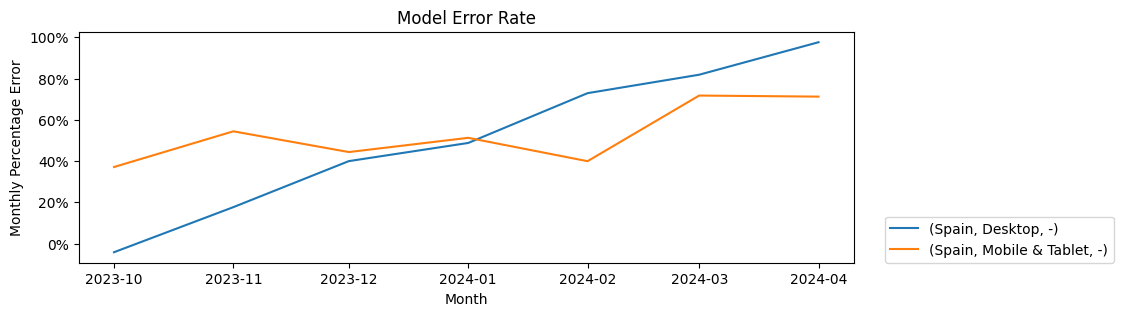

In [28]:
plot_printer = PlotAndSaveAccuracyDf()
fig = plot_printer.Plot(df_for_plt)
plot_name = "Accuracy_By_Month.jpg"
%load_ext autoreload
%autoreload 2

In [37]:
#fig.savefig(plot_name)
plot_printer.SaveToGCS(output_bucket,  plot_name, folder_name)

ups_bj_cost_by_device_optimization/UK/feb_2024_device_upd/Accuracy_By_Month.jpg
Image saved: ups_bj_cost_by_device_optimization/UK/feb_2024_device_upd/Accuracy_By_Month.jpg


In [40]:
# min_score = grid_competitor[(grid_competitor['account_type'] == 'Bing Ads')&(grid_competitor['funnel'] == 'Competitor')]['MAPE'].min()

# best_setting_df = grid_competitor[(grid_competitor['account_type'] == 'Bing Ads')&(grid_competitor['funnel'] == 'Competitor')\
#                                           &(grid_competitor['MAPE'] == min_score)]

In [22]:
# search_engine = ProphetParameterSearch()
# search_engine.add_power_params(num=5)
# df1, df2 = search_engine.search(cuts_df, df_filled)
# df2.to_csv('best_setting_df.csv')
# df1.to_csv('all_setting_result_acc_df.csv')  

In [23]:
# new_cuts_df = pd.read_csv('US Model Setting.csv')
# cuts_df_col_ls = ['market', 'account_type', 'funnel', 'starting_date', 'cutoff_month', 'periods', 'periods_for_acc_cal']
# new_cuts_df = new_cuts_df.merge(cuts_df[cuts_df_col_ls], how = 'left', on = ['market', 'account_type', 'funnel'])

# new_cuts_df.to_csv(config_dict['CLIENTINFO']['country'] + ' Breakdown.csv')
# generator = BreakdownSettingFileGenerator()
# new_cuts_df = generator.Generate(daily_df, config_dict, new_cuts_df)
# new_cuts_df = generator.Update()
# generator.SaveFile(bucket_name, folder_name, 'cuts_df.csv')
# new_cuts_df

In [24]:
# new_cuts_df.to_csv('cuts_df.csv')

In [42]:
# calculator = AccuracyCalculator()
# accuracy_df = calculator.CalculateAccuracy(new_cuts_df, df, query_item_list)
# # %load_ext autoreload
# # %autoreload 2
# calculator.SaveFile(bucket_name, folder_name, 'Finalized Model Score.csv')
# accuracy_df

In [58]:
# import json
# param_search_dict = {'power': 5,
#                      'growth': ['linear', 'logistic', 'power'],
#                     'seasonality_mode': ['additive', 'multiplicative'],
#                     'input_mode': ['additive', 'multiplicative'],
#                     'include_holiday': ['NA', 'Custom', 'Default'],
#                     'weekday_or_weekend': ['NA', 'additive', 'multiplicative'],
#                     'covid_year_exclude': ['Exclude', 'na'],
#                     'covid_year_dummy': ['NA', 'additive', 'multiplicative'],
#                     'anomaly_2021':['NA', 'additive', 'multiplicative'],
#                     }
# with open("param serach.json", "w") as outfile:
#     json.dump(param_search_dict, outfile)

In [59]:
# param_search_f = open("param serach.json")
# param_search_dict = json.load(param_search_f)
# power_number = int(param_search_dict['power']) 
# param_search_dict = {k: v for i, (k, v) in enumerate(param_search_dict.items()) if i > 1}
# power_number, param_search_dict

In [60]:
# import itertools
# list(itertools.product(*param_search_dict.values()))
# list(param_search_dict.keys())

# Model Generator

In [24]:
# %load_ext autoreload
# %autoreload 2
# model_generator = GenerateModelFile()
# model_generator.Generate(cuts_df, df_filled, query_item_list, output_bucket, folder_name)

# %load_ext autoreload
# %autoreload 
model_generator = GenerateModelFile()
model_generator.Generate(cuts_df, df_filled , query_item_list, output_bucket, folder_name, base_path=base_path)

03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing
03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing


# Constraint Setting

In [17]:
bounds = cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

# %load_ext autoreload
# %autoreload 2
constraint_file_generator = ConstraintFileGenerator(config_dict, analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds)
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 0.8
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 0.9
constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

Data Frame file saved


In [23]:
#constraint_file.to_csv('Constrain File.csv')
#constrain_file_generator.SaveFile(output_bucket, folder_name, 'Constraint File.csv')

In [26]:
df_filled[(df_filled.ds>='2024-01-01')&(df_filled.ds<='2024-01-10')].groupby(by='region').sum(numeric_only=1)

KeyError: 'region'

In [ ]:
cuts_df

In [29]:
# # cuts_df.loc[5, 'growth'] = 'linear'
# for i in cuts_df.itertuples():
#     pass

# import pickle
# from repo.Accuracy import MakeFuture
# file_name = "UK Mobile & Tablet -.pkl"
# pickle_file_path = base_path + file_name
# pickle_in = open(pickle_file_path,'rb') 
# # unpickled model is the model to use, training_dataset is used to get historical spend
# unpickled_model, training_dataset, model_df = pickle.load(pickle_in)

# analytical_file_copy = analytical_file_df.copy()
# market = 'UK'
# account_type = 'Mobile & Tablet'
# funnel = '-'

# spend_df_for_forecast = analytical_file_copy[(analytical_file_copy['market'] == market) & (analytical_file_copy['account_type'] == account_type) & \
#                                              (analytical_file_copy['funnel'] == funnel)].copy()
# spend_df_for_forecast['ds'] = pd.to_datetime(spend_df_for_forecast.ds)

# future = MakeFuture(unpickled_model, training_dataset, i, 183, spend_df_for_forecast)
# # print(training_dataset.ds.max(), i)
# forecast = unpickled_model.predict(future)
# unpickled_model.plot_components(forecast)

# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(unpickled_model, forecast)